In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from natsort import natsorted
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import cv2
# import pdb
import config
from glob import glob
import tensorflow as tf

# import lpips
import torch.nn as nn
from torchvision.models import resnet18
from torchsummary import summary

# from pytorch_metric_learning import miners, losses


2023-04-30 16:39:13.228565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 16:39:13.904191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(45)
torch.manual_seed(45)

In [4]:
class EEGDataset(Dataset):
    def __init__(self, eegs, labels, subjects=None, n_fft=64, win_length=64, hop_length=16):
        self.eegs         = eegs
        # self.images       = images
        self.labels       = labels
        # self.subjects     = subjects


    def __getitem__(self, index):
        eeg    = self.eegs[index]
        # eeg    = np.float32(self.eegs[index].cpu())
        norm   = torch.max(eeg) / 2.0
        eeg    = (eeg - norm)/ norm
        # eeg    = (eeg - np.min(eeg))/ (np.max(eeg) - np.min(eeg))
        # image  = self.images[index]
        label  = self.labels[index]
        # subject= self.subjects[index]
        return eeg, label

    def __len__(self):
        return len(self.eegs)


In [5]:

import pandas as pd
if __name__ == '__main__':

    base_path       = config.base_path
    train_path      = config.train_path
    validation_path = config.validation_path
    test_path = config.test_path
    device          = config.device
    batch_size = config.batch_size
    print(device)

    #load the data
    ## Training data
    x_train_eeg = []
    x_train_image = []
    labels = []
    # loaded_array = np.load("/home/ankita.jain/CNS_EEG/dataset/test/n07753592_11911_5.npy", allow_pickle=True)
    # print(loaded_array[1:])
    data_ = pd.DataFrame(columns=['EEG','Label',"ID",'Subject'])

    for i in tqdm(natsorted(os.listdir(base_path + train_path))):
        loaded_array = np.load(base_path + train_path + i, allow_pickle=True)
        # print(loaded_array)
        data_= data_.append(pd.DataFrame(loaded_array[1:].reshape(1,4),columns=['EEG','Label',"ID",'Subject']),ignore_index=True)
        # x_train_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
        # img = cv2.resize(loaded_array[0], (224, 224))
        # img = np.transpose(img, (2, 0, 1))
        # x_train_image.append(img)
        # labels.append(loaded_array[2])
        # train_subjects.append(loaded_array[4])


cuda


100%|██████████| 7959/7959 [00:05<00:00, 1492.59it/s]


In [6]:
d={}
for i in range(1,7):
    d['subject'+str(i)]= data_.iloc[np.where(data_['Subject']==i)]

In [7]:
from sklearn.model_selection import train_test_split
X_train = []
X_pool= []
y_train = []
y_pool = []
for i in range(1,7):
    X_tr, X_p, y_tr, y_p= train_test_split(np.array(d['subject'+str(i)]['EEG']),np.array(d['subject'+str(i)]['Label']),test_size=0.7,stratify=d['subject'+str(i)]['Label'])
    X_train.append(X_tr)
    X_pool.append(X_p)
    y_train.append(y_tr)
    y_pool.append(y_p)

In [8]:
X_train = [num for sublist in X_train for num in sublist]
X_train =[num.T for num in X_train]
X_pool = [num for sublist in X_pool for num in sublist]
X_pool =[num.T for num in X_pool]
y_train = [num for sublist in y_train for num in sublist]
y_pool = [num for sublist in y_pool for num in sublist]



In [9]:
X_train = np.array(X_train)
X_pool=np.array(X_pool)
y_pool= np.array(y_pool)
y_train= np.array(y_train)

In [10]:
x_train_eeg = torch.from_numpy(X_train).float().to(device)
train_labels = torch.from_numpy(y_train).long().to(device)
x_pool_eeg = torch.from_numpy(X_pool).float().to(device)
pool_labels = torch.from_numpy(y_pool).long().to(device)

In [11]:
class EEGFeatNet(nn.Module):
    def __init__(self, input_shape=(1, 440, 128), n_features=128, projection_dim=128, num_filters=[128, 256, 512, 1024], kernel_sizes=[3, 3, 3, 3], strides=[2, 2, 2, 2], padding=[1, 1, 1, 1]):
        super(EEGFeatNet, self).__init__()

        # Define the convolutional layers
        self.layers = nn.ModuleList()
        in_channels = input_shape[0]
        for i, out_channels in enumerate(num_filters):
            self.layers.append( 
                                nn.Sequential(
                                    nn.Conv2d(in_channels, out_channels, kernel_sizes[i], strides[i], padding[i], bias=False),\
                                    # nn.BatchNorm2d(out_channels),\
                                    nn.InstanceNorm2d(out_channels),\
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.05),
                                )
                             )
            in_channels = out_channels

        self.layers.append(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

        # Define the fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(num_filters[-1], projection_dim, bias=False),
            # nn.LeakyReLU(inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(projection_dim,out_features=40, bias=False),
        #     # nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        # Apply the convolutional layers
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)

        # Flatten the output
        x = torch.reshape(x, [x.shape[0], -1])
        # print(x.shape)

        # Apply the fully connected layers
        x = self.fc(x)
        x= self.fc2(x)
        return x

In [12]:
x_val_eeg = []
x_val_image = []
label_Val = []
val_subjects = []

for i in tqdm(natsorted(os.listdir(base_path + validation_path))):
    loaded_array = np.load(base_path + validation_path + i, allow_pickle=True)
    # x_val_eeg.append(loaded_array[1].T)
    x_val_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
    img = cv2.resize(loaded_array[0], (224, 224))
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) - 127.5) / 127.5
    img = np.transpose(img, (2, 0, 1))
    x_val_image.append(img)
    label_Val.append(loaded_array[2])
    val_subjects.append(loaded_array[4])
    
x_val_eeg   = np.array(x_val_eeg)
val_labels  = np.array(label_Val)

x_val_eeg   = torch.from_numpy(x_val_eeg).float().to(device)
val_labels  = torch.from_numpy(val_labels).long().to(device)

val_data       = EEGDataset(x_val_eeg, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=False, drop_last=True)

100%|██████████| 1994/1994 [00:01<00:00, 1051.74it/s]


In [13]:
x_test_eeg = []
x_test_image = []
label_Test = []
test_subjects = []

for i in tqdm(natsorted(os.listdir(base_path + test_path))):
    loaded_array = np.load(base_path + test_path + i, allow_pickle=True)
    # x_val_eeg.append(loaded_array[1].T)
    x_test_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
    img = cv2.resize(loaded_array[0], (224, 224))
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) - 127.5) / 127.5
    img = np.transpose(img, (2, 0, 1))
    x_test_image.append(img)
    label_Test.append(loaded_array[2])
    test_subjects.append(loaded_array[4])
    
x_test_eeg   = np.array(x_test_eeg)
test_labels  = np.array(label_Test)

x_test_eeg   = torch.from_numpy(x_test_eeg).float().to(device)
test_labels  = torch.from_numpy(test_labels).long().to(device)

test_data       = EEGDataset(x_test_eeg, test_labels)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=False, drop_last=True)

100%|██████████| 1987/1987 [00:01<00:00, 1011.43it/s]


In [14]:
def train(epoch, model, optimizer, loss_fn, x_train_eeg,train_labels):
    # print(x_train_eeg.shape,train_labels.shape)
    train_data  = EEGDataset(x_train_eeg, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=False, drop_last=True)

    running_loss      = []
    eeg_featvec_proj  = np.array([])
    labels_array      = np.array([])

    tq = tqdm(train_dataloader)
    for batch_idx, (eeg, labels) in enumerate(tq, start=1):
        eeg    = eeg.to(config.device)
        labels = labels.to(config.device)
        # print(eeg.shape)
        optimizer.zero_grad()
        y_pred = model(eeg.reshape(256,1,440,128))

        loss       = loss_fn(y_pred, labels)
        
        # backpropagate and update parameters
        loss.backward()
        optimizer.step()

        running_loss = running_loss + [loss.detach().cpu().numpy()]

        tq.set_description('Train:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

    if (epoch%config.vis_freq) == 0:
        # for batch_idx, (eeg, eeg_x1, eeg_x2, gamma, images, labels) in enumerate(tqdm(train_dataloader)):
        for batch_idx, (eeg, labels) in enumerate(tqdm(train_dataloader)):
            eeg, labels = eeg.to(config.device), labels.to(config.device)
            with torch.no_grad():
                x_proj = model(eeg.reshape(256,1,440,128))
            # eeg_featvec      = np.concatenate((eeg_featvec, x.cpu().detach().numpy()), axis=0) if eeg_featvec.size else x.cpu().detach().numpy()
            eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
            # eeg_gamma        = np.concatenate((eeg_gamma, gamma.cpu().detach().numpy()), axis=0) if eeg_gamma.size else gamma.cpu().detach().numpy()
            labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()
    acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
    print("[Epoch: {}, train Accuracy: {}]".format(epoch, acc))
    return np.mean(running_loss)

In [15]:
def validation(epoch, model, optimizer, loss_fn, val_dataloader):

	running_loss      = []
	eeg_featvec_proj  = np.array([])
	labels_array      = np.array([])

	tq = tqdm(val_dataloader)
	for batch_idx, (eeg, labels) in enumerate(tq, start=1):
		eeg, labels = eeg.to(config.device), labels.to(config.device)
		with torch.no_grad():
			model.eval()
			x_proj = model(eeg.reshape(256,1,440,128))

			# hard_pairs = miner(x_proj, labels)
			loss       = loss_fn(x_proj, labels)

			running_loss = running_loss + [loss.detach().cpu().numpy()]

		tq.set_description('Val:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

		eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
		labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()

	acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
	print("[Epoch: {}, Val Accuracy: {}]".format(epoch, acc))

	return np.mean(running_loss), acc

In [16]:
def test_fn(epoch, model, optimizer, loss_fn, test_dataloader):

	running_loss      = []
	eeg_featvec_proj  = np.array([])
	labels_array      = np.array([])

	tq = tqdm(test_dataloader)
	for batch_idx, (eeg, labels) in enumerate(tq, start=1):
		eeg, labels = eeg.to(config.device), labels.to(config.device)
		with torch.no_grad():
			x_proj = model(eeg.reshape(1,1,440,128))

			# hard_pairs = miner(x_proj, labels)
			loss       = loss_fn(x_proj, labels)

			running_loss = running_loss + [loss.detach().cpu().numpy()]

		tq.set_description('Val:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

		eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
		labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()

	acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
	print("[Epoch: {}, Val Accuracy: {}]".format(epoch, acc))

	return np.mean(running_loss), acc

In [17]:
def pool_check(epoch, model, optimizer, loss_fn, x_pool_eeg,pool_labels):
	pool_data = EEGDataset(x_pool_eeg,pool_labels)
	pool_dataloader = DataLoader(pool_data, batch_size=1, shuffle=True, pin_memory=False, drop_last=True)
	running_loss      = []
	eeg_featvec_proj  = np.array([])
	labels_array      = np.array([])

	def entr(outputs):
		batch_differences = []
		for j in range(len(outputs)):
			total = 0
			output_probs = outputs[j].data.cpu().detach().numpy()
			# print(output_probs)
			for item in output_probs:
				entropy = -1* item * np.log(item)
				total += entropy
			batch_differences.append(total)
			
		batch_mean = np.mean(batch_differences)
		return batch_mean

	tq = tqdm(pool_dataloader)
	batch_evaluation=[]
	for batch_idx, (eeg, labels) in enumerate(tq, start=1):
		eeg, labels = eeg.to(config.device), labels.to(config.device)
		# print(eeg.shape)
		with torch.no_grad():
			x_proj = model(eeg.reshape(1,1,440,128))
			entropyy= entr(x_proj)
			loss       = loss_fn(x_proj, labels)
			batch_evaluation.append(entropyy)
			running_loss = running_loss + [loss.detach().cpu().numpy()]

		# tq.set_description('Val:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

		eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
		labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()
	
	batch_evaluation= np.array(batch_evaluation)
	largest = list((-batch_evaluation).argsort()[:100])

	acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
	print("[Epoch: {}, Pool Accuracy: {}]".format(epoch, acc))

	return largest

In [18]:
test_acc_list=[]
final_train_losses = []
final_val_losses = []
final_val_accs=[]
for i in range(40):    
    model     = EEGFeatNet(input_shape=config.input_shape, n_features=config.feat_dim, projection_dim=config.projection_dim).to(config.device)
    model     = torch.nn.DataParallel(model).to(config.device)

    optimizer = torch.optim.Adam(\
                                        list(model.parameters()),\
                                        lr=config.lr,\
                                        betas=(0.9, 0.999)
                                    )
    loss_fn  = nn.CrossEntropyLoss()
    EPOCHS = config.epoch
    train_losses = []
    val_losses = []
    val_accs=[]
    for epoch in range(0, EPOCHS):
            running_train_loss = train(epoch, model, optimizer, loss_fn, x_train_eeg, train_labels)
            running_val_loss,acc = validation(epoch, model, optimizer, loss_fn, val_dataloader)
            train_losses.append(running_train_loss)
            val_losses.append(running_val_loss)
            val_accs.append(acc)

    test_loss, test_acc   = test_fn(epoch, model, optimizer, loss_fn, test_dataloader)
    test_acc_list.append(test_acc)
    final_train_losses.append(train_losses)
    final_val_losses.append(val_losses)
    final_val_accs.append(val_accs)
    largest_batch = pool_check(epoch, model, optimizer, loss_fn, x_pool_eeg,pool_labels)
    x_train_eeg = torch.tensor(np.concatenate((x_train_eeg.cpu().detach().numpy(), x_pool_eeg[largest_batch].cpu().detach().numpy()), axis=0)) if x_train_eeg.size else x_pool_eeg[largest_batch].cpu().detach().numpy()
    train_labels = torch.tensor(np.concatenate((train_labels.cpu().detach().numpy(), pool_labels[largest_batch].cpu().detach().numpy()), axis=0)) if train_labels.size else pool_labels[largest_batch].cpu().detach().numpy()
    x_pool_eeg= torch.tensor(np.delete(x_pool_eeg.cpu().detach().numpy(),largest_batch,axis=0))
    pool_labels = torch.tensor(np.delete(pool_labels.cpu().detach().numpy(),largest_batch))
    print(x_pool_eeg.shape,x_train_eeg.shape)


100%|██████████| 9/9 [00:00<00:00, 20.36it/s]


[Epoch: 0, train Accuracy: 0.0360243059694767]


Val:[0, 3.691]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 0, Val Accuracy: 0.03515625]


100%|██████████| 9/9 [00:00<00:00, 22.67it/s]


[Epoch: 1, train Accuracy: 0.0568576380610466]


Val:[1, 3.656]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 1, Val Accuracy: 0.0463169626891613]


100%|██████████| 9/9 [00:00<00:00, 22.63it/s]


[Epoch: 2, train Accuracy: 0.1032986119389534]


Val:[2, 3.640]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 2, Val Accuracy: 0.07421875]


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


[Epoch: 3, train Accuracy: 0.1115451380610466]


Val:[3, 3.608]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 3, Val Accuracy: 0.0747767835855484]


100%|██████████| 9/9 [00:00<00:00, 22.54it/s]


[Epoch: 4, train Accuracy: 0.1163194477558136]


Val:[4, 3.576]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 4, Val Accuracy: 0.0831473246216774]


100%|██████████| 9/9 [00:00<00:00, 22.69it/s]


[Epoch: 5, train Accuracy: 0.1848958283662796]


Val:[5, 3.535]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 5, Val Accuracy: 0.1255580335855484]


100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


[Epoch: 6, train Accuracy: 0.19140625]


Val:[6, 3.482]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 6, Val Accuracy: 0.1194196417927742]


100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


[Epoch: 7, train Accuracy: 0.1827256977558136]


Val:[7, 3.402]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 7, Val Accuracy: 0.1300223171710968]


100%|██████████| 9/9 [00:00<00:00, 22.52it/s]


[Epoch: 8, train Accuracy: 0.1875]


Val:[8, 3.307]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 8, Val Accuracy: 0.1322544664144516]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 9, train Accuracy: 0.2113715261220932]


Val:[9, 3.199]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 9, Val Accuracy: 0.1434151828289032]


100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


[Epoch: 10, train Accuracy: 0.2486979216337204]


Val:[10, 3.099]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 10, Val Accuracy: 0.1819196492433548]


100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


[Epoch: 11, train Accuracy: 0.2912326455116272]


Val:[11, 3.006]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 11, Val Accuracy: 0.2114955335855484]


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


[Epoch: 12, train Accuracy: 0.2734375]


Val:[12, 2.931]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 12, Val Accuracy: 0.1858258992433548]


100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


[Epoch: 13, train Accuracy: 0.3350694477558136]


Val:[13, 2.846]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 13, Val Accuracy: 0.2410714328289032]


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


[Epoch: 14, train Accuracy: 0.3250868022441864]


Val:[14, 2.772]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 14, Val Accuracy: 0.2204241007566452]


100%|██████████| 9/9 [00:00<00:00, 22.40it/s]


[Epoch: 15, train Accuracy: 0.3680555522441864]


Val:[15, 2.679]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 15, Val Accuracy: 0.2806919515132904]


100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


[Epoch: 16, train Accuracy: 0.3350694477558136]


Val:[16, 2.632]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 16, Val Accuracy: 0.2527901828289032]


100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


[Epoch: 17, train Accuracy: 0.3745659589767456]


Val:[17, 2.570]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 17, Val Accuracy: 0.2667410671710968]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 18, train Accuracy: 0.3810763955116272]


Val:[18, 2.511]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 18, Val Accuracy: 0.2974330484867096]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 19, train Accuracy: 0.40234375]


Val:[19, 2.463]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 19, Val Accuracy: 0.3058035671710968]


100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


[Epoch: 20, train Accuracy: 0.41796875]


Val:[20, 2.381]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 20, Val Accuracy: 0.3147321343421936]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 21, train Accuracy: 0.4301215410232544]


Val:[21, 2.335]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 21, Val Accuracy: 0.3147321343421936]


100%|██████████| 9/9 [00:00<00:00, 22.67it/s]


[Epoch: 22, train Accuracy: 0.4618055522441864]


Val:[22, 2.280]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 22, Val Accuracy: 0.3392857015132904]


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


[Epoch: 23, train Accuracy: 0.4652777910232544]


Val:[23, 2.223]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 23, Val Accuracy: 0.3465401828289032]


100%|██████████| 9/9 [00:00<00:00, 22.56it/s]


[Epoch: 24, train Accuracy: 0.4674479067325592]


Val:[24, 2.165]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 24, Val Accuracy: 0.3655133843421936]


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


[Epoch: 25, train Accuracy: 0.5095486044883728]


Val:[25, 2.125]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 25, Val Accuracy: 0.40234375]


100%|██████████| 9/9 [00:00<00:00, 22.60it/s]


[Epoch: 26, train Accuracy: 0.5104166865348816]


Val:[26, 2.090]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 26, Val Accuracy: 0.3934151828289032]


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


[Epoch: 27, train Accuracy: 0.5551215410232544]


Val:[27, 2.047]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 27, Val Accuracy: 0.4241071343421936]


100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


[Epoch: 28, train Accuracy: 0.5763888955116272]


Val:[28, 1.994]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 28, Val Accuracy: 0.4542410671710968]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 29, train Accuracy: 0.5494791865348816]


Val:[29, 1.981]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 29, Val Accuracy: 0.4324776828289032]


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


[Epoch: 30, train Accuracy: 0.5954861044883728]


Val:[30, 1.924]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 30, Val Accuracy: 0.47265625]


100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


[Epoch: 31, train Accuracy: 0.5924479365348816]


Val:[31, 1.879]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 31, Val Accuracy: 0.4642857015132904]


100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


[Epoch: 32, train Accuracy: 0.6493055820465088]


Val:[32, 1.823]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 32, Val Accuracy: 0.5228794813156128]


100%|██████████| 9/9 [00:00<00:00, 22.19it/s]


[Epoch: 33, train Accuracy: 0.6657986044883728]


Val:[33, 1.769]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 33, Val Accuracy: 0.5323660969734192]


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


[Epoch: 34, train Accuracy: 0.6527777910232544]


Val:[34, 1.745]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 34, Val Accuracy: 0.5290178656578064]


100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


[Epoch: 35, train Accuracy: 0.6653645634651184]


Val:[35, 1.701]: 100%|██████████| 7/7 [00:00<00:00, 21.50it/s]


[Epoch: 35, Val Accuracy: 0.5390625]


100%|██████████| 9/9 [00:00<00:00, 22.40it/s]


[Epoch: 36, train Accuracy: 0.6675347089767456]


Val:[36, 1.689]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 36, Val Accuracy: 0.5290178656578064]


100%|██████████| 9/9 [00:00<00:00, 22.42it/s]


[Epoch: 37, train Accuracy: 0.6940104365348816]


Val:[37, 1.623]: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


[Epoch: 37, Val Accuracy: 0.5558035969734192]


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


[Epoch: 38, train Accuracy: 0.7213541865348816]


Val:[38, 1.592]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 38, Val Accuracy: 0.5786830186843872]


100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


[Epoch: 39, train Accuracy: 0.6922743320465088]


Val:[39, 1.588]: 100%|██████████| 7/7 [00:00<00:00, 21.35it/s]


[Epoch: 39, Val Accuracy: 0.5641741156578064]


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


[Epoch: 40, train Accuracy: 0.7356770634651184]


Val:[40, 1.513]: 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


[Epoch: 40, Val Accuracy: 0.5848214030265808]


100%|██████████| 9/9 [00:00<00:00, 22.68it/s]


[Epoch: 41, train Accuracy: 0.7408854365348816]


Val:[41, 1.484]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 41, Val Accuracy: 0.6060267686843872]


100%|██████████| 9/9 [00:00<00:00, 22.46it/s]


[Epoch: 42, train Accuracy: 0.7426215410232544]


Val:[42, 1.470]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 42, Val Accuracy: 0.6043526530265808]


100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


[Epoch: 43, train Accuracy: 0.7599826455116272]


Val:[43, 1.442]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 43, Val Accuracy: 0.62890625]


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


[Epoch: 44, train Accuracy: 0.7235243320465088]


Val:[44, 1.442]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 44, Val Accuracy: 0.5948660969734192]


100%|██████████| 9/9 [00:00<00:00, 22.46it/s]


[Epoch: 45, train Accuracy: 0.7699652910232544]


Val:[45, 1.382]: 100%|██████████| 7/7 [00:00<00:00, 21.18it/s]


[Epoch: 45, Val Accuracy: 0.6450892686843872]


100%|██████████| 9/9 [00:00<00:00, 22.69it/s]


[Epoch: 46, train Accuracy: 0.8042534589767456]


Val:[46, 1.361]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 46, Val Accuracy: 0.65234375]


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


[Epoch: 47, train Accuracy: 0.7934027910232544]


Val:[47, 1.323]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 47, Val Accuracy: 0.6534598469734192]


100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


[Epoch: 48, train Accuracy: 0.7855902910232544]


Val:[48, 1.321]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 48, Val Accuracy: 0.6456473469734192]


100%|██████████| 9/9 [00:00<00:00, 22.56it/s]


[Epoch: 49, train Accuracy: 0.8337673544883728]


Val:[49, 1.257]: 100%|██████████| 7/7 [00:00<00:00, 21.46it/s]


[Epoch: 49, Val Accuracy: 0.6724330186843872]


Val:[49, 1.269]: 100%|██████████| 1987/1987 [00:04<00:00, 401.06it/s]


[Epoch: 49, Val Accuracy: 0.6763965487480164]


  0%|          | 0/5573 [00:00<?, ?it/s]/tmp/ipykernel_946178/1762506513.py:15: RuntimeWarning: invalid value encountered in log
  entropy = -1* item * np.log(item)
100%|██████████| 5573/5573 [00:07<00:00, 701.47it/s]


[Epoch: 49, Pool Accuracy: 0.6944195032119751]
torch.Size([5473, 440, 128]) torch.Size([2486, 440, 128])


100%|██████████| 9/9 [00:00<00:00, 11.13it/s]


[Epoch: 0, train Accuracy: 0.03081597201526165]


Val:[0, 3.672]: 100%|██████████| 7/7 [00:00<00:00, 21.46it/s]


[Epoch: 0, Val Accuracy: 0.0412946417927742]


100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


[Epoch: 1, train Accuracy: 0.1059027761220932]


Val:[1, 3.666]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 1, Val Accuracy: 0.0736607164144516]


100%|██████████| 9/9 [00:00<00:00, 11.38it/s]


[Epoch: 2, train Accuracy: 0.0785590261220932]


Val:[2, 3.629]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 2, Val Accuracy: 0.05078125]


100%|██████████| 9/9 [00:00<00:00, 11.55it/s]


[Epoch: 3, train Accuracy: 0.1167534738779068]


Val:[3, 3.601]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 3, Val Accuracy: 0.0887276753783226]


100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


[Epoch: 4, train Accuracy: 0.1475694477558136]


Val:[4, 3.564]: 100%|██████████| 7/7 [00:00<00:00, 21.56it/s]


[Epoch: 4, Val Accuracy: 0.1233258917927742]


100%|██████████| 9/9 [00:00<00:00, 11.01it/s]


[Epoch: 5, train Accuracy: 0.12890625]


Val:[5, 3.516]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 5, Val Accuracy: 0.1082589253783226]


100%|██████████| 9/9 [00:00<00:00, 11.58it/s]


[Epoch: 6, train Accuracy: 0.1597222238779068]


Val:[6, 3.456]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 6, Val Accuracy: 0.1238839253783226]


100%|██████████| 9/9 [00:00<00:00, 11.24it/s]


[Epoch: 7, train Accuracy: 0.1905381977558136]


Val:[7, 3.369]: 100%|██████████| 7/7 [00:00<00:00, 22.36it/s]


[Epoch: 7, Val Accuracy: 0.1467633992433548]


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


[Epoch: 8, train Accuracy: 0.2013888955116272]


Val:[8, 3.272]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 8, Val Accuracy: 0.1590401828289032]


100%|██████████| 9/9 [00:00<00:00,  9.26it/s]


[Epoch: 9, train Accuracy: 0.1866319477558136]


Val:[9, 3.185]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 9, Val Accuracy: 0.1473214328289032]


100%|██████████| 9/9 [00:00<00:00, 11.37it/s]


[Epoch: 10, train Accuracy: 0.2395833283662796]


Val:[10, 3.087]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 10, Val Accuracy: 0.1768973171710968]


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


[Epoch: 11, train Accuracy: 0.2621527910232544]


Val:[11, 2.973]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 11, Val Accuracy: 0.2053571492433548]


100%|██████████| 9/9 [00:00<00:00, 11.21it/s]


[Epoch: 12, train Accuracy: 0.2404513955116272]


Val:[12, 2.928]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 12, Val Accuracy: 0.1941964328289032]


100%|██████████| 9/9 [00:00<00:00, 11.01it/s]


[Epoch: 13, train Accuracy: 0.3550347089767456]


Val:[13, 2.833]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 13, Val Accuracy: 0.2739955484867096]


100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


[Epoch: 14, train Accuracy: 0.3576388955116272]


Val:[14, 2.741]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 14, Val Accuracy: 0.2678571343421936]


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


[Epoch: 15, train Accuracy: 0.3589409589767456]


Val:[15, 2.672]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 15, Val Accuracy: 0.2784598171710968]


100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


[Epoch: 16, train Accuracy: 0.3893229067325592]


Val:[16, 2.592]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 16, Val Accuracy: 0.2985491156578064]


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


[Epoch: 17, train Accuracy: 0.3936631977558136]


Val:[17, 2.524]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 17, Val Accuracy: 0.3074776828289032]


100%|██████████| 9/9 [00:00<00:00, 11.22it/s]


[Epoch: 18, train Accuracy: 0.4188368022441864]


Val:[18, 2.474]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 18, Val Accuracy: 0.3225446343421936]


100%|██████████| 9/9 [00:00<00:00,  9.05it/s]


[Epoch: 19, train Accuracy: 0.4418402910232544]


Val:[19, 2.420]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 19, Val Accuracy: 0.3236607015132904]


100%|██████████| 9/9 [00:00<00:00, 10.71it/s]


[Epoch: 20, train Accuracy: 0.4461805522441864]


Val:[20, 2.354]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 20, Val Accuracy: 0.3621651828289032]


100%|██████████| 9/9 [00:00<00:00, 11.19it/s]


[Epoch: 21, train Accuracy: 0.4574652910232544]


Val:[21, 2.287]: 100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


[Epoch: 21, Val Accuracy: 0.3783482015132904]


100%|██████████| 9/9 [00:00<00:00, 11.43it/s]


[Epoch: 22, train Accuracy: 0.4869791567325592]


Val:[22, 2.251]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 22, Val Accuracy: 0.3677455484867096]


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


[Epoch: 23, train Accuracy: 0.4765625]


Val:[23, 2.195]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 23, Val Accuracy: 0.3766741156578064]


100%|██████████| 9/9 [00:00<00:00,  9.64it/s]


[Epoch: 24, train Accuracy: 0.5173611044883728]


Val:[24, 2.138]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 24, Val Accuracy: 0.39453125]


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


[Epoch: 25, train Accuracy: 0.5234375]


Val:[25, 2.082]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 25, Val Accuracy: 0.390625]


100%|██████████| 9/9 [00:00<00:00, 12.27it/s]


[Epoch: 26, train Accuracy: 0.5447048544883728]


Val:[26, 2.033]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 26, Val Accuracy: 0.4207589328289032]


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


[Epoch: 27, train Accuracy: 0.53515625]


Val:[27, 1.993]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 27, Val Accuracy: 0.4224330484867096]


100%|██████████| 9/9 [00:00<00:00, 11.40it/s]


[Epoch: 28, train Accuracy: 0.5525173544883728]


Val:[28, 1.955]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 28, Val Accuracy: 0.4363839328289032]


100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


[Epoch: 29, train Accuracy: 0.5590277910232544]


Val:[29, 1.922]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 29, Val Accuracy: 0.4425223171710968]


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


[Epoch: 30, train Accuracy: 0.5972222089767456]


Val:[30, 1.860]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 30, Val Accuracy: 0.4720982015132904]


100%|██████████| 9/9 [00:00<00:00, 12.24it/s]


[Epoch: 31, train Accuracy: 0.5933159589767456]


Val:[31, 1.843]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 31, Val Accuracy: 0.4838169515132904]


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


[Epoch: 32, train Accuracy: 0.5946180820465088]


Val:[32, 1.811]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 32, Val Accuracy: 0.4709821343421936]


100%|██████████| 9/9 [00:00<00:00, 10.50it/s]


[Epoch: 33, train Accuracy: 0.6332465410232544]


Val:[33, 1.746]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 33, Val Accuracy: 0.5005580186843872]


100%|██████████| 9/9 [00:00<00:00, 10.72it/s]


[Epoch: 34, train Accuracy: 0.6393229365348816]


Val:[34, 1.696]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 34, Val Accuracy: 0.5279017686843872]


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


[Epoch: 35, train Accuracy: 0.6540798544883728]


Val:[35, 1.662]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 35, Val Accuracy: 0.53125]


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


[Epoch: 36, train Accuracy: 0.6831597089767456]


Val:[36, 1.636]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 36, Val Accuracy: 0.5401785969734192]


100%|██████████| 9/9 [00:00<00:00, 11.35it/s]


[Epoch: 37, train Accuracy: 0.6896701455116272]


Val:[37, 1.597]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 37, Val Accuracy: 0.5625]


100%|██████████| 9/9 [00:00<00:00, 11.23it/s]


[Epoch: 38, train Accuracy: 0.6966145634651184]


Val:[38, 1.567]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 38, Val Accuracy: 0.5457589030265808]


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


[Epoch: 39, train Accuracy: 0.7109375]


Val:[39, 1.525]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 39, Val Accuracy: 0.5814732313156128]


100%|██████████| 9/9 [00:00<00:00, 12.36it/s]


[Epoch: 40, train Accuracy: 0.7391493320465088]


Val:[40, 1.506]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 40, Val Accuracy: 0.5803571343421936]


100%|██████████| 9/9 [00:00<00:00, 11.11it/s]


[Epoch: 41, train Accuracy: 0.7339409589767456]


Val:[41, 1.470]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 41, Val Accuracy: 0.6015625]


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


[Epoch: 42, train Accuracy: 0.74609375]


Val:[42, 1.446]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 42, Val Accuracy: 0.6010044813156128]


100%|██████████| 9/9 [00:00<00:00, 11.46it/s]


[Epoch: 43, train Accuracy: 0.7747395634651184]


Val:[43, 1.407]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 43, Val Accuracy: 0.6143973469734192]


100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


[Epoch: 44, train Accuracy: 0.7730034589767456]


Val:[44, 1.372]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 44, Val Accuracy: 0.6300223469734192]


100%|██████████| 9/9 [00:00<00:00, 11.58it/s]


[Epoch: 45, train Accuracy: 0.7860243320465088]


Val:[45, 1.355]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 45, Val Accuracy: 0.6266741156578064]


100%|██████████| 9/9 [00:00<00:00, 11.44it/s]


[Epoch: 46, train Accuracy: 0.7903645634651184]


Val:[46, 1.358]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 46, Val Accuracy: 0.6344866156578064]


100%|██████████| 9/9 [00:00<00:00, 11.37it/s]


[Epoch: 47, train Accuracy: 0.7868923544883728]


Val:[47, 1.318]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 47, Val Accuracy: 0.6400669813156128]


100%|██████████| 9/9 [00:00<00:00, 11.41it/s]


[Epoch: 48, train Accuracy: 0.8276909589767456]


Val:[48, 1.266]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 48, Val Accuracy: 0.6774553656578064]


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


[Epoch: 49, train Accuracy: 0.7916666865348816]


Val:[49, 1.275]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 49, Val Accuracy: 0.6534598469734192]


Val:[49, 1.281]: 100%|██████████| 1987/1987 [00:05<00:00, 383.64it/s]


[Epoch: 49, Val Accuracy: 0.6512330174446106]


100%|██████████| 5473/5473 [00:12<00:00, 425.38it/s]


[Epoch: 49, Pool Accuracy: 0.6654485464096069]
torch.Size([5373, 440, 128]) torch.Size([2586, 440, 128])


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


[Epoch: 0, train Accuracy: 0.0390625]


Val:[0, 3.705]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 0, Val Accuracy: 0.0323660708963871]


100%|██████████| 10/10 [00:00<00:00, 11.08it/s]


[Epoch: 1, train Accuracy: 0.07304687798023224]


Val:[1, 3.641]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 1, Val Accuracy: 0.0625]


100%|██████████| 10/10 [00:00<00:00, 11.27it/s]


[Epoch: 2, train Accuracy: 0.07890625298023224]


Val:[2, 3.636]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 2, Val Accuracy: 0.0463169626891613]


100%|██████████| 10/10 [00:00<00:00, 11.24it/s]


[Epoch: 3, train Accuracy: 0.12734374403953552]


Val:[3, 3.586]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 3, Val Accuracy: 0.0943080335855484]


100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


[Epoch: 4, train Accuracy: 0.16953125596046448]


Val:[4, 3.558]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 4, Val Accuracy: 0.1244419664144516]


100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


[Epoch: 5, train Accuracy: 0.16367188096046448]


Val:[5, 3.497]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 5, Val Accuracy: 0.1244419664144516]


100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


[Epoch: 6, train Accuracy: 0.17929688096046448]


Val:[6, 3.426]: 100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


[Epoch: 6, Val Accuracy: 0.1311383992433548]


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


[Epoch: 7, train Accuracy: 0.23984375596046448]


Val:[7, 3.322]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 7, Val Accuracy: 0.171875]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


[Epoch: 8, train Accuracy: 0.23515625298023224]


Val:[8, 3.225]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 8, Val Accuracy: 0.1746651828289032]


100%|██████████| 10/10 [00:00<00:00, 10.50it/s]


[Epoch: 9, train Accuracy: 0.24257811903953552]


Val:[9, 3.112]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 9, Val Accuracy: 0.1768973171710968]


100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


[Epoch: 10, train Accuracy: 0.28632813692092896]


Val:[10, 2.999]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 10, Val Accuracy: 0.2114955335855484]


100%|██████████| 10/10 [00:00<00:00, 11.00it/s]


[Epoch: 11, train Accuracy: 0.2660156190395355]


Val:[11, 2.894]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 11, Val Accuracy: 0.2025669664144516]


100%|██████████| 10/10 [01:03<00:00,  6.40s/it]


[Epoch: 12, train Accuracy: 0.3285156190395355]


Val:[12, 2.799]: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


[Epoch: 12, Val Accuracy: 0.2377232164144516]


100%|██████████| 10/10 [01:34<00:00,  9.41s/it]


[Epoch: 13, train Accuracy: 0.34101563692092896]


Val:[13, 2.717]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 13, Val Accuracy: 0.2410714328289032]


100%|██████████| 10/10 [00:01<00:00,  9.90it/s]


[Epoch: 14, train Accuracy: 0.3515625]


Val:[14, 2.627]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 14, Val Accuracy: 0.2600446343421936]


100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


[Epoch: 15, train Accuracy: 0.37617188692092896]


Val:[15, 2.534]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 15, Val Accuracy: 0.2779017984867096]


100%|██████████| 10/10 [00:00<00:00, 10.73it/s]


[Epoch: 16, train Accuracy: 0.4066406190395355]


Val:[16, 2.460]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 16, Val Accuracy: 0.2946428656578064]


100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


[Epoch: 17, train Accuracy: 0.419921875]


Val:[17, 2.394]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 17, Val Accuracy: 0.3074776828289032]


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


[Epoch: 18, train Accuracy: 0.4296875]


Val:[18, 2.347]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 18, Val Accuracy: 0.3348214328289032]


100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


[Epoch: 19, train Accuracy: 0.44062501192092896]


Val:[19, 2.256]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 19, Val Accuracy: 0.3275669515132904]


100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


[Epoch: 20, train Accuracy: 0.47773438692092896]


Val:[20, 2.191]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 20, Val Accuracy: 0.3761160671710968]


100%|██████████| 10/10 [00:00<00:00, 11.56it/s]


[Epoch: 21, train Accuracy: 0.5035156011581421]


Val:[21, 2.136]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 21, Val Accuracy: 0.3856026828289032]


100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


[Epoch: 22, train Accuracy: 0.5074218511581421]


Val:[22, 2.075]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 22, Val Accuracy: 0.3978794515132904]


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


[Epoch: 23, train Accuracy: 0.54296875]


Val:[23, 2.024]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 23, Val Accuracy: 0.4358258843421936]


100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


[Epoch: 24, train Accuracy: 0.548828125]


Val:[24, 1.983]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 24, Val Accuracy: 0.4375]


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


[Epoch: 25, train Accuracy: 0.548046886920929]


Val:[25, 1.938]: 100%|██████████| 7/7 [00:00<00:00, 21.65it/s]


[Epoch: 25, Val Accuracy: 0.4464285671710968]


100%|██████████| 10/10 [00:00<00:00, 11.92it/s]


[Epoch: 26, train Accuracy: 0.5660156011581421]


Val:[26, 1.900]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 26, Val Accuracy: 0.45703125]


100%|██████████| 10/10 [00:00<00:00, 11.87it/s]


[Epoch: 27, train Accuracy: 0.604296863079071]


Val:[27, 1.836]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 27, Val Accuracy: 0.4827008843421936]


100%|██████████| 10/10 [00:00<00:00, 11.06it/s]


[Epoch: 28, train Accuracy: 0.5855468511581421]


Val:[28, 1.791]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 28, Val Accuracy: 0.4899553656578064]


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


[Epoch: 29, train Accuracy: 0.639843761920929]


Val:[29, 1.763]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 29, Val Accuracy: 0.5111607313156128]


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


[Epoch: 30, train Accuracy: 0.6636718511581421]


Val:[30, 1.718]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 30, Val Accuracy: 0.53515625]


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


[Epoch: 31, train Accuracy: 0.6714843511581421]


Val:[31, 1.676]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 31, Val Accuracy: 0.5407366156578064]


100%|██████████| 10/10 [00:00<00:00, 11.60it/s]


[Epoch: 32, train Accuracy: 0.684765636920929]


Val:[32, 1.632]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 32, Val Accuracy: 0.5541294813156128]


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


[Epoch: 33, train Accuracy: 0.709765613079071]


Val:[33, 1.590]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 33, Val Accuracy: 0.5887276530265808]


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


[Epoch: 34, train Accuracy: 0.710156261920929]


Val:[34, 1.540]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 34, Val Accuracy: 0.5831473469734192]


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


[Epoch: 35, train Accuracy: 0.698437511920929]


Val:[35, 1.531]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 35, Val Accuracy: 0.5541294813156128]


100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


[Epoch: 36, train Accuracy: 0.7230468988418579]


Val:[36, 1.481]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 36, Val Accuracy: 0.6043526530265808]


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


[Epoch: 37, train Accuracy: 0.73828125]


Val:[37, 1.434]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 37, Val Accuracy: 0.6160714030265808]


100%|██████████| 10/10 [03:10<00:00, 19.05s/it]


[Epoch: 38, train Accuracy: 0.7328125238418579]


Val:[38, 1.436]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 38, Val Accuracy: 0.6071428656578064]


100%|██████████| 10/10 [03:06<00:00, 18.69s/it]


[Epoch: 39, train Accuracy: 0.7828124761581421]


Val:[39, 1.369]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 39, Val Accuracy: 0.6551339030265808]


100%|██████████| 10/10 [02:25<00:00, 14.59s/it]


[Epoch: 40, train Accuracy: 0.7847656011581421]


Val:[40, 1.362]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 40, Val Accuracy: 0.6395089030265808]


100%|██████████| 10/10 [02:15<00:00, 13.53s/it]


[Epoch: 41, train Accuracy: 0.7828124761581421]


Val:[41, 1.337]: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


[Epoch: 41, Val Accuracy: 0.6484375]


100%|██████████| 10/10 [03:37<00:00, 21.77s/it]


[Epoch: 42, train Accuracy: 0.805859386920929]


Val:[42, 1.286]: 100%|██████████| 7/7 [00:00<00:00, 21.47it/s]


[Epoch: 42, Val Accuracy: 0.65625]


100%|██████████| 10/10 [01:05<00:00,  6.58s/it]


[Epoch: 43, train Accuracy: 0.7972656488418579]


Val:[43, 1.271]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 43, Val Accuracy: 0.6618303656578064]


100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


[Epoch: 44, train Accuracy: 0.822265625]


Val:[44, 1.246]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 44, Val Accuracy: 0.6763392686843872]


100%|██████████| 10/10 [00:00<00:00, 11.61it/s]


[Epoch: 45, train Accuracy: 0.830859363079071]


Val:[45, 1.223]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 45, Val Accuracy: 0.6713169813156128]


100%|██████████| 10/10 [00:00<00:00, 11.72it/s]


[Epoch: 46, train Accuracy: 0.8500000238418579]


Val:[46, 1.181]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 46, Val Accuracy: 0.7025669813156128]


100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


[Epoch: 47, train Accuracy: 0.8628906011581421]


Val:[47, 1.146]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 47, Val Accuracy: 0.7131696343421936]


100%|██████████| 10/10 [00:00<00:00, 11.01it/s]


[Epoch: 48, train Accuracy: 0.8500000238418579]


Val:[48, 1.145]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 48, Val Accuracy: 0.6953125]


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


[Epoch: 49, train Accuracy: 0.8511718511581421]


Val:[49, 1.139]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 49, Val Accuracy: 0.7109375]


Val:[49, 1.158]: 100%|██████████| 1987/1987 [00:05<00:00, 387.81it/s]


[Epoch: 49, Val Accuracy: 0.708605945110321]


100%|██████████| 5373/5373 [00:14<00:00, 359.49it/s]


[Epoch: 49, Pool Accuracy: 0.7085427045822144]
torch.Size([5273, 440, 128]) torch.Size([2686, 440, 128])


100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


[Epoch: 0, train Accuracy: 0.03007812425494194]


Val:[0, 3.701]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 0, Val Accuracy: 0.02678571455180645]


100%|██████████| 10/10 [00:00<00:00, 10.91it/s]


[Epoch: 1, train Accuracy: 0.09648437798023224]


Val:[1, 3.664]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 1, Val Accuracy: 0.0591517873108387]


100%|██████████| 10/10 [00:00<00:00, 10.71it/s]


[Epoch: 2, train Accuracy: 0.09687499701976776]


Val:[2, 3.633]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 2, Val Accuracy: 0.0625]


100%|██████████| 10/10 [00:00<00:00, 10.06it/s]


[Epoch: 3, train Accuracy: 0.16718749701976776]


Val:[3, 3.592]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 3, Val Accuracy: 0.1222098246216774]


100%|██████████| 10/10 [00:00<00:00, 10.58it/s]


[Epoch: 4, train Accuracy: 0.17070312798023224]


Val:[4, 3.561]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 4, Val Accuracy: 0.1037946417927742]


100%|██████████| 10/10 [00:00<00:00, 11.08it/s]


[Epoch: 5, train Accuracy: 0.20195312798023224]


Val:[5, 3.499]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 5, Val Accuracy: 0.1378348171710968]


100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


[Epoch: 6, train Accuracy: 0.21757812798023224]


Val:[6, 3.409]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 6, Val Accuracy: 0.1556919664144516]


100%|██████████| 10/10 [00:00<00:00, 11.11it/s]


[Epoch: 7, train Accuracy: 0.18359375]


Val:[7, 3.313]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 7, Val Accuracy: 0.1160714253783226]


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


[Epoch: 8, train Accuracy: 0.23671874403953552]


Val:[8, 3.206]: 100%|██████████| 7/7 [00:00<00:00, 21.41it/s]


[Epoch: 8, Val Accuracy: 0.1595982164144516]


100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


[Epoch: 9, train Accuracy: 0.2535156309604645]


Val:[9, 3.101]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 9, Val Accuracy: 0.1819196492433548]


100%|██████████| 10/10 [00:00<00:00, 10.56it/s]


[Epoch: 10, train Accuracy: 0.279296875]


Val:[10, 2.989]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 10, Val Accuracy: 0.1936383992433548]


100%|██████████| 10/10 [00:00<00:00, 10.98it/s]


[Epoch: 11, train Accuracy: 0.29296875]


Val:[11, 2.897]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 11, Val Accuracy: 0.2064732164144516]


100%|██████████| 10/10 [00:00<00:00, 11.27it/s]


[Epoch: 12, train Accuracy: 0.3023437559604645]


Val:[12, 2.806]: 100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


[Epoch: 12, Val Accuracy: 0.2170758992433548]


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


[Epoch: 13, train Accuracy: 0.3453125059604645]


Val:[13, 2.706]: 100%|██████████| 7/7 [00:00<00:00, 21.22it/s]


[Epoch: 13, Val Accuracy: 0.2393973171710968]


100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


[Epoch: 14, train Accuracy: 0.392578125]


Val:[14, 2.631]: 100%|██████████| 7/7 [00:00<00:00, 21.38it/s]


[Epoch: 14, Val Accuracy: 0.2862723171710968]


100%|██████████| 10/10 [00:00<00:00, 12.28it/s]


[Epoch: 15, train Accuracy: 0.3773437440395355]


Val:[15, 2.568]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 15, Val Accuracy: 0.2684151828289032]


100%|██████████| 10/10 [00:00<00:00, 12.21it/s]


[Epoch: 16, train Accuracy: 0.4124999940395355]


Val:[16, 2.475]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 16, Val Accuracy: 0.3030133843421936]


100%|██████████| 10/10 [00:00<00:00, 12.09it/s]


[Epoch: 17, train Accuracy: 0.4234375059604645]


Val:[17, 2.409]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 17, Val Accuracy: 0.3102678656578064]


100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


[Epoch: 18, train Accuracy: 0.44218748807907104]


Val:[18, 2.351]: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


[Epoch: 18, Val Accuracy: 0.3214285671710968]


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


[Epoch: 19, train Accuracy: 0.443359375]


Val:[19, 2.286]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 19, Val Accuracy: 0.3353794515132904]


100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


[Epoch: 20, train Accuracy: 0.4859375059604645]


Val:[20, 2.216]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 20, Val Accuracy: 0.3677455484867096]


100%|██████████| 10/10 [00:01<00:00,  9.69it/s]


[Epoch: 21, train Accuracy: 0.504687488079071]


Val:[21, 2.146]: 100%|██████████| 7/7 [00:00<00:00, 21.39it/s]


[Epoch: 21, Val Accuracy: 0.3984375]


100%|██████████| 10/10 [00:00<00:00, 11.41it/s]


[Epoch: 22, train Accuracy: 0.49687498807907104]


Val:[22, 2.106]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 22, Val Accuracy: 0.3811383843421936]


100%|██████████| 10/10 [00:00<00:00, 11.26it/s]


[Epoch: 23, train Accuracy: 0.545703113079071]


Val:[23, 2.052]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 23, Val Accuracy: 0.421875]


100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


[Epoch: 24, train Accuracy: 0.5179687738418579]


Val:[24, 2.022]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 24, Val Accuracy: 0.4056919515132904]


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


[Epoch: 25, train Accuracy: 0.5503906011581421]


Val:[25, 1.938]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 25, Val Accuracy: 0.4263392984867096]


100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


[Epoch: 26, train Accuracy: 0.5816406011581421]


Val:[26, 1.891]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 26, Val Accuracy: 0.4564732015132904]


100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


[Epoch: 27, train Accuracy: 0.594531238079071]


Val:[27, 1.846]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 27, Val Accuracy: 0.4810267984867096]


100%|██████████| 10/10 [00:00<00:00, 11.58it/s]


[Epoch: 28, train Accuracy: 0.592578113079071]


Val:[28, 1.831]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 28, Val Accuracy: 0.4799107015132904]


100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


[Epoch: 29, train Accuracy: 0.606640636920929]


Val:[29, 1.759]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 29, Val Accuracy: 0.5033482313156128]


100%|██████████| 10/10 [00:00<00:00, 10.74it/s]


[Epoch: 30, train Accuracy: 0.6539062261581421]


Val:[30, 1.722]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 30, Val Accuracy: 0.5262276530265808]


100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


[Epoch: 31, train Accuracy: 0.66015625]


Val:[31, 1.674]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 31, Val Accuracy: 0.5212053656578064]


100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


[Epoch: 32, train Accuracy: 0.710156261920929]


Val:[32, 1.621]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 32, Val Accuracy: 0.5703125]


100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


[Epoch: 33, train Accuracy: 0.6742187738418579]


Val:[33, 1.605]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 33, Val Accuracy: 0.5641741156578064]


100%|██████████| 10/10 [02:17<00:00, 13.75s/it]


[Epoch: 34, train Accuracy: 0.6859375238418579]


Val:[34, 1.571]: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]


[Epoch: 34, Val Accuracy: 0.5535714030265808]


100%|██████████| 10/10 [03:31<00:00, 21.19s/it]


[Epoch: 35, train Accuracy: 0.711718738079071]


Val:[35, 1.551]: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]


[Epoch: 35, Val Accuracy: 0.5831473469734192]


100%|██████████| 10/10 [03:39<00:00, 21.97s/it]


[Epoch: 36, train Accuracy: 0.721875011920929]


Val:[36, 1.518]: 100%|██████████| 7/7 [00:00<00:00, 21.55it/s]


[Epoch: 36, Val Accuracy: 0.5904017686843872]


100%|██████████| 10/10 [03:33<00:00, 21.31s/it]


[Epoch: 37, train Accuracy: 0.73046875]


Val:[37, 1.454]: 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


[Epoch: 37, Val Accuracy: 0.6127232313156128]


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


[Epoch: 38, train Accuracy: 0.762499988079071]


Val:[38, 1.433]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 38, Val Accuracy: 0.6166294813156128]


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


[Epoch: 39, train Accuracy: 0.7562500238418579]


Val:[39, 1.400]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 39, Val Accuracy: 0.62890625]


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


[Epoch: 40, train Accuracy: 0.758593738079071]


Val:[40, 1.400]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 40, Val Accuracy: 0.6238839030265808]


100%|██████████| 10/10 [00:00<00:00, 11.93it/s]


[Epoch: 41, train Accuracy: 0.780468761920929]


Val:[41, 1.350]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 41, Val Accuracy: 0.6501116156578064]


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


[Epoch: 42, train Accuracy: 0.7847656011581421]


Val:[42, 1.316]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 42, Val Accuracy: 0.6462053656578064]


100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


[Epoch: 43, train Accuracy: 0.811328113079071]


Val:[43, 1.290]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 43, Val Accuracy: 0.6629464030265808]


100%|██████████| 10/10 [00:00<00:00, 11.27it/s]


[Epoch: 44, train Accuracy: 0.8363281488418579]


Val:[44, 1.239]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 44, Val Accuracy: 0.6936383843421936]


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


[Epoch: 45, train Accuracy: 0.8296874761581421]


Val:[45, 1.227]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 45, Val Accuracy: 0.6847098469734192]


100%|██████████| 10/10 [00:00<00:00, 11.08it/s]


[Epoch: 46, train Accuracy: 0.8394531011581421]


Val:[46, 1.207]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 46, Val Accuracy: 0.6997767686843872]


100%|██████████| 10/10 [00:01<00:00,  9.94it/s]


[Epoch: 47, train Accuracy: 0.8558593988418579]


Val:[47, 1.166]: 100%|██████████| 7/7 [00:00<00:00, 21.17it/s]


[Epoch: 47, Val Accuracy: 0.7215401530265808]


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


[Epoch: 48, train Accuracy: 0.8511718511581421]


Val:[48, 1.152]: 100%|██████████| 7/7 [00:00<00:00, 21.49it/s]


[Epoch: 48, Val Accuracy: 0.7081473469734192]


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


[Epoch: 49, train Accuracy: 0.8687499761581421]


Val:[49, 1.121]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 49, Val Accuracy: 0.7209821343421936]


Val:[49, 1.117]: 100%|██████████| 1987/1987 [00:05<00:00, 381.96it/s]


[Epoch: 49, Val Accuracy: 0.7176648378372192]


100%|██████████| 5273/5273 [00:23<00:00, 226.69it/s]


[Epoch: 49, Pool Accuracy: 0.7267210483551025]
torch.Size([5173, 440, 128]) torch.Size([2786, 440, 128])


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


[Epoch: 0, train Accuracy: 0.04765624925494194]


Val:[0, 3.686]: 100%|██████████| 7/7 [00:00<00:00, 21.64it/s]


[Epoch: 0, Val Accuracy: 0.0463169626891613]


100%|██████████| 10/10 [00:00<00:00, 11.07it/s]


[Epoch: 1, train Accuracy: 0.05429687350988388]


Val:[1, 3.650]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 1, Val Accuracy: 0.0334821417927742]


100%|██████████| 10/10 [00:00<00:00, 11.10it/s]


[Epoch: 2, train Accuracy: 0.07343749701976776]


Val:[2, 3.646]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 2, Val Accuracy: 0.0457589291036129]


100%|██████████| 10/10 [00:01<00:00,  9.51it/s]


[Epoch: 3, train Accuracy: 0.14531250298023224]


Val:[3, 3.598]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 3, Val Accuracy: 0.1037946417927742]


100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


[Epoch: 4, train Accuracy: 0.16914062201976776]


Val:[4, 3.553]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 4, Val Accuracy: 0.1166294664144516]


100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


[Epoch: 5, train Accuracy: 0.17812499403953552]


Val:[5, 3.499]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 5, Val Accuracy: 0.12109375]


100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


[Epoch: 6, train Accuracy: 0.17265625298023224]


Val:[6, 3.427]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 6, Val Accuracy: 0.1149553582072258]


100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


[Epoch: 7, train Accuracy: 0.21718749403953552]


Val:[7, 3.331]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 7, Val Accuracy: 0.1529017835855484]


100%|██████████| 10/10 [00:00<00:00, 10.58it/s]


[Epoch: 8, train Accuracy: 0.248046875]


Val:[8, 3.242]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 8, Val Accuracy: 0.1657366007566452]


100%|██████████| 10/10 [00:00<00:00, 11.61it/s]


[Epoch: 9, train Accuracy: 0.20664063096046448]


Val:[9, 3.126]: 100%|██████████| 7/7 [00:00<00:00, 21.30it/s]


[Epoch: 9, Val Accuracy: 0.1389508992433548]


100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


[Epoch: 10, train Accuracy: 0.24179688096046448]


Val:[10, 3.028]: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


[Epoch: 10, Val Accuracy: 0.1646205335855484]


100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


[Epoch: 11, train Accuracy: 0.28398436307907104]


Val:[11, 2.933]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 11, Val Accuracy: 0.2142857164144516]


100%|██████████| 10/10 [00:00<00:00, 11.71it/s]


[Epoch: 12, train Accuracy: 0.3121093809604645]


Val:[12, 2.839]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 12, Val Accuracy: 0.2198660671710968]


100%|██████████| 10/10 [00:01<00:00,  7.16it/s]


[Epoch: 13, train Accuracy: 0.33515626192092896]


Val:[13, 2.756]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 13, Val Accuracy: 0.2555803656578064]


100%|██████████| 10/10 [00:00<00:00, 10.79it/s]


[Epoch: 14, train Accuracy: 0.3460937440395355]


Val:[14, 2.677]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 14, Val Accuracy: 0.2410714328289032]


100%|██████████| 10/10 [00:00<00:00, 11.65it/s]


[Epoch: 15, train Accuracy: 0.3656249940395355]


Val:[15, 2.593]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 15, Val Accuracy: 0.2717633843421936]


100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


[Epoch: 16, train Accuracy: 0.357421875]


Val:[16, 2.516]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 16, Val Accuracy: 0.2896205484867096]


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


[Epoch: 17, train Accuracy: 0.44804686307907104]


Val:[17, 2.455]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 17, Val Accuracy: 0.3309151828289032]


100%|██████████| 10/10 [00:00<00:00, 11.70it/s]


[Epoch: 18, train Accuracy: 0.4453125]


Val:[18, 2.383]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 18, Val Accuracy: 0.3208705484867096]


100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


[Epoch: 19, train Accuracy: 0.4273437559604645]


Val:[19, 2.348]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 19, Val Accuracy: 0.3191964328289032]


100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


[Epoch: 20, train Accuracy: 0.48124998807907104]


Val:[20, 2.263]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 20, Val Accuracy: 0.3856026828289032]


100%|██████████| 10/10 [00:00<00:00, 11.41it/s]


[Epoch: 21, train Accuracy: 0.4566406309604645]


Val:[21, 2.222]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 21, Val Accuracy: 0.3459821343421936]


100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


[Epoch: 22, train Accuracy: 0.4964843690395355]


Val:[22, 2.141]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 22, Val Accuracy: 0.4029017984867096]


100%|██████████| 10/10 [00:00<00:00, 11.35it/s]


[Epoch: 23, train Accuracy: 0.520312488079071]


Val:[23, 2.111]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 23, Val Accuracy: 0.4185267984867096]


100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


[Epoch: 24, train Accuracy: 0.50390625]


Val:[24, 2.046]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 24, Val Accuracy: 0.3922991156578064]


100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


[Epoch: 25, train Accuracy: 0.553906261920929]


Val:[25, 1.991]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 25, Val Accuracy: 0.4285714328289032]


100%|██████████| 10/10 [00:00<00:00, 11.14it/s]


[Epoch: 26, train Accuracy: 0.563281238079071]


Val:[26, 1.925]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 26, Val Accuracy: 0.4693080484867096]


100%|██████████| 10/10 [00:00<00:00, 10.94it/s]


[Epoch: 27, train Accuracy: 0.575390636920929]


Val:[27, 1.895]: 100%|██████████| 7/7 [00:00<00:00, 21.42it/s]


[Epoch: 27, Val Accuracy: 0.4508928656578064]


100%|██████████| 10/10 [00:00<00:00, 11.21it/s]


[Epoch: 28, train Accuracy: 0.645703136920929]


Val:[28, 1.837]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 28, Val Accuracy: 0.5094866156578064]


100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


[Epoch: 29, train Accuracy: 0.6207031011581421]


Val:[29, 1.797]: 100%|██████████| 7/7 [00:00<00:00, 21.85it/s]


[Epoch: 29, Val Accuracy: 0.5106026530265808]


100%|██████████| 10/10 [00:00<00:00, 11.22it/s]


[Epoch: 30, train Accuracy: 0.641406238079071]


Val:[30, 1.758]: 100%|██████████| 7/7 [00:00<00:00, 21.85it/s]


[Epoch: 30, Val Accuracy: 0.5145089030265808]


100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


[Epoch: 31, train Accuracy: 0.6656249761581421]


Val:[31, 1.708]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 31, Val Accuracy: 0.5357142686843872]


100%|██████████| 10/10 [00:00<00:00, 11.29it/s]


[Epoch: 32, train Accuracy: 0.6480468511581421]


Val:[32, 1.669]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 32, Val Accuracy: 0.5396205186843872]


100%|██████████| 10/10 [00:00<00:00, 10.65it/s]


[Epoch: 33, train Accuracy: 0.676562488079071]


Val:[33, 1.654]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 33, Val Accuracy: 0.5496651530265808]


100%|██████████| 10/10 [00:00<00:00, 11.28it/s]


[Epoch: 34, train Accuracy: 0.685546875]


Val:[34, 1.588]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 34, Val Accuracy: 0.5770089030265808]


100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


[Epoch: 35, train Accuracy: 0.6988281011581421]


Val:[35, 1.556]: 100%|██████████| 7/7 [00:00<00:00, 12.27it/s]


[Epoch: 35, Val Accuracy: 0.5703125]


100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


[Epoch: 36, train Accuracy: 0.7261718511581421]


Val:[36, 1.503]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 36, Val Accuracy: 0.6077008843421936]


100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


[Epoch: 37, train Accuracy: 0.739453136920929]


Val:[37, 1.476]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 37, Val Accuracy: 0.6127232313156128]


100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


[Epoch: 38, train Accuracy: 0.7828124761581421]


Val:[38, 1.423]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 38, Val Accuracy: 0.6484375]


100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


[Epoch: 39, train Accuracy: 0.7734375]


Val:[39, 1.395]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 39, Val Accuracy: 0.6378348469734192]


100%|██████████| 10/10 [00:00<00:00, 10.83it/s]


[Epoch: 40, train Accuracy: 0.776562511920929]


Val:[40, 1.365]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 40, Val Accuracy: 0.64453125]


100%|██████████| 10/10 [00:00<00:00, 11.24it/s]


[Epoch: 41, train Accuracy: 0.7757812738418579]


Val:[41, 1.361]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 41, Val Accuracy: 0.6333705186843872]


100%|██████████| 10/10 [00:00<00:00, 11.06it/s]


[Epoch: 42, train Accuracy: 0.780468761920929]


Val:[42, 1.331]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 42, Val Accuracy: 0.6395089030265808]


100%|██████████| 10/10 [00:00<00:00, 11.60it/s]


[Epoch: 43, train Accuracy: 0.817578136920929]


Val:[43, 1.278]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 43, Val Accuracy: 0.6819196343421936]


100%|██████████| 10/10 [00:00<00:00, 11.48it/s]


[Epoch: 44, train Accuracy: 0.80078125]


Val:[44, 1.292]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 44, Val Accuracy: 0.6439732313156128]


100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


[Epoch: 45, train Accuracy: 0.8109375238418579]


Val:[45, 1.232]: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


[Epoch: 45, Val Accuracy: 0.6858258843421936]


100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


[Epoch: 46, train Accuracy: 0.8374999761581421]


Val:[46, 1.196]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 46, Val Accuracy: 0.6897321343421936]


100%|██████████| 10/10 [00:00<00:00, 11.52it/s]


[Epoch: 47, train Accuracy: 0.8589843511581421]


Val:[47, 1.172]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 47, Val Accuracy: 0.7036830186843872]


100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


[Epoch: 48, train Accuracy: 0.8628906011581421]


Val:[48, 1.146]: 100%|██████████| 7/7 [00:00<00:00, 21.85it/s]


[Epoch: 48, Val Accuracy: 0.7059151530265808]


100%|██████████| 10/10 [00:00<00:00, 11.56it/s]


[Epoch: 49, train Accuracy: 0.8539062738418579]


Val:[49, 1.111]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 49, Val Accuracy: 0.7092633843421936]


Val:[49, 1.107]: 100%|██████████| 1987/1987 [00:05<00:00, 382.56it/s]


[Epoch: 49, Val Accuracy: 0.7151484489440918]


100%|██████████| 5173/5173 [00:09<00:00, 559.09it/s]


[Epoch: 49, Pool Accuracy: 0.7096462249755859]
torch.Size([5073, 440, 128]) torch.Size([2886, 440, 128])


100%|██████████| 11/11 [00:01<00:00, 10.52it/s]


[Epoch: 0, train Accuracy: 0.039772726595401764]


Val:[0, 3.696]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 0, Val Accuracy: 0.02790178544819355]


100%|██████████| 11/11 [00:00<00:00, 11.42it/s]


[Epoch: 1, train Accuracy: 0.08700284361839294]


Val:[1, 3.665]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 1, Val Accuracy: 0.0569196417927742]


100%|██████████| 11/11 [00:01<00:00,  9.02it/s]


[Epoch: 2, train Accuracy: 0.09588067978620529]


Val:[2, 3.622]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 2, Val Accuracy: 0.0546875]


100%|██████████| 11/11 [00:00<00:00, 11.54it/s]


[Epoch: 3, train Accuracy: 0.1267755627632141]


Val:[3, 3.586]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 3, Val Accuracy: 0.0842633917927742]


100%|██████████| 11/11 [00:00<00:00, 11.50it/s]


[Epoch: 4, train Accuracy: 0.15909090638160706]


Val:[4, 3.535]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 4, Val Accuracy: 0.109375]


100%|██████████| 11/11 [00:00<00:00, 11.49it/s]


[Epoch: 5, train Accuracy: 0.17471590638160706]


Val:[5, 3.460]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 5, Val Accuracy: 0.1149553582072258]


100%|██████████| 11/11 [00:00<00:00, 11.45it/s]


[Epoch: 6, train Accuracy: 0.20276989042758942]


Val:[6, 3.352]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 6, Val Accuracy: 0.14453125]


100%|██████████| 11/11 [00:00<00:00, 11.54it/s]


[Epoch: 7, train Accuracy: 0.19815340638160706]


Val:[7, 3.261]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 7, Val Accuracy: 0.1434151828289032]


100%|██████████| 11/11 [00:00<00:00, 11.10it/s]


[Epoch: 8, train Accuracy: 0.21910510957241058]


Val:[8, 3.134]: 100%|██████████| 7/7 [00:00<00:00, 21.72it/s]


[Epoch: 8, Val Accuracy: 0.1568080335855484]


100%|██████████| 11/11 [00:00<00:00, 11.79it/s]


[Epoch: 9, train Accuracy: 0.2638494372367859]


Val:[9, 3.023]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 9, Val Accuracy: 0.1919642835855484]


100%|██████████| 11/11 [00:00<00:00, 11.91it/s]


[Epoch: 10, train Accuracy: 0.2691761255264282]


Val:[10, 2.936]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 10, Val Accuracy: 0.1953125]


100%|██████████| 11/11 [00:00<00:00, 11.90it/s]


[Epoch: 11, train Accuracy: 0.29580965638160706]


Val:[11, 2.815]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 11, Val Accuracy: 0.20703125]


100%|██████████| 11/11 [00:01<00:00, 10.90it/s]


[Epoch: 12, train Accuracy: 0.3022017180919647]


Val:[12, 2.735]: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


[Epoch: 12, Val Accuracy: 0.2232142835855484]


100%|██████████| 11/11 [00:01<00:00, 10.98it/s]


[Epoch: 13, train Accuracy: 0.3480113744735718]


Val:[13, 2.645]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 13, Val Accuracy: 0.2366071492433548]


100%|██████████| 11/11 [00:00<00:00, 11.00it/s]


[Epoch: 14, train Accuracy: 0.35440340638160706]


Val:[14, 2.538]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 14, Val Accuracy: 0.2784598171710968]


100%|██████████| 11/11 [00:00<00:00, 11.41it/s]


[Epoch: 15, train Accuracy: 0.4009232819080353]


Val:[15, 2.470]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 15, Val Accuracy: 0.2991071343421936]


100%|██████████| 11/11 [00:00<00:00, 11.42it/s]


[Epoch: 16, train Accuracy: 0.3927556872367859]


Val:[16, 2.385]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 16, Val Accuracy: 0.3113839328289032]


100%|██████████| 11/11 [00:01<00:00,  7.96it/s]


[Epoch: 17, train Accuracy: 0.43430396914482117]


Val:[17, 2.311]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 17, Val Accuracy: 0.3286830484867096]


100%|██████████| 11/11 [00:00<00:00, 11.48it/s]


[Epoch: 18, train Accuracy: 0.4744318127632141]


Val:[18, 2.232]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 18, Val Accuracy: 0.3560267984867096]


100%|██████████| 11/11 [00:00<00:00, 11.52it/s]


[Epoch: 19, train Accuracy: 0.4818892180919647]


Val:[19, 2.170]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 19, Val Accuracy: 0.3716517984867096]


100%|██████████| 11/11 [00:00<00:00, 11.56it/s]


[Epoch: 20, train Accuracy: 0.4790482819080353]


Val:[20, 2.124]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 20, Val Accuracy: 0.3627232015132904]


100%|██████████| 11/11 [00:01<00:00, 10.00it/s]


[Epoch: 21, train Accuracy: 0.5113636255264282]


Val:[21, 2.053]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 21, Val Accuracy: 0.4029017984867096]


100%|██████████| 11/11 [00:00<00:00, 11.49it/s]


[Epoch: 22, train Accuracy: 0.5443891882896423]


Val:[22, 1.992]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 22, Val Accuracy: 0.4107142984867096]


100%|██████████| 11/11 [00:00<00:00, 11.42it/s]


[Epoch: 23, train Accuracy: 0.5806108117103577]


Val:[23, 1.940]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 23, Val Accuracy: 0.4497767984867096]


100%|██████████| 11/11 [00:00<00:00, 11.45it/s]


[Epoch: 24, train Accuracy: 0.5738636255264282]


Val:[24, 1.886]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 24, Val Accuracy: 0.4391741156578064]


100%|██████████| 11/11 [00:00<00:00, 11.48it/s]


[Epoch: 25, train Accuracy: 0.6186079382896423]


Val:[25, 1.820]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 25, Val Accuracy: 0.4821428656578064]


100%|██████████| 11/11 [00:00<00:00, 11.18it/s]


[Epoch: 26, train Accuracy: 0.6072443127632141]


Val:[26, 1.775]: 100%|██████████| 7/7 [00:00<00:00, 21.50it/s]


[Epoch: 26, Val Accuracy: 0.4860491156578064]


100%|██████████| 11/11 [00:00<00:00, 11.55it/s]


[Epoch: 27, train Accuracy: 0.5916193127632141]


Val:[27, 1.756]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 27, Val Accuracy: 0.4709821343421936]


100%|██████████| 11/11 [00:00<00:00, 11.31it/s]


[Epoch: 28, train Accuracy: 0.6420454382896423]


Val:[28, 1.705]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 28, Val Accuracy: 0.51171875]


100%|██████████| 11/11 [00:00<00:00, 11.28it/s]


[Epoch: 29, train Accuracy: 0.6676136255264282]


Val:[29, 1.640]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 29, Val Accuracy: 0.54296875]


100%|██████████| 11/11 [00:00<00:00, 11.33it/s]


[Epoch: 30, train Accuracy: 0.6686789989471436]


Val:[30, 1.608]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 30, Val Accuracy: 0.5396205186843872]


100%|██████████| 11/11 [00:00<00:00, 11.34it/s]


[Epoch: 31, train Accuracy: 0.6754261255264282]


Val:[31, 1.557]: 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


[Epoch: 31, Val Accuracy: 0.5452008843421936]


100%|██████████| 11/11 [00:00<00:00, 11.27it/s]


[Epoch: 32, train Accuracy: 0.6956676244735718]


Val:[32, 1.543]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 32, Val Accuracy: 0.5686383843421936]


100%|██████████| 11/11 [00:00<00:00, 11.30it/s]


[Epoch: 33, train Accuracy: 0.7208806872367859]


Val:[33, 1.488]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 33, Val Accuracy: 0.5731026530265808]


100%|██████████| 11/11 [00:00<00:00, 11.17it/s]


[Epoch: 34, train Accuracy: 0.7329545617103577]


Val:[34, 1.442]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 34, Val Accuracy: 0.6088169813156128]


100%|██████████| 11/11 [00:00<00:00, 11.30it/s]


[Epoch: 35, train Accuracy: 0.7350852489471436]


Val:[35, 1.442]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 35, Val Accuracy: 0.5970982313156128]


100%|██████████| 11/11 [00:00<00:00, 11.36it/s]


[Epoch: 36, train Accuracy: 0.7610085010528564]


Val:[36, 1.380]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 36, Val Accuracy: 0.625]


100%|██████████| 11/11 [00:00<00:00, 11.05it/s]


[Epoch: 37, train Accuracy: 0.7652698755264282]


Val:[37, 1.345]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 37, Val Accuracy: 0.6311383843421936]


100%|██████████| 11/11 [00:00<00:00, 11.31it/s]


[Epoch: 38, train Accuracy: 0.7649147510528564]


Val:[38, 1.328]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 38, Val Accuracy: 0.6344866156578064]


100%|██████████| 11/11 [00:00<00:00, 11.25it/s]


[Epoch: 39, train Accuracy: 0.7826704382896423]


Val:[39, 1.276]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 39, Val Accuracy: 0.6662946343421936]


100%|██████████| 11/11 [00:00<00:00, 11.10it/s]


[Epoch: 40, train Accuracy: 0.8114346861839294]


Val:[40, 1.224]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 40, Val Accuracy: 0.6640625]


100%|██████████| 11/11 [00:00<00:00, 11.26it/s]


[Epoch: 41, train Accuracy: 0.83984375]


Val:[41, 1.196]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 41, Val Accuracy: 0.6902901530265808]


100%|██████████| 11/11 [00:00<00:00, 11.13it/s]


[Epoch: 42, train Accuracy: 0.8174715638160706]


Val:[42, 1.202]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 42, Val Accuracy: 0.6657366156578064]


100%|██████████| 11/11 [00:00<00:00, 11.35it/s]


[Epoch: 43, train Accuracy: 0.8657670617103577]


Val:[43, 1.132]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 43, Val Accuracy: 0.7260044813156128]


100%|██████████| 11/11 [00:00<00:00, 12.25it/s]


[Epoch: 44, train Accuracy: 0.8604403138160706]


Val:[44, 1.109]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 44, Val Accuracy: 0.7142857313156128]


100%|██████████| 11/11 [00:00<00:00, 12.27it/s]


[Epoch: 45, train Accuracy: 0.8771306872367859]


Val:[45, 1.078]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 45, Val Accuracy: 0.7349330186843872]


100%|██████████| 11/11 [00:00<00:00, 12.27it/s]


[Epoch: 46, train Accuracy: 0.8984375]


Val:[46, 1.038]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 46, Val Accuracy: 0.7505580186843872]


100%|██████████| 11/11 [00:00<00:00, 12.30it/s]


[Epoch: 47, train Accuracy: 0.8821022510528564]


Val:[47, 1.023]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 47, Val Accuracy: 0.7494419813156128]


100%|██████████| 11/11 [00:00<00:00, 12.28it/s]


[Epoch: 48, train Accuracy: 0.8931108117103577]


Val:[48, 1.025]: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


[Epoch: 48, Val Accuracy: 0.7433035969734192]


100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


[Epoch: 49, train Accuracy: 0.90234375]


Val:[49, 1.010]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 49, Val Accuracy: 0.7550223469734192]


Val:[49, 1.010]: 100%|██████████| 1987/1987 [00:05<00:00, 379.37it/s]


[Epoch: 49, Val Accuracy: 0.7569199800491333]


100%|██████████| 5073/5073 [00:11<00:00, 427.86it/s]


[Epoch: 49, Pool Accuracy: 0.7573428153991699]
torch.Size([4973, 440, 128]) torch.Size([2986, 440, 128])


100%|██████████| 11/11 [00:01<00:00,  8.40it/s]


[Epoch: 0, train Accuracy: 0.039772726595401764]


Val:[0, 3.679]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 0, Val Accuracy: 0.03515625]


100%|██████████| 11/11 [00:00<00:00, 11.60it/s]


[Epoch: 1, train Accuracy: 0.09907670319080353]


Val:[1, 3.653]: 100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


[Epoch: 1, Val Accuracy: 0.06640625]


100%|██████████| 11/11 [00:00<00:00, 11.91it/s]


[Epoch: 2, train Accuracy: 0.12286932021379471]


Val:[2, 3.611]: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


[Epoch: 2, Val Accuracy: 0.0864955335855484]


100%|██████████| 11/11 [00:00<00:00, 12.12it/s]


[Epoch: 3, train Accuracy: 0.15553976595401764]


Val:[3, 3.579]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 3, Val Accuracy: 0.1010044664144516]


100%|██████████| 11/11 [00:00<00:00, 12.04it/s]


[Epoch: 4, train Accuracy: 0.14524148404598236]


Val:[4, 3.507]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 4, Val Accuracy: 0.0959821417927742]


100%|██████████| 11/11 [00:00<00:00, 12.62it/s]


[Epoch: 5, train Accuracy: 0.16690340638160706]


Val:[5, 3.414]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 5, Val Accuracy: 0.1188616082072258]


100%|██████████| 11/11 [00:00<00:00, 12.35it/s]


[Epoch: 6, train Accuracy: 0.17080965638160706]


Val:[6, 3.310]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 6, Val Accuracy: 0.1216517835855484]


100%|██████████| 11/11 [00:00<00:00, 11.46it/s]


[Epoch: 7, train Accuracy: 0.1931818127632141]


Val:[7, 3.193]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 7, Val Accuracy: 0.1473214328289032]


100%|██████████| 11/11 [00:00<00:00, 11.81it/s]


[Epoch: 8, train Accuracy: 0.22762784361839294]


Val:[8, 3.100]: 100%|██████████| 7/7 [00:00<00:00, 21.43it/s]


[Epoch: 8, Val Accuracy: 0.1612723171710968]


100%|██████████| 11/11 [00:00<00:00, 11.82it/s]


[Epoch: 9, train Accuracy: 0.2325994372367859]


Val:[9, 2.968]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 9, Val Accuracy: 0.1713169664144516]


100%|██████████| 11/11 [00:00<00:00, 12.21it/s]


[Epoch: 10, train Accuracy: 0.2482244372367859]


Val:[10, 2.885]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 10, Val Accuracy: 0.1768973171710968]


100%|██████████| 11/11 [00:00<00:00, 12.43it/s]


[Epoch: 11, train Accuracy: 0.33487215638160706]


Val:[11, 2.795]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 11, Val Accuracy: 0.2260044664144516]


100%|██████████| 11/11 [00:00<00:00, 12.72it/s]


[Epoch: 12, train Accuracy: 0.32315340638160706]


Val:[12, 2.689]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 12, Val Accuracy: 0.2527901828289032]


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


[Epoch: 13, train Accuracy: 0.3529829680919647]


Val:[13, 2.619]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 13, Val Accuracy: 0.2416294664144516]


100%|██████████| 11/11 [00:00<00:00, 11.65it/s]


[Epoch: 14, train Accuracy: 0.40127840638160706]


Val:[14, 2.533]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 14, Val Accuracy: 0.2818080484867096]


100%|██████████| 11/11 [00:00<00:00, 12.28it/s]


[Epoch: 15, train Accuracy: 0.4215198755264282]


Val:[15, 2.470]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 15, Val Accuracy: 0.3158482015132904]


100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


[Epoch: 16, train Accuracy: 0.4375]


Val:[16, 2.405]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 16, Val Accuracy: 0.3370535671710968]


100%|██████████| 11/11 [00:00<00:00, 12.18it/s]


[Epoch: 17, train Accuracy: 0.4605823755264282]


Val:[17, 2.325]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 17, Val Accuracy: 0.3364955484867096]


100%|██████████| 11/11 [00:00<00:00, 12.23it/s]


[Epoch: 18, train Accuracy: 0.45241478085517883]


Val:[18, 2.265]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 18, Val Accuracy: 0.3431919515132904]


100%|██████████| 11/11 [00:00<00:00, 12.50it/s]


[Epoch: 19, train Accuracy: 0.49289771914482117]


Val:[19, 2.190]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 19, Val Accuracy: 0.37109375]


100%|██████████| 11/11 [00:00<00:00, 11.24it/s]


[Epoch: 20, train Accuracy: 0.4996448755264282]


Val:[20, 2.147]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 20, Val Accuracy: 0.3783482015132904]


100%|██████████| 11/11 [00:00<00:00, 12.41it/s]


[Epoch: 21, train Accuracy: 0.5411931872367859]


Val:[21, 2.073]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 21, Val Accuracy: 0.4352678656578064]


100%|██████████| 11/11 [00:00<00:00, 12.57it/s]


[Epoch: 22, train Accuracy: 0.5791903138160706]


Val:[22, 2.003]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 22, Val Accuracy: 0.4464285671710968]


100%|██████████| 11/11 [00:00<00:00, 12.63it/s]


[Epoch: 23, train Accuracy: 0.5887784361839294]


Val:[23, 1.958]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 23, Val Accuracy: 0.4564732015132904]


100%|██████████| 11/11 [00:00<00:00, 12.58it/s]


[Epoch: 24, train Accuracy: 0.5763494372367859]


Val:[24, 1.899]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 24, Val Accuracy: 0.4464285671710968]


100%|██████████| 11/11 [00:00<00:00, 12.56it/s]


[Epoch: 25, train Accuracy: 0.6122159361839294]


Val:[25, 1.854]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 25, Val Accuracy: 0.4849330484867096]


100%|██████████| 11/11 [00:01<00:00, 10.57it/s]


[Epoch: 26, train Accuracy: 0.6452414989471436]


Val:[26, 1.809]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 26, Val Accuracy: 0.515625]


100%|██████████| 11/11 [00:00<00:00, 12.44it/s]


[Epoch: 27, train Accuracy: 0.6512784361839294]


Val:[27, 1.744]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 27, Val Accuracy: 0.5284598469734192]


100%|██████████| 11/11 [00:00<00:00, 11.63it/s]


[Epoch: 28, train Accuracy: 0.6651278138160706]


Val:[28, 1.693]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 28, Val Accuracy: 0.5362723469734192]


100%|██████████| 11/11 [00:00<00:00, 12.50it/s]


[Epoch: 29, train Accuracy: 0.6700994372367859]


Val:[29, 1.695]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 29, Val Accuracy: 0.5345982313156128]


100%|██████████| 11/11 [00:00<00:00, 11.83it/s]


[Epoch: 30, train Accuracy: 0.6903409361839294]


Val:[30, 1.615]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 30, Val Accuracy: 0.5513392686843872]


100%|██████████| 11/11 [00:01<00:00,  6.33it/s]


[Epoch: 31, train Accuracy: 0.7308238744735718]


Val:[31, 1.561]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 31, Val Accuracy: 0.5892857313156128]


100%|██████████| 11/11 [00:00<00:00, 12.57it/s]


[Epoch: 32, train Accuracy: 0.7212358117103577]


Val:[32, 1.534]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 32, Val Accuracy: 0.5786830186843872]


100%|██████████| 11/11 [00:00<00:00, 12.64it/s]


[Epoch: 33, train Accuracy: 0.7457386255264282]


Val:[33, 1.470]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 33, Val Accuracy: 0.6277901530265808]


100%|██████████| 11/11 [00:00<00:00, 12.63it/s]


[Epoch: 34, train Accuracy: 0.7254971861839294]


Val:[34, 1.454]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 34, Val Accuracy: 0.6099330186843872]


100%|██████████| 11/11 [00:01<00:00, 10.84it/s]


[Epoch: 35, train Accuracy: 0.7634943127632141]


Val:[35, 1.410]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 35, Val Accuracy: 0.6383928656578064]


100%|██████████| 11/11 [00:00<00:00, 11.01it/s]


[Epoch: 36, train Accuracy: 0.7780539989471436]


Val:[36, 1.374]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 36, Val Accuracy: 0.6473214030265808]


100%|██████████| 11/11 [00:00<00:00, 12.61it/s]


[Epoch: 37, train Accuracy: 0.7862215638160706]


Val:[37, 1.364]: 100%|██████████| 7/7 [00:00<00:00, 21.50it/s]


[Epoch: 37, Val Accuracy: 0.640625]


100%|██████████| 11/11 [00:00<00:00, 12.57it/s]


[Epoch: 38, train Accuracy: 0.7979403138160706]


Val:[38, 1.326]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 38, Val Accuracy: 0.6501116156578064]


100%|██████████| 11/11 [00:00<00:00, 12.60it/s]


[Epoch: 39, train Accuracy: 0.8167613744735718]


Val:[39, 1.265]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 39, Val Accuracy: 0.6819196343421936]


100%|██████████| 11/11 [00:00<00:00, 12.66it/s]


[Epoch: 40, train Accuracy: 0.8373579382896423]


Val:[40, 1.238]: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


[Epoch: 40, Val Accuracy: 0.6975446343421936]


100%|██████████| 11/11 [00:00<00:00, 12.63it/s]


[Epoch: 41, train Accuracy: 0.8401988744735718]


Val:[41, 1.199]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 41, Val Accuracy: 0.69921875]


100%|██████████| 11/11 [00:02<00:00,  5.11it/s]


[Epoch: 42, train Accuracy: 0.8444602489471436]


Val:[42, 1.170]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 42, Val Accuracy: 0.7204241156578064]


100%|██████████| 11/11 [00:00<00:00, 12.17it/s]


[Epoch: 43, train Accuracy: 0.8274147510528564]


Val:[43, 1.171]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 43, Val Accuracy: 0.6975446343421936]


100%|██████████| 11/11 [00:00<00:00, 12.14it/s]


[Epoch: 44, train Accuracy: 0.8501420617103577]


Val:[44, 1.140]: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


[Epoch: 44, Val Accuracy: 0.70703125]


100%|██████████| 11/11 [00:00<00:00, 11.98it/s]


[Epoch: 45, train Accuracy: 0.8813920617103577]


Val:[45, 1.101]: 100%|██████████| 7/7 [00:00<00:00, 21.53it/s]


[Epoch: 45, Val Accuracy: 0.73828125]


100%|██████████| 11/11 [00:00<00:00, 11.98it/s]


[Epoch: 46, train Accuracy: 0.8732244372367859]


Val:[46, 1.094]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 46, Val Accuracy: 0.7393973469734192]


100%|██████████| 11/11 [00:00<00:00, 11.96it/s]


[Epoch: 47, train Accuracy: 0.8856534361839294]


Val:[47, 1.060]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 47, Val Accuracy: 0.7466517686843872]


100%|██████████| 11/11 [00:00<00:00, 11.91it/s]


[Epoch: 48, train Accuracy: 0.8870738744735718]


Val:[48, 1.027]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 48, Val Accuracy: 0.7639508843421936]


100%|██████████| 11/11 [00:00<00:00, 11.99it/s]


[Epoch: 49, train Accuracy: 0.9112215638160706]


Val:[49, 1.000]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 49, Val Accuracy: 0.7594866156578064]


Val:[49, 0.984]: 100%|██████████| 1987/1987 [00:05<00:00, 393.89it/s]


[Epoch: 49, Val Accuracy: 0.7710115909576416]


100%|██████████| 4973/4973 [00:11<00:00, 418.79it/s]


[Epoch: 49, Pool Accuracy: 0.7578926086425781]
torch.Size([4873, 440, 128]) torch.Size([3086, 440, 128])


100%|██████████| 12/12 [00:01<00:00, 10.06it/s]


[Epoch: 0, train Accuracy: 0.03092447854578495]


Val:[0, 3.684]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 0, Val Accuracy: 0.0167410708963871]


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]


[Epoch: 1, train Accuracy: 0.0856119766831398]


Val:[1, 3.656]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 1, Val Accuracy: 0.0513392873108387]


100%|██████████| 12/12 [00:01<00:00,  9.30it/s]


[Epoch: 2, train Accuracy: 0.111328125]


Val:[2, 3.607]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 2, Val Accuracy: 0.0680803582072258]


100%|██████████| 12/12 [00:01<00:00,  9.89it/s]


[Epoch: 3, train Accuracy: 0.1634114533662796]


Val:[3, 3.556]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 3, Val Accuracy: 0.1060267835855484]


100%|██████████| 12/12 [00:01<00:00, 11.19it/s]


[Epoch: 4, train Accuracy: 0.1585286408662796]


Val:[4, 3.490]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 4, Val Accuracy: 0.11328125]


100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


[Epoch: 5, train Accuracy: 0.1754557341337204]


Val:[5, 3.380]: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


[Epoch: 5, Val Accuracy: 0.1305803507566452]


100%|██████████| 12/12 [00:01<00:00, 11.48it/s]


[Epoch: 6, train Accuracy: 0.2141927033662796]


Val:[6, 3.273]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 6, Val Accuracy: 0.1383928507566452]


100%|██████████| 12/12 [00:01<00:00, 11.36it/s]


[Epoch: 7, train Accuracy: 0.2425130158662796]


Val:[7, 3.141]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 7, Val Accuracy: 0.1802455335855484]


100%|██████████| 12/12 [00:01<00:00, 11.52it/s]


[Epoch: 8, train Accuracy: 0.275390625]


Val:[8, 3.030]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 8, Val Accuracy: 0.1841517835855484]


100%|██████████| 12/12 [00:01<00:00, 11.58it/s]


[Epoch: 9, train Accuracy: 0.2571614682674408]


Val:[9, 2.935]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 9, Val Accuracy: 0.1852678507566452]


100%|██████████| 12/12 [00:01<00:00, 11.61it/s]


[Epoch: 10, train Accuracy: 0.2985025942325592]


Val:[10, 2.806]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 10, Val Accuracy: 0.2310267835855484]


100%|██████████| 12/12 [00:01<00:00, 11.73it/s]


[Epoch: 11, train Accuracy: 0.3505859375]


Val:[11, 2.687]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 11, Val Accuracy: 0.2684151828289032]


100%|██████████| 12/12 [00:01<00:00,  8.08it/s]


[Epoch: 12, train Accuracy: 0.3694661557674408]


Val:[12, 2.587]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 12, Val Accuracy: 0.2684151828289032]


100%|██████████| 12/12 [00:01<00:00, 11.63it/s]


[Epoch: 13, train Accuracy: 0.3551432192325592]


Val:[13, 2.509]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 13, Val Accuracy: 0.2901785671710968]


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


[Epoch: 14, train Accuracy: 0.4111328125]


Val:[14, 2.414]: 100%|██████████| 7/7 [00:00<00:00, 21.64it/s]


[Epoch: 14, Val Accuracy: 0.3108258843421936]


100%|██████████| 12/12 [00:01<00:00,  8.02it/s]


[Epoch: 15, train Accuracy: 0.4508463442325592]


Val:[15, 2.336]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 15, Val Accuracy: 0.3370535671710968]


100%|██████████| 12/12 [00:01<00:00, 10.90it/s]


[Epoch: 16, train Accuracy: 0.4619140625]


Val:[16, 2.257]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 16, Val Accuracy: 0.3727678656578064]


100%|██████████| 12/12 [00:01<00:00, 10.02it/s]


[Epoch: 17, train Accuracy: 0.4811197817325592]


Val:[17, 2.217]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 17, Val Accuracy: 0.3649553656578064]


100%|██████████| 12/12 [00:01<00:00, 11.12it/s]


[Epoch: 18, train Accuracy: 0.5289713740348816]


Val:[18, 2.121]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 18, Val Accuracy: 0.4162946343421936]


100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


[Epoch: 19, train Accuracy: 0.5263671875]


Val:[19, 2.056]: 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


[Epoch: 19, Val Accuracy: 0.4185267984867096]


100%|██████████| 12/12 [00:01<00:00, 10.94it/s]


[Epoch: 20, train Accuracy: 0.5608723759651184]


Val:[20, 1.983]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 20, Val Accuracy: 0.4229910671710968]


100%|██████████| 12/12 [00:02<00:00,  5.91it/s]


[Epoch: 21, train Accuracy: 0.5764973759651184]


Val:[21, 1.943]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 21, Val Accuracy: 0.4559151828289032]


100%|██████████| 12/12 [00:01<00:00, 11.34it/s]


[Epoch: 22, train Accuracy: 0.6181640625]


Val:[22, 1.874]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 22, Val Accuracy: 0.48828125]


100%|██████████| 12/12 [00:01<00:00, 11.50it/s]


[Epoch: 23, train Accuracy: 0.6097005009651184]


Val:[23, 1.808]: 100%|██████████| 7/7 [00:00<00:00, 20.68it/s]


[Epoch: 23, Val Accuracy: 0.47265625]


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]


[Epoch: 24, train Accuracy: 0.6295573115348816]


Val:[24, 1.781]: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


[Epoch: 24, Val Accuracy: 0.4910714328289032]


100%|██████████| 12/12 [00:01<00:00, 11.39it/s]


[Epoch: 25, train Accuracy: 0.6637369990348816]


Val:[25, 1.711]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 25, Val Accuracy: 0.5212053656578064]


100%|██████████| 12/12 [00:01<00:00,  8.03it/s]


[Epoch: 26, train Accuracy: 0.6643880009651184]


Val:[26, 1.676]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 26, Val Accuracy: 0.5446428656578064]


100%|██████████| 12/12 [00:01<00:00,  7.79it/s]


[Epoch: 27, train Accuracy: 0.6731770634651184]


Val:[27, 1.627]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 27, Val Accuracy: 0.53515625]


100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


[Epoch: 28, train Accuracy: 0.712890625]


Val:[28, 1.571]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 28, Val Accuracy: 0.5736607313156128]


100%|██████████| 12/12 [00:01<00:00, 11.31it/s]


[Epoch: 29, train Accuracy: 0.6959635615348816]


Val:[29, 1.538]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 29, Val Accuracy: 0.5842633843421936]


100%|██████████| 12/12 [00:01<00:00, 11.37it/s]


[Epoch: 30, train Accuracy: 0.6907551884651184]


Val:[30, 1.532]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 30, Val Accuracy: 0.5597098469734192]


100%|██████████| 12/12 [00:01<00:00, 11.05it/s]


[Epoch: 31, train Accuracy: 0.7350260615348816]


Val:[31, 1.453]: 100%|██████████| 7/7 [00:00<00:00, 20.80it/s]


[Epoch: 31, Val Accuracy: 0.6043526530265808]


100%|██████████| 12/12 [00:01<00:00, 11.72it/s]


[Epoch: 32, train Accuracy: 0.7542317509651184]


Val:[32, 1.403]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 32, Val Accuracy: 0.62890625]


100%|██████████| 12/12 [00:01<00:00, 10.47it/s]


[Epoch: 33, train Accuracy: 0.7666015625]


Val:[33, 1.362]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 33, Val Accuracy: 0.6389508843421936]


100%|██████████| 12/12 [00:42<00:00,  3.54s/it]


[Epoch: 34, train Accuracy: 0.7835286259651184]


Val:[34, 1.337]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 34, Val Accuracy: 0.6462053656578064]


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


[Epoch: 35, train Accuracy: 0.7864583134651184]


Val:[35, 1.327]: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


[Epoch: 35, Val Accuracy: 0.6512276530265808]


100%|██████████| 12/12 [00:01<00:00,  9.96it/s]


[Epoch: 36, train Accuracy: 0.7900390625]


Val:[36, 1.307]: 100%|██████████| 7/7 [00:00<00:00, 21.23it/s]


[Epoch: 36, Val Accuracy: 0.6439732313156128]


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


[Epoch: 37, train Accuracy: 0.7887369990348816]


Val:[37, 1.287]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 37, Val Accuracy: 0.65625]


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


[Epoch: 38, train Accuracy: 0.8232421875]


Val:[38, 1.232]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 38, Val Accuracy: 0.6729910969734192]


100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


[Epoch: 39, train Accuracy: 0.83203125]


Val:[39, 1.175]: 100%|██████████| 7/7 [00:00<00:00, 21.26it/s]


[Epoch: 39, Val Accuracy: 0.6880580186843872]


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]


[Epoch: 40, train Accuracy: 0.84375]


Val:[40, 1.167]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 40, Val Accuracy: 0.6975446343421936]


100%|██████████| 12/12 [00:01<00:00, 10.45it/s]


[Epoch: 41, train Accuracy: 0.8548176884651184]


Val:[41, 1.134]: 100%|██████████| 7/7 [00:00<00:00, 21.37it/s]


[Epoch: 41, Val Accuracy: 0.7092633843421936]


100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


[Epoch: 42, train Accuracy: 0.857421875]


Val:[42, 1.130]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 42, Val Accuracy: 0.6958705186843872]


100%|██████████| 12/12 [00:01<00:00, 10.28it/s]


[Epoch: 43, train Accuracy: 0.8850911259651184]


Val:[43, 1.058]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 43, Val Accuracy: 0.7388392686843872]


100%|██████████| 12/12 [00:01<00:00,  7.69it/s]


[Epoch: 44, train Accuracy: 0.8994140625]


Val:[44, 1.037]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 44, Val Accuracy: 0.7366071343421936]


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]


[Epoch: 45, train Accuracy: 0.9010416865348816]


Val:[45, 1.006]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 45, Val Accuracy: 0.7544642686843872]


100%|██████████| 12/12 [00:01<00:00, 10.43it/s]


[Epoch: 46, train Accuracy: 0.9114583134651184]


Val:[46, 0.980]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 46, Val Accuracy: 0.7672991156578064]


100%|██████████| 12/12 [00:01<00:00,  9.77it/s]


[Epoch: 47, train Accuracy: 0.9251301884651184]


Val:[47, 0.945]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 47, Val Accuracy: 0.7818080186843872]


100%|██████████| 12/12 [00:01<00:00,  7.97it/s]


[Epoch: 48, train Accuracy: 0.9212239384651184]


Val:[48, 0.935]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 48, Val Accuracy: 0.7767857313156128]


100%|██████████| 12/12 [00:02<00:00,  4.78it/s]


[Epoch: 49, train Accuracy: 0.9069010615348816]


Val:[49, 0.934]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 49, Val Accuracy: 0.7628348469734192]


Val:[49, 0.937]: 100%|██████████| 1987/1987 [00:05<00:00, 367.00it/s]


[Epoch: 49, Val Accuracy: 0.7518872618675232]


100%|██████████| 4873/4873 [00:10<00:00, 468.87it/s]


[Epoch: 49, Pool Accuracy: 0.7449209690093994]
torch.Size([4773, 440, 128]) torch.Size([3186, 440, 128])


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


[Epoch: 0, train Accuracy: 0.068359375]


Val:[0, 3.701]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 0, Val Accuracy: 0.0691964253783226]


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]


[Epoch: 1, train Accuracy: 0.08203125]


Val:[1, 3.656]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 1, Val Accuracy: 0.0530133917927742]


100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


[Epoch: 2, train Accuracy: 0.1354166716337204]


Val:[2, 3.612]: 100%|██████████| 7/7 [00:00<00:00, 21.56it/s]


[Epoch: 2, Val Accuracy: 0.0797991082072258]


100%|██████████| 12/12 [00:01<00:00,  6.20it/s]


[Epoch: 3, train Accuracy: 0.1881510466337204]


Val:[3, 3.556]: 100%|██████████| 7/7 [00:00<00:00, 21.59it/s]


[Epoch: 3, Val Accuracy: 0.1049107164144516]


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


[Epoch: 4, train Accuracy: 0.177734375]


Val:[4, 3.483]: 100%|██████████| 7/7 [00:00<00:00, 21.49it/s]


[Epoch: 4, Val Accuracy: 0.1110491082072258]


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


[Epoch: 5, train Accuracy: 0.1630859375]


Val:[5, 3.375]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 5, Val Accuracy: 0.1099330335855484]


100%|██████████| 12/12 [00:03<00:00,  3.71it/s]


[Epoch: 6, train Accuracy: 0.23828125]


Val:[6, 3.271]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 6, Val Accuracy: 0.1579241007566452]


100%|██████████| 12/12 [03:57<00:00, 19.75s/it]


[Epoch: 7, train Accuracy: 0.2418619841337204]


Val:[7, 3.127]: 100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


[Epoch: 7, Val Accuracy: 0.1774553507566452]


100%|██████████| 12/12 [03:01<00:00, 15.11s/it]


[Epoch: 8, train Accuracy: 0.2744140625]


Val:[8, 3.020]: 100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


[Epoch: 8, Val Accuracy: 0.1936383992433548]


100%|██████████| 12/12 [00:01<00:00, 11.80it/s]


[Epoch: 9, train Accuracy: 0.2799479067325592]


Val:[9, 2.895]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 9, Val Accuracy: 0.2081473171710968]


100%|██████████| 12/12 [00:01<00:00, 11.76it/s]


[Epoch: 10, train Accuracy: 0.3082682192325592]


Val:[10, 2.794]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 10, Val Accuracy: 0.2075892835855484]


100%|██████████| 12/12 [00:01<00:00, 10.40it/s]


[Epoch: 11, train Accuracy: 0.3597005307674408]


Val:[11, 2.680]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 11, Val Accuracy: 0.265625]


100%|██████████| 12/12 [03:42<00:00, 18.52s/it]


[Epoch: 12, train Accuracy: 0.3743489682674408]


Val:[12, 2.611]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 12, Val Accuracy: 0.2723214328289032]


100%|██████████| 12/12 [03:26<00:00, 17.20s/it]


[Epoch: 13, train Accuracy: 0.4065755307674408]


Val:[13, 2.507]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 13, Val Accuracy: 0.28515625]


100%|██████████| 12/12 [04:01<00:00, 20.09s/it]


[Epoch: 14, train Accuracy: 0.4147135317325592]


Val:[14, 2.411]: 100%|██████████| 7/7 [00:00<00:00, 20.70it/s]


[Epoch: 14, Val Accuracy: 0.3091517984867096]


100%|██████████| 12/12 [05:25<00:00, 27.09s/it]


[Epoch: 15, train Accuracy: 0.439453125]


Val:[15, 2.322]: 100%|██████████| 7/7 [00:00<00:00, 21.38it/s]


[Epoch: 15, Val Accuracy: 0.3253348171710968]


100%|██████████| 12/12 [03:37<00:00, 18.17s/it]


[Epoch: 16, train Accuracy: 0.45703125]


Val:[16, 2.284]: 100%|██████████| 7/7 [00:00<00:00, 21.72it/s]


[Epoch: 16, Val Accuracy: 0.3219866156578064]


100%|██████████| 12/12 [04:19<00:00, 21.59s/it]


[Epoch: 17, train Accuracy: 0.4807942807674408]


Val:[17, 2.195]: 100%|██████████| 7/7 [00:00<00:00, 19.22it/s]


[Epoch: 17, Val Accuracy: 0.3543526828289032]


100%|██████████| 12/12 [05:08<00:00, 25.70s/it]


[Epoch: 18, train Accuracy: 0.5384114384651184]


Val:[18, 2.113]: 100%|██████████| 7/7 [00:00<00:00, 21.12it/s]


[Epoch: 18, Val Accuracy: 0.3978794515132904]


100%|██████████| 12/12 [03:14<00:00, 16.22s/it]


[Epoch: 19, train Accuracy: 0.5231119990348816]


Val:[19, 2.073]: 100%|██████████| 7/7 [00:00<00:00, 21.51it/s]


[Epoch: 19, Val Accuracy: 0.3895089328289032]


100%|██████████| 12/12 [03:17<00:00, 16.43s/it]


[Epoch: 20, train Accuracy: 0.5611979365348816]


Val:[20, 1.992]: 100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


[Epoch: 20, Val Accuracy: 0.4190848171710968]


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


[Epoch: 21, train Accuracy: 0.58984375]


Val:[21, 1.936]: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


[Epoch: 21, Val Accuracy: 0.4620535671710968]


100%|██████████| 12/12 [00:01<00:00, 10.55it/s]


[Epoch: 22, train Accuracy: 0.5882161259651184]


Val:[22, 1.924]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 22, Val Accuracy: 0.4525669515132904]


100%|██████████| 12/12 [00:01<00:00, 10.00it/s]


[Epoch: 23, train Accuracy: 0.6064453125]


Val:[23, 1.875]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 23, Val Accuracy: 0.4603794515132904]


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]


[Epoch: 24, train Accuracy: 0.638671875]


Val:[24, 1.774]: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


[Epoch: 24, Val Accuracy: 0.5111607313156128]


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]


[Epoch: 25, train Accuracy: 0.6604817509651184]


Val:[25, 1.728]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 25, Val Accuracy: 0.5279017686843872]


100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


[Epoch: 26, train Accuracy: 0.6754557490348816]


Val:[26, 1.670]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 26, Val Accuracy: 0.5256696343421936]


100%|██████████| 12/12 [00:01<00:00, 10.89it/s]


[Epoch: 27, train Accuracy: 0.6761067509651184]


Val:[27, 1.614]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 27, Val Accuracy: 0.5329241156578064]


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


[Epoch: 28, train Accuracy: 0.6686198115348816]


Val:[28, 1.586]: 100%|██████████| 7/7 [00:00<00:00, 21.31it/s]


[Epoch: 28, Val Accuracy: 0.5379464030265808]


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


[Epoch: 29, train Accuracy: 0.7356770634651184]


Val:[29, 1.545]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 29, Val Accuracy: 0.5892857313156128]


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


[Epoch: 30, train Accuracy: 0.7223307490348816]


Val:[30, 1.508]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 30, Val Accuracy: 0.5753348469734192]


100%|██████████| 12/12 [00:01<00:00, 10.09it/s]


[Epoch: 31, train Accuracy: 0.7340494990348816]


Val:[31, 1.475]: 100%|██████████| 7/7 [00:00<00:00, 21.39it/s]


[Epoch: 31, Val Accuracy: 0.59765625]


100%|██████████| 12/12 [00:01<00:00, 11.95it/s]


[Epoch: 32, train Accuracy: 0.7613932490348816]


Val:[32, 1.438]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 32, Val Accuracy: 0.6177455186843872]


100%|██████████| 12/12 [00:01<00:00, 10.56it/s]


[Epoch: 33, train Accuracy: 0.7571614384651184]


Val:[33, 1.381]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 33, Val Accuracy: 0.6233258843421936]


100%|██████████| 12/12 [00:01<00:00, 11.48it/s]


[Epoch: 34, train Accuracy: 0.7750651240348816]


Val:[34, 1.349]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 34, Val Accuracy: 0.64453125]


100%|██████████| 12/12 [00:01<00:00, 11.10it/s]


[Epoch: 35, train Accuracy: 0.779296875]


Val:[35, 1.330]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 35, Val Accuracy: 0.6400669813156128]


100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


[Epoch: 36, train Accuracy: 0.7890625]


Val:[36, 1.285]: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


[Epoch: 36, Val Accuracy: 0.6439732313156128]


100%|██████████| 12/12 [00:01<00:00, 11.59it/s]


[Epoch: 37, train Accuracy: 0.8326823115348816]


Val:[37, 1.240]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 37, Val Accuracy: 0.6897321343421936]


100%|██████████| 12/12 [00:01<00:00, 11.63it/s]


[Epoch: 38, train Accuracy: 0.8212890625]


Val:[38, 1.247]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 38, Val Accuracy: 0.6785714030265808]


100%|██████████| 12/12 [00:01<00:00, 11.45it/s]


[Epoch: 39, train Accuracy: 0.8365885615348816]


Val:[39, 1.202]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 39, Val Accuracy: 0.6886160969734192]


100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


[Epoch: 40, train Accuracy: 0.8522135615348816]


Val:[40, 1.169]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 40, Val Accuracy: 0.7025669813156128]


100%|██████████| 12/12 [00:01<00:00, 11.60it/s]


[Epoch: 41, train Accuracy: 0.8447265625]


Val:[41, 1.141]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 41, Val Accuracy: 0.6953125]


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


[Epoch: 42, train Accuracy: 0.8655598759651184]


Val:[42, 1.107]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 42, Val Accuracy: 0.7154017686843872]


100%|██████████| 12/12 [00:01<00:00, 11.09it/s]


[Epoch: 43, train Accuracy: 0.8909505009651184]


Val:[43, 1.058]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 43, Val Accuracy: 0.7371651530265808]


100%|██████████| 12/12 [00:01<00:00, 10.12it/s]


[Epoch: 44, train Accuracy: 0.8727213740348816]


Val:[44, 1.059]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 44, Val Accuracy: 0.7276785969734192]


100%|██████████| 12/12 [00:01<00:00,  6.26it/s]


[Epoch: 45, train Accuracy: 0.9039713740348816]


Val:[45, 1.018]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 45, Val Accuracy: 0.7472098469734192]


100%|██████████| 12/12 [00:01<00:00, 11.20it/s]


[Epoch: 46, train Accuracy: 0.9134114384651184]


Val:[46, 0.974]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 46, Val Accuracy: 0.7734375]


100%|██████████| 12/12 [00:01<00:00,  9.91it/s]


[Epoch: 47, train Accuracy: 0.8968098759651184]


Val:[47, 0.977]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 47, Val Accuracy: 0.7511160969734192]


100%|██████████| 12/12 [00:01<00:00, 11.09it/s]


[Epoch: 48, train Accuracy: 0.9186198115348816]


Val:[48, 0.941]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 48, Val Accuracy: 0.7745535969734192]


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]


[Epoch: 49, train Accuracy: 0.9280598759651184]


Val:[49, 0.906]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 49, Val Accuracy: 0.7840401530265808]


Val:[49, 0.896]: 100%|██████████| 1987/1987 [00:05<00:00, 381.80it/s]


[Epoch: 49, Val Accuracy: 0.7891293168067932]


100%|██████████| 4773/4773 [00:50<00:00, 94.52it/s] 


[Epoch: 49, Pool Accuracy: 0.7703750133514404]
torch.Size([4673, 440, 128]) torch.Size([3286, 440, 128])


100%|██████████| 12/12 [00:01<00:00, 10.17it/s]


[Epoch: 0, train Accuracy: 0.0367838554084301]


Val:[0, 3.700]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 0, Val Accuracy: 0.02566964365541935]


100%|██████████| 12/12 [00:33<00:00,  2.82s/it]


[Epoch: 1, train Accuracy: 0.0869140625]


Val:[1, 3.650]: 100%|██████████| 7/7 [00:00<00:00, 21.30it/s]


[Epoch: 1, Val Accuracy: 0.0597098208963871]


100%|██████████| 12/12 [00:01<00:00, 11.43it/s]


[Epoch: 2, train Accuracy: 0.1337890625]


Val:[2, 3.610]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 2, Val Accuracy: 0.0920758917927742]


100%|██████████| 12/12 [00:01<00:00, 11.64it/s]


[Epoch: 3, train Accuracy: 0.1630859375]


Val:[3, 3.568]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 3, Val Accuracy: 0.11328125]


100%|██████████| 12/12 [00:01<00:00,  6.08it/s]


[Epoch: 4, train Accuracy: 0.1673177033662796]


Val:[4, 3.482]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 4, Val Accuracy: 0.1116071417927742]


100%|██████████| 12/12 [00:00<00:00, 12.07it/s]


[Epoch: 5, train Accuracy: 0.1904296875]


Val:[5, 3.400]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 5, Val Accuracy: 0.1350446492433548]


100%|██████████| 12/12 [00:00<00:00, 12.11it/s]


[Epoch: 6, train Accuracy: 0.2307942658662796]


Val:[6, 3.279]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 6, Val Accuracy: 0.1556919664144516]


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


[Epoch: 7, train Accuracy: 0.2444661408662796]


Val:[7, 3.160]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 7, Val Accuracy: 0.1729910671710968]


100%|██████████| 12/12 [00:01<00:00, 11.20it/s]


[Epoch: 8, train Accuracy: 0.2623697817325592]


Val:[8, 3.050]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 8, Val Accuracy: 0.1707589328289032]


100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


[Epoch: 9, train Accuracy: 0.3004557192325592]


Val:[9, 2.963]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 9, Val Accuracy: 0.2053571492433548]


100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


[Epoch: 10, train Accuracy: 0.3170572817325592]


Val:[10, 2.830]: 100%|██████████| 7/7 [00:00<00:00, 21.45it/s]


[Epoch: 10, Val Accuracy: 0.21484375]


100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


[Epoch: 11, train Accuracy: 0.3460286557674408]


Val:[11, 2.735]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 11, Val Accuracy: 0.2455357164144516]


100%|██████████| 12/12 [00:01<00:00, 11.36it/s]


[Epoch: 12, train Accuracy: 0.4055989682674408]


Val:[12, 2.649]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 12, Val Accuracy: 0.2879464328289032]


100%|██████████| 12/12 [00:00<00:00, 12.31it/s]


[Epoch: 13, train Accuracy: 0.3782552182674408]


Val:[13, 2.561]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 13, Val Accuracy: 0.26953125]


100%|██████████| 12/12 [00:00<00:00, 12.38it/s]


[Epoch: 14, train Accuracy: 0.3893229067325592]


Val:[14, 2.452]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 14, Val Accuracy: 0.2918526828289032]


100%|██████████| 12/12 [00:01<00:00, 10.82it/s]


[Epoch: 15, train Accuracy: 0.447265625]


Val:[15, 2.376]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 15, Val Accuracy: 0.3191964328289032]


100%|██████████| 12/12 [00:01<00:00, 11.40it/s]


[Epoch: 16, train Accuracy: 0.4440104067325592]


Val:[16, 2.319]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 16, Val Accuracy: 0.3359375]


100%|██████████| 12/12 [00:01<00:00,  9.73it/s]


[Epoch: 17, train Accuracy: 0.4807942807674408]


Val:[17, 2.236]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 17, Val Accuracy: 0.3526785671710968]


100%|██████████| 12/12 [00:01<00:00, 11.02it/s]


[Epoch: 18, train Accuracy: 0.501953125]


Val:[18, 2.141]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 18, Val Accuracy: 0.3744419515132904]


100%|██████████| 12/12 [00:01<00:00, 11.18it/s]


[Epoch: 19, train Accuracy: 0.4947916567325592]


Val:[19, 2.109]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 19, Val Accuracy: 0.3811383843421936]


100%|██████████| 12/12 [00:01<00:00, 11.34it/s]


[Epoch: 20, train Accuracy: 0.5524088740348816]


Val:[20, 2.032]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 20, Val Accuracy: 0.4207589328289032]


100%|██████████| 12/12 [00:01<00:00, 11.12it/s]


[Epoch: 21, train Accuracy: 0.5550130009651184]


Val:[21, 1.953]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 21, Val Accuracy: 0.42578125]


100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


[Epoch: 22, train Accuracy: 0.59375]


Val:[22, 1.909]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 22, Val Accuracy: 0.4386160671710968]


100%|██████████| 12/12 [00:01<00:00, 11.04it/s]


[Epoch: 23, train Accuracy: 0.5849609375]


Val:[23, 1.846]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 23, Val Accuracy: 0.4603794515132904]


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


[Epoch: 24, train Accuracy: 0.6149088740348816]


Val:[24, 1.795]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 24, Val Accuracy: 0.4737723171710968]


100%|██████████| 12/12 [00:01<00:00, 11.40it/s]


[Epoch: 25, train Accuracy: 0.6412760615348816]


Val:[25, 1.745]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 25, Val Accuracy: 0.5133928656578064]


100%|██████████| 12/12 [00:01<00:00,  7.27it/s]


[Epoch: 26, train Accuracy: 0.6468098759651184]


Val:[26, 1.687]: 100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


[Epoch: 26, Val Accuracy: 0.5066964030265808]


100%|██████████| 12/12 [00:01<00:00, 10.38it/s]


[Epoch: 27, train Accuracy: 0.6826171875]


Val:[27, 1.638]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 27, Val Accuracy: 0.5463169813156128]


100%|██████████| 12/12 [00:02<00:00,  4.14it/s]


[Epoch: 28, train Accuracy: 0.6497395634651184]


Val:[28, 1.632]: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


[Epoch: 28, Val Accuracy: 0.5066964030265808]


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


[Epoch: 29, train Accuracy: 0.693359375]


Val:[29, 1.580]: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


[Epoch: 29, Val Accuracy: 0.5608258843421936]


100%|██████████| 12/12 [00:01<00:00, 11.21it/s]


[Epoch: 30, train Accuracy: 0.7281901240348816]


Val:[30, 1.513]: 100%|██████████| 7/7 [00:00<00:00, 21.85it/s]


[Epoch: 30, Val Accuracy: 0.578125]


100%|██████████| 12/12 [00:00<00:00, 12.19it/s]


[Epoch: 31, train Accuracy: 0.7259114384651184]


Val:[31, 1.502]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 31, Val Accuracy: 0.5697544813156128]


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


[Epoch: 32, train Accuracy: 0.7584635615348816]


Val:[32, 1.436]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 32, Val Accuracy: 0.6177455186843872]


100%|██████████| 12/12 [00:01<00:00, 11.49it/s]


[Epoch: 33, train Accuracy: 0.7457682490348816]


Val:[33, 1.413]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 33, Val Accuracy: 0.6082589030265808]


100%|██████████| 12/12 [00:00<00:00, 12.17it/s]


[Epoch: 34, train Accuracy: 0.76953125]


Val:[34, 1.390]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 34, Val Accuracy: 0.62109375]


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


[Epoch: 35, train Accuracy: 0.7887369990348816]


Val:[35, 1.342]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 35, Val Accuracy: 0.65625]


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


[Epoch: 36, train Accuracy: 0.8030598759651184]


Val:[36, 1.300]: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


[Epoch: 36, Val Accuracy: 0.6540178656578064]


100%|██████████| 12/12 [00:01<00:00, 10.25it/s]


[Epoch: 37, train Accuracy: 0.8037109375]


Val:[37, 1.287]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 37, Val Accuracy: 0.640625]


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


[Epoch: 38, train Accuracy: 0.8212890625]


Val:[38, 1.244]: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


[Epoch: 38, Val Accuracy: 0.6925223469734192]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s]


[Epoch: 39, train Accuracy: 0.8177083134651184]


Val:[39, 1.206]: 100%|██████████| 7/7 [00:00<00:00, 21.27it/s]


[Epoch: 39, Val Accuracy: 0.6752232313156128]


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]


[Epoch: 40, train Accuracy: 0.8502604365348816]


Val:[40, 1.164]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 40, Val Accuracy: 0.6969866156578064]


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


[Epoch: 41, train Accuracy: 0.8134765625]


Val:[41, 1.208]: 100%|██████████| 7/7 [00:00<00:00, 21.34it/s]


[Epoch: 41, Val Accuracy: 0.6763392686843872]


100%|██████████| 12/12 [00:01<00:00,  9.94it/s]


[Epoch: 42, train Accuracy: 0.8610026240348816]


Val:[42, 1.118]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 42, Val Accuracy: 0.7204241156578064]


100%|██████████| 12/12 [00:01<00:00, 10.35it/s]


[Epoch: 43, train Accuracy: 0.8802083134651184]


Val:[43, 1.097]: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]


[Epoch: 43, Val Accuracy: 0.72265625]


100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


[Epoch: 44, train Accuracy: 0.8883463740348816]


Val:[44, 1.044]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 44, Val Accuracy: 0.734375]


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]


[Epoch: 45, train Accuracy: 0.8968098759651184]


Val:[45, 1.014]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 45, Val Accuracy: 0.7594866156578064]


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


[Epoch: 46, train Accuracy: 0.8922526240348816]


Val:[46, 1.000]: 100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


[Epoch: 46, Val Accuracy: 0.7433035969734192]


100%|██████████| 12/12 [01:40<00:00,  8.34s/it]


[Epoch: 47, train Accuracy: 0.9108073115348816]


Val:[47, 0.977]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 47, Val Accuracy: 0.7583705186843872]


100%|██████████| 12/12 [00:46<00:00,  3.87s/it]


[Epoch: 48, train Accuracy: 0.9088541865348816]


Val:[48, 0.967]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 48, Val Accuracy: 0.7639508843421936]


100%|██████████| 12/12 [00:01<00:00,  9.51it/s]


[Epoch: 49, train Accuracy: 0.9059244990348816]


Val:[49, 0.937]: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


[Epoch: 49, Val Accuracy: 0.7622767686843872]


Val:[49, 0.937]: 100%|██████████| 1987/1987 [00:05<00:00, 362.02it/s]


[Epoch: 49, Val Accuracy: 0.7619526982307434]


100%|██████████| 4673/4673 [00:11<00:00, 420.78it/s]


[Epoch: 49, Pool Accuracy: 0.7399957180023193]
torch.Size([4573, 440, 128]) torch.Size([3386, 440, 128])


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


[Epoch: 0, train Accuracy: 0.05498798191547394]


Val:[0, 3.672]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 0, Val Accuracy: 0.0452008917927742]


100%|██████████| 13/13 [00:01<00:00, 10.43it/s]


[Epoch: 1, train Accuracy: 0.10907451808452606]


Val:[1, 3.640]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 1, Val Accuracy: 0.0619419626891613]


100%|██████████| 13/13 [00:01<00:00, 10.81it/s]


[Epoch: 2, train Accuracy: 0.13221153616905212]


Val:[2, 3.595]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 2, Val Accuracy: 0.0876116082072258]


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


[Epoch: 3, train Accuracy: 0.14753605425357819]


Val:[3, 3.521]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 3, Val Accuracy: 0.0959821417927742]


100%|██████████| 13/13 [00:01<00:00,  9.12it/s]


[Epoch: 4, train Accuracy: 0.1664663404226303]


Val:[4, 3.421]: 100%|██████████| 7/7 [00:00<00:00, 21.42it/s]


[Epoch: 4, Val Accuracy: 0.1160714253783226]


100%|██████████| 13/13 [00:01<00:00, 11.28it/s]


[Epoch: 5, train Accuracy: 0.16676682233810425]


Val:[5, 3.304]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 5, Val Accuracy: 0.1138392835855484]


100%|██████████| 13/13 [00:01<00:00, 11.10it/s]


[Epoch: 6, train Accuracy: 0.2109375]


Val:[6, 3.164]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 6, Val Accuracy: 0.1495535671710968]


100%|██████████| 13/13 [00:01<00:00,  9.97it/s]


[Epoch: 7, train Accuracy: 0.26171875]


Val:[7, 3.038]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 7, Val Accuracy: 0.1852678507566452]


100%|██████████| 13/13 [00:01<00:00, 11.01it/s]


[Epoch: 8, train Accuracy: 0.27734375]


Val:[8, 2.913]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 8, Val Accuracy: 0.1981026828289032]


100%|██████████| 13/13 [00:01<00:00, 11.09it/s]


[Epoch: 9, train Accuracy: 0.31610578298568726]


Val:[9, 2.799]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 9, Val Accuracy: 0.2237723171710968]


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


[Epoch: 10, train Accuracy: 0.3248197138309479]


Val:[10, 2.697]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 10, Val Accuracy: 0.2371651828289032]


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


[Epoch: 11, train Accuracy: 0.3212139308452606]


Val:[11, 2.600]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 11, Val Accuracy: 0.2338169664144516]


100%|██████████| 13/13 [00:01<00:00, 11.30it/s]


[Epoch: 12, train Accuracy: 0.34795671701431274]


Val:[12, 2.533]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 12, Val Accuracy: 0.2706473171710968]


100%|██████████| 13/13 [00:01<00:00, 11.27it/s]


[Epoch: 13, train Accuracy: 0.3936298191547394]


Val:[13, 2.418]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 13, Val Accuracy: 0.3247767984867096]


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


[Epoch: 14, train Accuracy: 0.43239182233810425]


Val:[14, 2.321]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 14, Val Accuracy: 0.3364955484867096]


100%|██████████| 13/13 [00:01<00:00, 11.25it/s]


[Epoch: 15, train Accuracy: 0.4498197138309479]


Val:[15, 2.269]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 15, Val Accuracy: 0.3314732015132904]


100%|██████████| 13/13 [00:01<00:00, 10.77it/s]


[Epoch: 16, train Accuracy: 0.48948317766189575]


Val:[16, 2.179]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 16, Val Accuracy: 0.3588169515132904]


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


[Epoch: 17, train Accuracy: 0.5093148946762085]


Val:[17, 2.089]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 17, Val Accuracy: 0.3995535671710968]


100%|██████████| 13/13 [00:02<00:00,  6.21it/s]


[Epoch: 18, train Accuracy: 0.5135216116905212]


Val:[18, 2.040]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 18, Val Accuracy: 0.3889508843421936]


100%|██████████| 13/13 [00:01<00:00, 11.05it/s]


[Epoch: 19, train Accuracy: 0.5531851053237915]


Val:[19, 1.970]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 19, Val Accuracy: 0.4246651828289032]


100%|██████████| 13/13 [00:01<00:00, 11.16it/s]


[Epoch: 20, train Accuracy: 0.5814303159713745]


Val:[20, 1.911]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 20, Val Accuracy: 0.4536830484867096]


100%|██████████| 13/13 [00:01<00:00, 11.13it/s]


[Epoch: 21, train Accuracy: 0.5658053159713745]


Val:[21, 1.885]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 21, Val Accuracy: 0.4464285671710968]


100%|██████████| 13/13 [00:01<00:00, 11.22it/s]


[Epoch: 22, train Accuracy: 0.6138821840286255]


Val:[22, 1.811]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 22, Val Accuracy: 0.4776785671710968]


100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


[Epoch: 23, train Accuracy: 0.6036658883094788]


Val:[23, 1.787]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 23, Val Accuracy: 0.4832589328289032]


100%|██████████| 13/13 [00:01<00:00, 11.14it/s]


[Epoch: 24, train Accuracy: 0.6177884340286255]


Val:[24, 1.805]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 24, Val Accuracy: 0.4793526828289032]


100%|██████████| 13/13 [00:01<00:00, 11.22it/s]


[Epoch: 25, train Accuracy: 0.641526460647583]


Val:[25, 1.687]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 25, Val Accuracy: 0.5078125]


100%|██████████| 13/13 [00:01<00:00, 11.05it/s]


[Epoch: 26, train Accuracy: 0.6676682829856873]


Val:[26, 1.617]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 26, Val Accuracy: 0.5435267686843872]


100%|██████████| 13/13 [00:01<00:00, 11.19it/s]


[Epoch: 27, train Accuracy: 0.6929086446762085]


Val:[27, 1.568]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 27, Val Accuracy: 0.5675223469734192]


100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


[Epoch: 28, train Accuracy: 0.7010216116905212]


Val:[28, 1.533]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 28, Val Accuracy: 0.578125]


100%|██████████| 13/13 [00:01<00:00, 11.00it/s]


[Epoch: 29, train Accuracy: 0.7247596383094788]


Val:[29, 1.486]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 29, Val Accuracy: 0.59375]


100%|██████████| 13/13 [00:01<00:00, 11.08it/s]


[Epoch: 30, train Accuracy: 0.7436898946762085]


Val:[30, 1.429]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 30, Val Accuracy: 0.5931919813156128]


100%|██████████| 13/13 [00:01<00:00, 11.19it/s]


[Epoch: 31, train Accuracy: 0.786057710647583]


Val:[31, 1.364]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 31, Val Accuracy: 0.6545758843421936]


100%|██████████| 13/13 [00:01<00:00,  9.71it/s]


[Epoch: 32, train Accuracy: 0.7481971383094788]


Val:[32, 1.377]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 32, Val Accuracy: 0.6183035969734192]


100%|██████████| 13/13 [00:01<00:00, 10.79it/s]


[Epoch: 33, train Accuracy: 0.7722355723381042]


Val:[33, 1.343]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 33, Val Accuracy: 0.6339285969734192]


100%|██████████| 13/13 [00:01<00:00, 10.75it/s]


[Epoch: 34, train Accuracy: 0.8031851053237915]


Val:[34, 1.295]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 34, Val Accuracy: 0.6612723469734192]


100%|██████████| 13/13 [00:01<00:00, 10.72it/s]


[Epoch: 35, train Accuracy: 0.805588960647583]


Val:[35, 1.263]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 35, Val Accuracy: 0.65234375]


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


[Epoch: 36, train Accuracy: 0.8335336446762085]


Val:[36, 1.200]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 36, Val Accuracy: 0.6858258843421936]


100%|██████████| 13/13 [00:01<00:00, 10.92it/s]


[Epoch: 37, train Accuracy: 0.8458533883094788]


Val:[37, 1.174]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 37, Val Accuracy: 0.6986607313156128]


100%|██████████| 13/13 [00:01<00:00, 10.62it/s]


[Epoch: 38, train Accuracy: 0.8497596383094788]


Val:[38, 1.149]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 38, Val Accuracy: 0.7064732313156128]


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


[Epoch: 39, train Accuracy: 0.8716946840286255]


Val:[39, 1.094]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 39, Val Accuracy: 0.7271205186843872]


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


[Epoch: 40, train Accuracy: 0.8539663553237915]


Val:[40, 1.104]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 40, Val Accuracy: 0.6936383843421936]


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


[Epoch: 41, train Accuracy: 0.8704928159713745]


Val:[41, 1.075]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 41, Val Accuracy: 0.7098214030265808]


100%|██████████| 13/13 [00:01<00:00,  9.65it/s]


[Epoch: 42, train Accuracy: 0.89453125]


Val:[42, 1.027]: 100%|██████████| 7/7 [00:00<00:00, 22.37it/s]


[Epoch: 42, Val Accuracy: 0.7349330186843872]


100%|██████████| 13/13 [00:01<00:00,  9.81it/s]


[Epoch: 43, train Accuracy: 0.9056490659713745]


Val:[43, 0.987]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 43, Val Accuracy: 0.7427455186843872]


100%|██████████| 13/13 [00:01<00:00, 10.63it/s]


[Epoch: 44, train Accuracy: 0.8930288553237915]


Val:[44, 0.996]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 44, Val Accuracy: 0.7338169813156128]


100%|██████████| 13/13 [00:01<00:00, 10.54it/s]


[Epoch: 45, train Accuracy: 0.9158653616905212]


Val:[45, 0.954]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 45, Val Accuracy: 0.7550223469734192]


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


[Epoch: 46, train Accuracy: 0.9143629670143127]


Val:[46, 0.931]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 46, Val Accuracy: 0.7628348469734192]


100%|██████████| 13/13 [00:01<00:00, 10.54it/s]


[Epoch: 47, train Accuracy: 0.9368990659713745]


Val:[47, 0.882]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 47, Val Accuracy: 0.7734375]


100%|██████████| 13/13 [00:01<00:00, 10.43it/s]


[Epoch: 48, train Accuracy: 0.9408053159713745]


Val:[48, 0.868]: 100%|██████████| 7/7 [00:00<00:00, 22.36it/s]


[Epoch: 48, Val Accuracy: 0.8013392686843872]


100%|██████████| 13/13 [00:01<00:00, 10.57it/s]


[Epoch: 49, train Accuracy: 0.9498196840286255]


Val:[49, 0.842]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 49, Val Accuracy: 0.796875]


Val:[49, 0.823]: 100%|██████████| 1987/1987 [00:05<00:00, 396.54it/s]


[Epoch: 49, Val Accuracy: 0.8193256258964539]


100%|██████████| 4573/4573 [00:09<00:00, 477.83it/s]


[Epoch: 49, Pool Accuracy: 0.7780450582504272]
torch.Size([4473, 440, 128]) torch.Size([3486, 440, 128])


100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


[Epoch: 0, train Accuracy: 0.034254807978868484]


Val:[0, 3.673]: 100%|██████████| 7/7 [00:00<00:00, 21.34it/s]


[Epoch: 0, Val Accuracy: 0.03069196455180645]


100%|██████████| 13/13 [00:01<00:00, 11.27it/s]


[Epoch: 1, train Accuracy: 0.08563701808452606]


Val:[1, 3.645]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 1, Val Accuracy: 0.0452008917927742]


100%|██████████| 13/13 [00:01<00:00, 11.96it/s]


[Epoch: 2, train Accuracy: 0.13221153616905212]


Val:[2, 3.603]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 2, Val Accuracy: 0.0803571417927742]


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


[Epoch: 3, train Accuracy: 0.1640625]


Val:[3, 3.534]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 3, Val Accuracy: 0.0982142835855484]


100%|██████████| 13/13 [00:01<00:00, 10.07it/s]


[Epoch: 4, train Accuracy: 0.18449519574642181]


Val:[4, 3.450]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 4, Val Accuracy: 0.1350446492433548]


100%|██████████| 13/13 [00:01<00:00, 11.20it/s]


[Epoch: 5, train Accuracy: 0.18179085850715637]


Val:[5, 3.344]: 100%|██████████| 7/7 [00:00<00:00, 21.45it/s]


[Epoch: 5, Val Accuracy: 0.1261160671710968]


100%|██████████| 13/13 [00:01<00:00, 11.07it/s]


[Epoch: 6, train Accuracy: 0.21604567766189575]


Val:[6, 3.198]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 6, Val Accuracy: 0.1534598171710968]


100%|██████████| 13/13 [00:01<00:00, 11.42it/s]


[Epoch: 7, train Accuracy: 0.2611177861690521]


Val:[7, 3.064]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 7, Val Accuracy: 0.1813616007566452]


100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


[Epoch: 8, train Accuracy: 0.29867789149284363]


Val:[8, 2.944]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 8, Val Accuracy: 0.2025669664144516]


100%|██████████| 13/13 [00:01<00:00, 12.02it/s]


[Epoch: 9, train Accuracy: 0.3140023946762085]


Val:[9, 2.850]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 9, Val Accuracy: 0.2243303507566452]


100%|██████████| 13/13 [00:01<00:00, 11.33it/s]


[Epoch: 10, train Accuracy: 0.34645432233810425]


Val:[10, 2.734]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 10, Val Accuracy: 0.2433035671710968]


100%|██████████| 13/13 [00:01<00:00,  8.98it/s]


[Epoch: 11, train Accuracy: 0.40625]


Val:[11, 2.621]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 11, Val Accuracy: 0.2784598171710968]


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


[Epoch: 12, train Accuracy: 0.40054085850715637]


Val:[12, 2.537]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 12, Val Accuracy: 0.30078125]


100%|██████████| 13/13 [00:01<00:00, 10.43it/s]


[Epoch: 13, train Accuracy: 0.4287860691547394]


Val:[13, 2.424]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 13, Val Accuracy: 0.3225446343421936]


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


[Epoch: 14, train Accuracy: 0.44320914149284363]


Val:[14, 2.352]: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


[Epoch: 14, Val Accuracy: 0.3493303656578064]


100%|██████████| 13/13 [00:01<00:00,  7.53it/s]


[Epoch: 15, train Accuracy: 0.47055289149284363]


Val:[15, 2.297]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 15, Val Accuracy: 0.3465401828289032]


100%|██████████| 13/13 [00:01<00:00,  9.87it/s]


[Epoch: 16, train Accuracy: 0.5081129670143127]


Val:[16, 2.206]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 16, Val Accuracy: 0.4095982015132904]


100%|██████████| 13/13 [00:01<00:00, 10.42it/s]


[Epoch: 17, train Accuracy: 0.5228365659713745]


Val:[17, 2.140]: 100%|██████████| 7/7 [00:00<00:00, 22.37it/s]


[Epoch: 17, Val Accuracy: 0.3861607015132904]


100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


[Epoch: 18, train Accuracy: 0.5345553159713745]


Val:[18, 2.095]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 18, Val Accuracy: 0.4001116156578064]


100%|██████████| 13/13 [00:01<00:00, 10.71it/s]


[Epoch: 19, train Accuracy: 0.5510817170143127]


Val:[19, 2.012]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 19, Val Accuracy: 0.4330357015132904]


100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


[Epoch: 20, train Accuracy: 0.5757211446762085]


Val:[20, 1.972]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 20, Val Accuracy: 0.44140625]


100%|██████████| 13/13 [00:01<00:00, 11.54it/s]


[Epoch: 21, train Accuracy: 0.5940504670143127]


Val:[21, 1.885]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 21, Val Accuracy: 0.4893973171710968]


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


[Epoch: 22, train Accuracy: 0.5826321840286255]


Val:[22, 1.885]: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]


[Epoch: 22, Val Accuracy: 0.4397321343421936]


100%|██████████| 13/13 [00:01<00:00, 12.17it/s]


[Epoch: 23, train Accuracy: 0.6048678159713745]


Val:[23, 1.798]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 23, Val Accuracy: 0.48828125]


100%|██████████| 13/13 [00:01<00:00, 10.03it/s]


[Epoch: 24, train Accuracy: 0.6547476053237915]


Val:[24, 1.719]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 24, Val Accuracy: 0.5368303656578064]


100%|██████████| 13/13 [00:01<00:00, 11.22it/s]


[Epoch: 25, train Accuracy: 0.674879789352417]


Val:[25, 1.673]: 100%|██████████| 7/7 [00:00<00:00, 22.36it/s]


[Epoch: 25, Val Accuracy: 0.5541294813156128]


100%|██████████| 13/13 [00:01<00:00,  9.12it/s]


[Epoch: 26, train Accuracy: 0.696213960647583]


Val:[26, 1.625]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 26, Val Accuracy: 0.5608258843421936]


100%|██████████| 13/13 [00:01<00:00, 11.69it/s]


[Epoch: 27, train Accuracy: 0.6823918223381042]


Val:[27, 1.595]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 27, Val Accuracy: 0.5524553656578064]


100%|██████████| 13/13 [00:01<00:00, 11.70it/s]


[Epoch: 28, train Accuracy: 0.7292668223381042]


Val:[28, 1.551]: 100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


[Epoch: 28, Val Accuracy: 0.5792410969734192]


100%|██████████| 13/13 [00:01<00:00, 11.77it/s]


[Epoch: 29, train Accuracy: 0.729567289352417]


Val:[29, 1.484]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 29, Val Accuracy: 0.5965401530265808]


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


[Epoch: 30, train Accuracy: 0.7406851053237915]


Val:[30, 1.463]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 30, Val Accuracy: 0.5965401530265808]


100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


[Epoch: 31, train Accuracy: 0.76171875]


Val:[31, 1.408]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 31, Val Accuracy: 0.6143973469734192]


100%|██████████| 13/13 [00:01<00:00,  9.92it/s]


[Epoch: 32, train Accuracy: 0.766526460647583]


Val:[32, 1.380]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 32, Val Accuracy: 0.6233258843421936]


100%|██████████| 13/13 [00:01<00:00, 11.35it/s]


[Epoch: 33, train Accuracy: 0.7776442170143127]


Val:[33, 1.371]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 33, Val Accuracy: 0.6205357313156128]


100%|██████████| 13/13 [00:01<00:00, 11.18it/s]


[Epoch: 34, train Accuracy: 0.7989783883094788]


Val:[34, 1.305]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 34, Val Accuracy: 0.6456473469734192]


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


[Epoch: 35, train Accuracy: 0.7965745329856873]


Val:[35, 1.306]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 35, Val Accuracy: 0.6350446343421936]


100%|██████████| 13/13 [00:01<00:00, 10.98it/s]


[Epoch: 36, train Accuracy: 0.8260216116905212]


Val:[36, 1.244]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 36, Val Accuracy: 0.6668526530265808]


100%|██████████| 13/13 [00:01<00:00,  9.60it/s]


[Epoch: 37, train Accuracy: 0.8527644276618958]


Val:[37, 1.183]: 100%|██████████| 7/7 [00:00<00:00, 22.37it/s]


[Epoch: 37, Val Accuracy: 0.6902901530265808]


100%|██████████| 13/13 [00:35<00:00,  2.76s/it]


[Epoch: 38, train Accuracy: 0.84765625]


Val:[38, 1.161]: 100%|██████████| 7/7 [00:00<00:00, 21.65it/s]


[Epoch: 38, Val Accuracy: 0.7025669813156128]


100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


[Epoch: 39, train Accuracy: 0.8704928159713745]


Val:[39, 1.132]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 39, Val Accuracy: 0.7098214030265808]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


[Epoch: 40, train Accuracy: 0.8650841116905212]


Val:[40, 1.090]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 40, Val Accuracy: 0.7237723469734192]


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


[Epoch: 41, train Accuracy: 0.8692908883094788]


Val:[41, 1.100]: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


[Epoch: 41, Val Accuracy: 0.7114955186843872]


100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


[Epoch: 42, train Accuracy: 0.8957331776618958]


Val:[42, 1.026]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 42, Val Accuracy: 0.7494419813156128]


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


[Epoch: 43, train Accuracy: 0.8903245329856873]


Val:[43, 1.008]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 43, Val Accuracy: 0.7377232313156128]


100%|██████████| 13/13 [00:01<00:00, 11.06it/s]


[Epoch: 44, train Accuracy: 0.903245210647583]


Val:[44, 0.970]: 100%|██████████| 7/7 [00:00<00:00, 22.39it/s]


[Epoch: 44, Val Accuracy: 0.7561383843421936]


100%|██████████| 13/13 [00:02<00:00,  4.95it/s]


[Epoch: 45, train Accuracy: 0.9173678159713745]


Val:[45, 0.958]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 45, Val Accuracy: 0.7667410969734192]


100%|██████████| 13/13 [03:36<00:00, 16.64s/it]


[Epoch: 46, train Accuracy: 0.895432710647583]


Val:[46, 0.968]: 100%|██████████| 7/7 [00:00<00:00, 21.27it/s]


[Epoch: 46, Val Accuracy: 0.7410714030265808]


100%|██████████| 13/13 [00:01<00:00, 10.95it/s]


[Epoch: 47, train Accuracy: 0.9083533883094788]


Val:[47, 0.962]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 47, Val Accuracy: 0.7405133843421936]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


[Epoch: 48, train Accuracy: 0.9269831776618958]


Val:[48, 0.914]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 48, Val Accuracy: 0.7672991156578064]


100%|██████████| 13/13 [00:01<00:00, 11.96it/s]


[Epoch: 49, train Accuracy: 0.9390023946762085]


Val:[49, 0.854]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 49, Val Accuracy: 0.7946428656578064]


Val:[49, 0.858]: 100%|██████████| 1987/1987 [00:05<00:00, 381.65it/s]


[Epoch: 49, Val Accuracy: 0.7931554913520813]


100%|██████████| 4473/4473 [02:51<00:00, 26.04it/s] 


[Epoch: 49, Pool Accuracy: 0.7719651460647583]
torch.Size([4373, 440, 128]) torch.Size([3586, 440, 128])


100%|██████████| 14/14 [00:01<00:00, 10.91it/s]


[Epoch: 0, train Accuracy: 0.0502232126891613]


Val:[0, 3.679]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 0, Val Accuracy: 0.0502232126891613]


100%|██████████| 14/14 [00:01<00:00, 11.95it/s]


[Epoch: 1, train Accuracy: 0.1012834832072258]


Val:[1, 3.645]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 1, Val Accuracy: 0.0569196417927742]


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


[Epoch: 2, train Accuracy: 0.1632254421710968]


Val:[2, 3.578]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 2, Val Accuracy: 0.1065848246216774]


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


[Epoch: 3, train Accuracy: 0.1434151828289032]


Val:[3, 3.510]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 3, Val Accuracy: 0.09765625]


100%|██████████| 14/14 [00:01<00:00, 11.94it/s]


[Epoch: 4, train Accuracy: 0.1975446492433548]


Val:[4, 3.397]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 4, Val Accuracy: 0.1171875]


100%|██████████| 14/14 [00:13<00:00,  1.06it/s]


[Epoch: 5, train Accuracy: 0.2131696492433548]


Val:[5, 3.253]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 5, Val Accuracy: 0.1501116007566452]


100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


[Epoch: 6, train Accuracy: 0.2502790093421936]


Val:[6, 3.117]: 100%|██████████| 7/7 [00:00<00:00, 21.72it/s]


[Epoch: 6, Val Accuracy: 0.1662946492433548]


100%|██████████| 14/14 [00:01<00:00, 12.08it/s]


[Epoch: 7, train Accuracy: 0.302734375]


Val:[7, 2.980]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 7, Val Accuracy: 0.2137276828289032]


100%|██████████| 14/14 [00:01<00:00, 11.91it/s]


[Epoch: 8, train Accuracy: 0.2843191921710968]


Val:[8, 2.865]: 100%|██████████| 7/7 [00:00<00:00, 21.43it/s]


[Epoch: 8, Val Accuracy: 0.1875]


100%|██████████| 14/14 [00:01<00:00, 12.09it/s]


[Epoch: 9, train Accuracy: 0.3278459906578064]


Val:[9, 2.737]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 9, Val Accuracy: 0.2181919664144516]


100%|██████████| 14/14 [00:01<00:00, 12.00it/s]


[Epoch: 10, train Accuracy: 0.3761160671710968]


Val:[10, 2.639]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 10, Val Accuracy: 0.2795758843421936]


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


[Epoch: 11, train Accuracy: 0.3967633843421936]


Val:[11, 2.541]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 11, Val Accuracy: 0.2829241156578064]


100%|██████████| 14/14 [00:01<00:00,  9.23it/s]


[Epoch: 12, train Accuracy: 0.4249441921710968]


Val:[12, 2.437]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 12, Val Accuracy: 0.3180803656578064]


100%|██████████| 14/14 [00:01<00:00,  7.98it/s]


[Epoch: 13, train Accuracy: 0.4453125]


Val:[13, 2.339]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 13, Val Accuracy: 0.34375]


100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


[Epoch: 14, train Accuracy: 0.4698660671710968]


Val:[14, 2.274]: 100%|██████████| 7/7 [00:00<00:00, 21.38it/s]


[Epoch: 14, Val Accuracy: 0.3415178656578064]


100%|██████████| 14/14 [01:07<00:00,  4.84s/it]


[Epoch: 15, train Accuracy: 0.4986049234867096]


Val:[15, 2.174]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 15, Val Accuracy: 0.3822544515132904]


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[Epoch: 16, train Accuracy: 0.5145089030265808]


Val:[16, 2.112]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 16, Val Accuracy: 0.3911830484867096]


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


[Epoch: 17, train Accuracy: 0.5387834906578064]


Val:[17, 2.039]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 17, Val Accuracy: 0.4084821343421936]


100%|██████████| 14/14 [00:01<00:00, 11.54it/s]


[Epoch: 18, train Accuracy: 0.5594307780265808]


Val:[18, 1.997]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 18, Val Accuracy: 0.4285714328289032]


100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


[Epoch: 19, train Accuracy: 0.5825892686843872]


Val:[19, 1.907]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 19, Val Accuracy: 0.4503348171710968]


100%|██████████| 14/14 [00:01<00:00,  9.13it/s]


[Epoch: 20, train Accuracy: 0.6372767686843872]


Val:[20, 1.827]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 20, Val Accuracy: 0.5055803656578064]


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[Epoch: 21, train Accuracy: 0.6409040093421936]


Val:[21, 1.775]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 21, Val Accuracy: 0.4916294515132904]


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


[Epoch: 22, train Accuracy: 0.6498326063156128]


Val:[22, 1.747]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 22, Val Accuracy: 0.5100446343421936]


100%|██████████| 14/14 [00:01<00:00, 10.49it/s]


[Epoch: 23, train Accuracy: 0.66015625]


Val:[23, 1.687]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 23, Val Accuracy: 0.5089285969734192]


100%|██████████| 14/14 [00:01<00:00,  9.46it/s]


[Epoch: 24, train Accuracy: 0.7190290093421936]


Val:[24, 1.614]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 24, Val Accuracy: 0.5652901530265808]


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


[Epoch: 25, train Accuracy: 0.7290736436843872]


Val:[25, 1.557]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 25, Val Accuracy: 0.5797991156578064]


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


[Epoch: 26, train Accuracy: 0.7315848469734192]


Val:[26, 1.511]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 26, Val Accuracy: 0.6037946343421936]


100%|██████████| 14/14 [00:01<00:00, 10.71it/s]


[Epoch: 27, train Accuracy: 0.7645089030265808]


Val:[27, 1.472]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 27, Val Accuracy: 0.5943080186843872]


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


[Epoch: 28, train Accuracy: 0.7645089030265808]


Val:[28, 1.442]: 100%|██████████| 7/7 [00:00<00:00, 20.71it/s]


[Epoch: 28, Val Accuracy: 0.6082589030265808]


100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


[Epoch: 29, train Accuracy: 0.7678571343421936]


Val:[29, 1.409]: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]


[Epoch: 29, Val Accuracy: 0.6116071343421936]


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


[Epoch: 30, train Accuracy: 0.7963169813156128]


Val:[30, 1.372]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 30, Val Accuracy: 0.6328125]


100%|██████████| 14/14 [00:14<00:00,  1.04s/it]


[Epoch: 31, train Accuracy: 0.8113839030265808]


Val:[31, 1.307]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 31, Val Accuracy: 0.66015625]


100%|██████████| 14/14 [00:02<00:00,  5.02it/s]


[Epoch: 32, train Accuracy: 0.8102678656578064]


Val:[32, 1.262]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 32, Val Accuracy: 0.65625]


100%|██████████| 14/14 [00:01<00:00, 10.82it/s]


[Epoch: 33, train Accuracy: 0.8253348469734192]


Val:[33, 1.224]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 33, Val Accuracy: 0.68359375]


100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


[Epoch: 34, train Accuracy: 0.8462611436843872]


Val:[34, 1.190]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 34, Val Accuracy: 0.6902901530265808]


100%|██████████| 14/14 [00:01<00:00, 10.78it/s]


[Epoch: 35, train Accuracy: 0.8621651530265808]


Val:[35, 1.162]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 35, Val Accuracy: 0.7220982313156128]


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


[Epoch: 36, train Accuracy: 0.880859375]


Val:[36, 1.118]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 36, Val Accuracy: 0.73046875]


100%|██████████| 14/14 [00:01<00:00,  9.72it/s]


[Epoch: 37, train Accuracy: 0.8819754719734192]


Val:[37, 1.110]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 37, Val Accuracy: 0.7209821343421936]


100%|██████████| 14/14 [00:01<00:00, 10.60it/s]


[Epoch: 38, train Accuracy: 0.8763951063156128]


Val:[38, 1.074]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 38, Val Accuracy: 0.7293526530265808]


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


[Epoch: 39, train Accuracy: 0.8892298936843872]


Val:[39, 1.064]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 39, Val Accuracy: 0.7327008843421936]


100%|██████████| 14/14 [00:01<00:00,  7.08it/s]


[Epoch: 40, train Accuracy: 0.8998326063156128]


Val:[40, 1.022]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 40, Val Accuracy: 0.7622767686843872]


100%|██████████| 14/14 [00:01<00:00, 10.31it/s]


[Epoch: 41, train Accuracy: 0.9305245280265808]


Val:[41, 0.962]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 41, Val Accuracy: 0.7762276530265808]


100%|██████████| 14/14 [00:03<00:00,  3.69it/s]


[Epoch: 42, train Accuracy: 0.9310826063156128]


Val:[42, 0.939]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 42, Val Accuracy: 0.7829241156578064]


100%|██████████| 14/14 [00:01<00:00,  8.37it/s]


[Epoch: 43, train Accuracy: 0.9408482313156128]


Val:[43, 0.910]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 43, Val Accuracy: 0.7806919813156128]


100%|██████████| 14/14 [00:01<00:00, 10.43it/s]


[Epoch: 44, train Accuracy: 0.9411272406578064]


Val:[44, 0.889]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 44, Val Accuracy: 0.7940848469734192]


100%|██████████| 14/14 [00:01<00:00,  9.45it/s]


[Epoch: 45, train Accuracy: 0.9377790093421936]


Val:[45, 0.881]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 45, Val Accuracy: 0.7952008843421936]


100%|██████████| 14/14 [00:02<00:00,  6.97it/s]


[Epoch: 46, train Accuracy: 0.9347098469734192]


Val:[46, 0.852]: 100%|██████████| 7/7 [00:00<00:00, 21.15it/s]


[Epoch: 46, Val Accuracy: 0.8080357313156128]


100%|██████████| 14/14 [00:01<00:00, 10.92it/s]


[Epoch: 47, train Accuracy: 0.9536830186843872]


Val:[47, 0.819]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 47, Val Accuracy: 0.8097098469734192]


100%|██████████| 14/14 [00:01<00:00, 10.78it/s]


[Epoch: 48, train Accuracy: 0.9620535969734192]


Val:[48, 0.796]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 48, Val Accuracy: 0.8214285969734192]


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


[Epoch: 49, train Accuracy: 0.9606584906578064]


Val:[49, 0.780]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 49, Val Accuracy: 0.8136160969734192]


Val:[49, 0.765]: 100%|██████████| 1987/1987 [00:04<00:00, 399.96it/s]


[Epoch: 49, Val Accuracy: 0.8183190822601318]


100%|██████████| 4373/4373 [00:24<00:00, 180.12it/s]


[Epoch: 49, Pool Accuracy: 0.7742968201637268]
torch.Size([4273, 440, 128]) torch.Size([3686, 440, 128])


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


[Epoch: 0, train Accuracy: 0.056640625]


Val:[0, 3.680]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 0, Val Accuracy: 0.04296875]


100%|██████████| 14/14 [04:03<00:00, 17.41s/it]


[Epoch: 1, train Accuracy: 0.1130022332072258]


Val:[1, 3.629]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 1, Val Accuracy: 0.0613839291036129]


100%|██████████| 14/14 [06:48<00:00, 29.16s/it]


[Epoch: 2, train Accuracy: 0.1459263414144516]


Val:[2, 3.578]: 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


[Epoch: 2, Val Accuracy: 0.0831473246216774]


100%|██████████| 14/14 [06:16<00:00, 26.87s/it]


[Epoch: 3, train Accuracy: 0.1902901828289032]


Val:[3, 3.487]: 100%|██████████| 7/7 [00:00<00:00, 18.23it/s]


[Epoch: 3, Val Accuracy: 0.1155133917927742]


100%|██████████| 14/14 [08:15<00:00, 35.41s/it]


[Epoch: 4, train Accuracy: 0.177734375]


Val:[4, 3.372]: 100%|██████████| 7/7 [00:00<00:00, 21.66it/s]


[Epoch: 4, Val Accuracy: 0.1199776753783226]


100%|██████████| 14/14 [08:18<00:00, 35.63s/it]


[Epoch: 5, train Accuracy: 0.2307477742433548]


Val:[5, 3.230]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 5, Val Accuracy: 0.1556919664144516]


100%|██████████| 14/14 [00:01<00:00,  9.27it/s]


[Epoch: 6, train Accuracy: 0.2611607015132904]


Val:[6, 3.122]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 6, Val Accuracy: 0.1685267835855484]


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


[Epoch: 7, train Accuracy: 0.2486049085855484]


Val:[7, 2.990]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 7, Val Accuracy: 0.1668526828289032]


100%|██████████| 14/14 [00:01<00:00, 10.86it/s]


[Epoch: 8, train Accuracy: 0.3069196343421936]


Val:[8, 2.859]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 8, Val Accuracy: 0.2265625]


100%|██████████| 14/14 [00:01<00:00, 10.67it/s]


[Epoch: 9, train Accuracy: 0.3211495578289032]


Val:[9, 2.777]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 9, Val Accuracy: 0.2282366007566452]


100%|██████████| 14/14 [00:01<00:00, 10.84it/s]


[Epoch: 10, train Accuracy: 0.3510044515132904]


Val:[10, 2.658]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 10, Val Accuracy: 0.2600446343421936]


100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


[Epoch: 11, train Accuracy: 0.4095982015132904]


Val:[11, 2.551]: 100%|██████████| 7/7 [00:00<00:00, 21.24it/s]


[Epoch: 11, Val Accuracy: 0.2912946343421936]


100%|██████████| 14/14 [00:02<00:00,  4.91it/s]


[Epoch: 12, train Accuracy: 0.423828125]


Val:[12, 2.444]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 12, Val Accuracy: 0.33203125]


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


[Epoch: 13, train Accuracy: 0.4416852593421936]


Val:[13, 2.374]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 13, Val Accuracy: 0.328125]


100%|██████████| 14/14 [00:01<00:00, 10.53it/s]


[Epoch: 14, train Accuracy: 0.4787946343421936]


Val:[14, 2.267]: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


[Epoch: 14, Val Accuracy: 0.3766741156578064]


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


[Epoch: 15, train Accuracy: 0.4910714328289032]


Val:[15, 2.191]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 15, Val Accuracy: 0.3856026828289032]


100%|██████████| 14/14 [00:02<00:00,  5.51it/s]


[Epoch: 16, train Accuracy: 0.5251116156578064]


Val:[16, 2.127]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 16, Val Accuracy: 0.3783482015132904]


100%|██████████| 14/14 [00:01<00:00, 10.69it/s]


[Epoch: 17, train Accuracy: 0.5647321343421936]


Val:[17, 2.050]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 17, Val Accuracy: 0.4319196343421936]


100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


[Epoch: 18, train Accuracy: 0.5259486436843872]


Val:[18, 1.998]: 100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


[Epoch: 18, Val Accuracy: 0.4162946343421936]


100%|██████████| 14/14 [00:01<00:00, 11.48it/s]


[Epoch: 19, train Accuracy: 0.5890067219734192]


Val:[19, 1.951]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 19, Val Accuracy: 0.4352678656578064]


100%|██████████| 14/14 [00:02<00:00,  4.90it/s]


[Epoch: 20, train Accuracy: 0.6157923936843872]


Val:[20, 1.860]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 20, Val Accuracy: 0.4810267984867096]


100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


[Epoch: 21, train Accuracy: 0.6224888563156128]


Val:[21, 1.803]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 21, Val Accuracy: 0.4905133843421936]


100%|██████████| 14/14 [00:01<00:00, 10.67it/s]


[Epoch: 22, train Accuracy: 0.6688057780265808]


Val:[22, 1.738]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 22, Val Accuracy: 0.5172991156578064]


100%|██████████| 14/14 [00:01<00:00, 10.93it/s]


[Epoch: 23, train Accuracy: 0.6760602593421936]


Val:[23, 1.676]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 23, Val Accuracy: 0.5323660969734192]


100%|██████████| 14/14 [00:01<00:00,  8.65it/s]


[Epoch: 24, train Accuracy: 0.6746651530265808]


Val:[24, 1.644]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 24, Val Accuracy: 0.5245535969734192]


100%|██████████| 14/14 [00:01<00:00,  9.38it/s]


[Epoch: 25, train Accuracy: 0.703125]


Val:[25, 1.591]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 25, Val Accuracy: 0.5675223469734192]


100%|██████████| 14/14 [00:01<00:00, 10.83it/s]


[Epoch: 26, train Accuracy: 0.7081473469734192]


Val:[26, 1.532]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 26, Val Accuracy: 0.5636160969734192]


100%|██████████| 14/14 [00:01<00:00, 10.83it/s]


[Epoch: 27, train Accuracy: 0.7220982313156128]


Val:[27, 1.514]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 27, Val Accuracy: 0.5652901530265808]


100%|██████████| 14/14 [00:01<00:00, 10.89it/s]


[Epoch: 28, train Accuracy: 0.7452567219734192]


Val:[28, 1.446]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 28, Val Accuracy: 0.6043526530265808]


100%|██████████| 14/14 [00:01<00:00, 10.97it/s]


[Epoch: 29, train Accuracy: 0.7416294813156128]


Val:[29, 1.413]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 29, Val Accuracy: 0.5920758843421936]


100%|██████████| 14/14 [00:01<00:00, 10.11it/s]


[Epoch: 30, train Accuracy: 0.798828125]


Val:[30, 1.359]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 30, Val Accuracy: 0.6428571343421936]


100%|██████████| 14/14 [00:01<00:00, 10.84it/s]


[Epoch: 31, train Accuracy: 0.7896205186843872]


Val:[31, 1.319]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 31, Val Accuracy: 0.6428571343421936]


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


[Epoch: 32, train Accuracy: 0.822265625]


Val:[32, 1.264]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 32, Val Accuracy: 0.6556919813156128]


100%|██████████| 14/14 [00:01<00:00, 11.09it/s]


[Epoch: 33, train Accuracy: 0.8119419813156128]


Val:[33, 1.261]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 33, Val Accuracy: 0.6623883843421936]


100%|██████████| 14/14 [00:02<00:00,  4.97it/s]


[Epoch: 34, train Accuracy: 0.8225446343421936]


Val:[34, 1.226]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 34, Val Accuracy: 0.6785714030265808]


100%|██████████| 14/14 [00:01<00:00,  8.37it/s]


[Epoch: 35, train Accuracy: 0.8415178656578064]


Val:[35, 1.200]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 35, Val Accuracy: 0.6651785969734192]


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[Epoch: 36, train Accuracy: 0.84765625]


Val:[36, 1.149]: 100%|██████████| 7/7 [00:00<00:00, 21.26it/s]


[Epoch: 36, Val Accuracy: 0.6869419813156128]


100%|██████████| 14/14 [00:01<00:00, 10.90it/s]


[Epoch: 37, train Accuracy: 0.8738839030265808]


Val:[37, 1.115]: 100%|██████████| 7/7 [00:00<00:00, 20.74it/s]


[Epoch: 37, Val Accuracy: 0.7126116156578064]


100%|██████████| 14/14 [00:01<00:00, 10.49it/s]


[Epoch: 38, train Accuracy: 0.8780692219734192]


Val:[38, 1.089]: 100%|██████████| 7/7 [00:00<00:00, 20.91it/s]


[Epoch: 38, Val Accuracy: 0.7209821343421936]


100%|██████████| 14/14 [00:01<00:00, 10.70it/s]


[Epoch: 39, train Accuracy: 0.8984375]


Val:[39, 1.044]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 39, Val Accuracy: 0.7388392686843872]


100%|██████████| 14/14 [00:01<00:00, 10.64it/s]


[Epoch: 40, train Accuracy: 0.8998326063156128]


Val:[40, 1.027]: 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


[Epoch: 40, Val Accuracy: 0.7232142686843872]


100%|██████████| 14/14 [00:01<00:00, 10.85it/s]


[Epoch: 41, train Accuracy: 0.9079241156578064]


Val:[41, 1.006]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 41, Val Accuracy: 0.7421875]


100%|██████████| 14/14 [00:14<00:00,  1.02s/it]


[Epoch: 42, train Accuracy: 0.8998326063156128]


Val:[42, 0.996]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 42, Val Accuracy: 0.7276785969734192]


100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


[Epoch: 43, train Accuracy: 0.904296875]


Val:[43, 0.960]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 43, Val Accuracy: 0.7449776530265808]


100%|██████████| 14/14 [00:01<00:00, 10.56it/s]


[Epoch: 44, train Accuracy: 0.9040178656578064]


Val:[44, 0.944]: 100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


[Epoch: 44, Val Accuracy: 0.7611607313156128]


100%|██████████| 14/14 [00:01<00:00, 10.70it/s]


[Epoch: 45, train Accuracy: 0.919921875]


Val:[45, 0.916]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 45, Val Accuracy: 0.7672991156578064]


100%|██████████| 14/14 [00:01<00:00,  8.71it/s]


[Epoch: 46, train Accuracy: 0.9366629719734192]


Val:[46, 0.893]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 46, Val Accuracy: 0.7868303656578064]


100%|██████████| 14/14 [00:01<00:00,  8.94it/s]


[Epoch: 47, train Accuracy: 0.9489397406578064]


Val:[47, 0.839]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 47, Val Accuracy: 0.8046875]


100%|██████████| 14/14 [00:01<00:00, 10.54it/s]


[Epoch: 48, train Accuracy: 0.9494977593421936]


Val:[48, 0.803]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 48, Val Accuracy: 0.8152901530265808]


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


[Epoch: 49, train Accuracy: 0.9461495280265808]


Val:[49, 0.803]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 49, Val Accuracy: 0.7952008843421936]


Val:[49, 0.806]: 100%|██████████| 1987/1987 [00:04<00:00, 400.74it/s]


[Epoch: 49, Val Accuracy: 0.8147961497306824]


100%|██████████| 4273/4273 [00:18<00:00, 235.10it/s]


[Epoch: 49, Pool Accuracy: 0.7715890407562256]
torch.Size([4173, 440, 128]) torch.Size([3786, 440, 128])


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


[Epoch: 0, train Accuracy: 0.0541294626891613]


Val:[0, 3.673]: 100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


[Epoch: 0, Val Accuracy: 0.0407366082072258]


100%|██████████| 14/14 [00:01<00:00,  8.67it/s]


[Epoch: 1, train Accuracy: 0.1236049085855484]


Val:[1, 3.642]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 1, Val Accuracy: 0.08984375]


100%|██████████| 14/14 [00:01<00:00, 11.94it/s]


[Epoch: 2, train Accuracy: 0.1439732164144516]


Val:[2, 3.567]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 2, Val Accuracy: 0.0876116082072258]


100%|██████████| 14/14 [00:01<00:00, 11.75it/s]


[Epoch: 3, train Accuracy: 0.1554129421710968]


Val:[3, 3.493]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 3, Val Accuracy: 0.1015625]


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


[Epoch: 4, train Accuracy: 0.1752232164144516]


Val:[4, 3.372]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 4, Val Accuracy: 0.1177455335855484]


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[Epoch: 5, train Accuracy: 0.2159598171710968]


Val:[5, 3.243]: 100%|██████████| 7/7 [00:00<00:00, 20.97it/s]


[Epoch: 5, Val Accuracy: 0.1573660671710968]


100%|██████████| 14/14 [00:01<00:00, 12.26it/s]


[Epoch: 6, train Accuracy: 0.2572544515132904]


Val:[6, 3.101]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 6, Val Accuracy: 0.1830357164144516]


100%|██████████| 14/14 [00:01<00:00, 11.71it/s]


[Epoch: 7, train Accuracy: 0.259765625]


Val:[7, 2.986]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 7, Val Accuracy: 0.1813616007566452]


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


[Epoch: 8, train Accuracy: 0.2854352593421936]


Val:[8, 2.852]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 8, Val Accuracy: 0.2059151828289032]


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


[Epoch: 9, train Accuracy: 0.34375]


Val:[9, 2.736]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 9, Val Accuracy: 0.2522321343421936]


100%|██████████| 14/14 [00:01<00:00, 10.79it/s]


[Epoch: 10, train Accuracy: 0.3459821343421936]


Val:[10, 2.653]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 10, Val Accuracy: 0.23828125]


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


[Epoch: 11, train Accuracy: 0.4271763265132904]


Val:[11, 2.530]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 11, Val Accuracy: 0.2935267984867096]


100%|██████████| 14/14 [00:01<00:00, 12.28it/s]


[Epoch: 12, train Accuracy: 0.4123883843421936]


Val:[12, 2.434]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 12, Val Accuracy: 0.30859375]


100%|██████████| 14/14 [00:01<00:00, 12.47it/s]


[Epoch: 13, train Accuracy: 0.4436383843421936]


Val:[13, 2.356]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 13, Val Accuracy: 0.3325892984867096]


100%|██████████| 14/14 [00:01<00:00, 12.46it/s]


[Epoch: 14, train Accuracy: 0.4829799234867096]


Val:[14, 2.270]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 14, Val Accuracy: 0.3537946343421936]


100%|██████████| 14/14 [00:01<00:00, 12.29it/s]


[Epoch: 15, train Accuracy: 0.4768415093421936]


Val:[15, 2.188]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 15, Val Accuracy: 0.36328125]


100%|██████████| 14/14 [00:01<00:00, 12.37it/s]


[Epoch: 16, train Accuracy: 0.5276227593421936]


Val:[16, 2.110]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 16, Val Accuracy: 0.4190848171710968]


100%|██████████| 14/14 [00:03<00:00,  3.71it/s]


[Epoch: 17, train Accuracy: 0.5379464030265808]


Val:[17, 2.070]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 17, Val Accuracy: 0.4068080484867096]


100%|██████████| 14/14 [00:01<00:00, 12.46it/s]


[Epoch: 18, train Accuracy: 0.5432477593421936]


Val:[18, 1.998]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 18, Val Accuracy: 0.4229910671710968]


100%|██████████| 14/14 [00:01<00:00, 12.48it/s]


[Epoch: 19, train Accuracy: 0.6032366156578064]


Val:[19, 1.914]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 19, Val Accuracy: 0.4631696343421936]


100%|██████████| 14/14 [00:01<00:00, 12.45it/s]


[Epoch: 20, train Accuracy: 0.5770089030265808]


Val:[20, 1.874]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 20, Val Accuracy: 0.4525669515132904]


100%|██████████| 14/14 [00:01<00:00, 12.06it/s]


[Epoch: 21, train Accuracy: 0.6411830186843872]


Val:[21, 1.791]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 21, Val Accuracy: 0.5027901530265808]


100%|██████████| 14/14 [00:01<00:00, 12.07it/s]


[Epoch: 22, train Accuracy: 0.6743861436843872]


Val:[22, 1.739]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 22, Val Accuracy: 0.5212053656578064]


100%|██████████| 14/14 [00:01<00:00, 12.34it/s]


[Epoch: 23, train Accuracy: 0.6819196343421936]


Val:[23, 1.680]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 23, Val Accuracy: 0.5401785969734192]


100%|██████████| 14/14 [00:01<00:00, 12.38it/s]


[Epoch: 24, train Accuracy: 0.6897321343421936]


Val:[24, 1.641]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 24, Val Accuracy: 0.5541294813156128]


100%|██████████| 14/14 [00:01<00:00, 12.25it/s]


[Epoch: 25, train Accuracy: 0.7220982313156128]


Val:[25, 1.589]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 25, Val Accuracy: 0.5680803656578064]


100%|██████████| 14/14 [00:01<00:00, 12.42it/s]


[Epoch: 26, train Accuracy: 0.7477678656578064]


Val:[26, 1.523]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 26, Val Accuracy: 0.5926339030265808]


100%|██████████| 14/14 [00:01<00:00, 12.39it/s]


[Epoch: 27, train Accuracy: 0.7589285969734192]


Val:[27, 1.458]: 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


[Epoch: 27, Val Accuracy: 0.6222098469734192]


100%|██████████| 14/14 [00:01<00:00, 12.45it/s]


[Epoch: 28, train Accuracy: 0.7703682780265808]


Val:[28, 1.450]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 28, Val Accuracy: 0.5965401530265808]


100%|██████████| 14/14 [00:01<00:00, 12.28it/s]


[Epoch: 29, train Accuracy: 0.7759486436843872]


Val:[29, 1.391]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 29, Val Accuracy: 0.6422991156578064]


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[Epoch: 30, train Accuracy: 0.7890625]


Val:[30, 1.366]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 30, Val Accuracy: 0.6339285969734192]


100%|██████████| 14/14 [00:01<00:00,  9.34it/s]


[Epoch: 31, train Accuracy: 0.7885044813156128]


Val:[31, 1.325]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 31, Val Accuracy: 0.6428571343421936]


100%|██████████| 14/14 [00:01<00:00, 12.34it/s]


[Epoch: 32, train Accuracy: 0.8309151530265808]


Val:[32, 1.273]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 32, Val Accuracy: 0.6629464030265808]


100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


[Epoch: 33, train Accuracy: 0.8267298936843872]


Val:[33, 1.257]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 33, Val Accuracy: 0.6791294813156128]


100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


[Epoch: 34, train Accuracy: 0.8200334906578064]


Val:[34, 1.248]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 34, Val Accuracy: 0.6724330186843872]


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[Epoch: 35, train Accuracy: 0.861328125]


Val:[35, 1.180]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 35, Val Accuracy: 0.7036830186843872]


100%|██████████| 14/14 [00:01<00:00, 12.34it/s]


[Epoch: 36, train Accuracy: 0.8763951063156128]


Val:[36, 1.132]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 36, Val Accuracy: 0.7003348469734192]


100%|██████████| 14/14 [00:01<00:00, 12.41it/s]


[Epoch: 37, train Accuracy: 0.8758370280265808]


Val:[37, 1.086]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 37, Val Accuracy: 0.7176339030265808]


100%|██████████| 14/14 [00:01<00:00, 12.37it/s]


[Epoch: 38, train Accuracy: 0.8861607313156128]


Val:[38, 1.079]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 38, Val Accuracy: 0.7126116156578064]


100%|██████████| 14/14 [00:01<00:00,  8.49it/s]


[Epoch: 39, train Accuracy: 0.9084821343421936]


Val:[39, 1.042]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 39, Val Accuracy: 0.7360491156578064]


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


[Epoch: 40, train Accuracy: 0.9140625]


Val:[40, 1.001]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 40, Val Accuracy: 0.7533482313156128]


100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


[Epoch: 41, train Accuracy: 0.9232701063156128]


Val:[41, 0.959]: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


[Epoch: 41, Val Accuracy: 0.7734375]


100%|██████████| 14/14 [00:01<00:00, 11.41it/s]


[Epoch: 42, train Accuracy: 0.931640625]


Val:[42, 0.932]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 42, Val Accuracy: 0.7745535969734192]


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


[Epoch: 43, train Accuracy: 0.921875]


Val:[43, 0.931]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 43, Val Accuracy: 0.7572544813156128]


100%|██████████| 14/14 [00:01<00:00, 12.19it/s]


[Epoch: 44, train Accuracy: 0.9249442219734192]


Val:[44, 0.888]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 44, Val Accuracy: 0.7751116156578064]


100%|██████████| 14/14 [00:01<00:00, 12.41it/s]


[Epoch: 45, train Accuracy: 0.9213169813156128]


Val:[45, 0.926]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 45, Val Accuracy: 0.7628348469734192]


100%|██████████| 14/14 [00:01<00:00, 11.23it/s]


[Epoch: 46, train Accuracy: 0.9319196343421936]


Val:[46, 0.882]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 46, Val Accuracy: 0.7974330186843872]


100%|██████████| 14/14 [00:01<00:00, 12.26it/s]


[Epoch: 47, train Accuracy: 0.9428013563156128]


Val:[47, 0.835]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 47, Val Accuracy: 0.7991071343421936]


100%|██████████| 14/14 [00:01<00:00, 12.39it/s]


[Epoch: 48, train Accuracy: 0.9556361436843872]


Val:[48, 0.796]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 48, Val Accuracy: 0.8197544813156128]


100%|██████████| 14/14 [00:01<00:00, 12.37it/s]


[Epoch: 49, train Accuracy: 0.9587053656578064]


Val:[49, 0.789]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 49, Val Accuracy: 0.8097098469734192]


Val:[49, 0.782]: 100%|██████████| 1987/1987 [00:04<00:00, 399.24it/s]


[Epoch: 49, Val Accuracy: 0.8117765188217163]


100%|██████████| 4173/4173 [00:09<00:00, 431.95it/s]


[Epoch: 49, Pool Accuracy: 0.7641984224319458]
torch.Size([4073, 440, 128]) torch.Size([3886, 440, 128])


100%|██████████| 15/15 [00:01<00:00, 11.22it/s]


[Epoch: 0, train Accuracy: 0.02578124962747097]


Val:[0, 3.663]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 0, Val Accuracy: 0.02678571455180645]


100%|██████████| 15/15 [00:01<00:00, 10.92it/s]


[Epoch: 1, train Accuracy: 0.09479166567325592]


Val:[1, 3.638]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 1, Val Accuracy: 0.0580357126891613]


100%|██████████| 15/15 [00:03<00:00,  5.00it/s]


[Epoch: 2, train Accuracy: 0.15572915971279144]


Val:[2, 3.576]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 2, Val Accuracy: 0.0920758917927742]


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]


[Epoch: 3, train Accuracy: 0.15598958730697632]


Val:[3, 3.493]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 3, Val Accuracy: 0.1110491082072258]


100%|██████████| 15/15 [00:01<00:00, 11.48it/s]


[Epoch: 4, train Accuracy: 0.19687500596046448]


Val:[4, 3.349]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 4, Val Accuracy: 0.1450892835855484]


100%|██████████| 15/15 [00:01<00:00, 10.53it/s]


[Epoch: 5, train Accuracy: 0.23333333432674408]


Val:[5, 3.201]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 5, Val Accuracy: 0.17578125]


100%|██████████| 15/15 [00:01<00:00, 11.05it/s]


[Epoch: 6, train Accuracy: 0.24062499403953552]


Val:[6, 3.089]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 6, Val Accuracy: 0.1690848171710968]


100%|██████████| 15/15 [00:01<00:00, 10.94it/s]


[Epoch: 7, train Accuracy: 0.2580729126930237]


Val:[7, 2.925]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 7, Val Accuracy: 0.1852678507566452]


100%|██████████| 15/15 [00:01<00:00, 10.24it/s]


[Epoch: 8, train Accuracy: 0.30156248807907104]


Val:[8, 2.794]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 8, Val Accuracy: 0.2059151828289032]


100%|██████████| 15/15 [00:01<00:00, 10.98it/s]


[Epoch: 9, train Accuracy: 0.3122395873069763]


Val:[9, 2.667]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 9, Val Accuracy: 0.2438616007566452]


100%|██████████| 15/15 [00:01<00:00, 10.81it/s]


[Epoch: 10, train Accuracy: 0.3739583194255829]


Val:[10, 2.543]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 10, Val Accuracy: 0.2795758843421936]


100%|██████████| 15/15 [00:01<00:00, 10.99it/s]


[Epoch: 11, train Accuracy: 0.4065104126930237]


Val:[11, 2.445]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 11, Val Accuracy: 0.2901785671710968]


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


[Epoch: 12, train Accuracy: 0.43151041865348816]


Val:[12, 2.325]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 12, Val Accuracy: 0.3387276828289032]


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


[Epoch: 13, train Accuracy: 0.4585937559604645]


Val:[13, 2.242]: 100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


[Epoch: 13, Val Accuracy: 0.3314732015132904]


100%|██████████| 15/15 [00:01<00:00, 11.04it/s]


[Epoch: 14, train Accuracy: 0.5104166865348816]


Val:[14, 2.156]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 14, Val Accuracy: 0.3766741156578064]


100%|██████████| 15/15 [00:02<00:00,  6.17it/s]


[Epoch: 15, train Accuracy: 0.5098958611488342]


Val:[15, 2.068]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 15, Val Accuracy: 0.39453125]


100%|██████████| 15/15 [00:01<00:00, 10.99it/s]


[Epoch: 16, train Accuracy: 0.5809895992279053]


Val:[16, 1.990]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 16, Val Accuracy: 0.4369419515132904]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 17, train Accuracy: 0.6031249761581421]


Val:[17, 1.912]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 17, Val Accuracy: 0.4681919515132904]


100%|██████████| 15/15 [00:01<00:00, 11.16it/s]


[Epoch: 18, train Accuracy: 0.6083333492279053]


Val:[18, 1.850]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 18, Val Accuracy: 0.4609375]


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


[Epoch: 19, train Accuracy: 0.6700521111488342]


Val:[19, 1.748]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 19, Val Accuracy: 0.5345982313156128]


100%|██████████| 15/15 [00:01<00:00, 11.06it/s]


[Epoch: 20, train Accuracy: 0.6674479246139526]


Val:[20, 1.697]: 100%|██████████| 7/7 [00:00<00:00, 20.39it/s]


[Epoch: 20, Val Accuracy: 0.5251116156578064]


100%|██████████| 15/15 [00:01<00:00, 11.03it/s]


[Epoch: 21, train Accuracy: 0.696093738079071]


Val:[21, 1.635]: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]


[Epoch: 21, Val Accuracy: 0.5530133843421936]


100%|██████████| 15/15 [00:01<00:00, 10.20it/s]


[Epoch: 22, train Accuracy: 0.7463541626930237]


Val:[22, 1.563]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 22, Val Accuracy: 0.6116071343421936]


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]


[Epoch: 23, train Accuracy: 0.7283853888511658]


Val:[23, 1.531]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 23, Val Accuracy: 0.5747767686843872]


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]


[Epoch: 24, train Accuracy: 0.7455729246139526]


Val:[24, 1.473]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 24, Val Accuracy: 0.58984375]


100%|██████████| 15/15 [00:01<00:00, 10.56it/s]


[Epoch: 25, train Accuracy: 0.7682291865348816]


Val:[25, 1.429]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 25, Val Accuracy: 0.6216517686843872]


100%|██████████| 15/15 [00:01<00:00, 10.84it/s]


[Epoch: 26, train Accuracy: 0.8114583492279053]


Val:[26, 1.355]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 26, Val Accuracy: 0.6568080186843872]


100%|██████████| 15/15 [00:02<00:00,  6.67it/s]


[Epoch: 27, train Accuracy: 0.8106771111488342]


Val:[27, 1.310]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 27, Val Accuracy: 0.6545758843421936]


100%|██████████| 15/15 [00:01<00:00, 10.89it/s]


[Epoch: 28, train Accuracy: 0.840624988079071]


Val:[28, 1.280]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 28, Val Accuracy: 0.6813616156578064]


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


[Epoch: 29, train Accuracy: 0.8229166865348816]


Val:[29, 1.273]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 29, Val Accuracy: 0.6584821343421936]


100%|██████████| 15/15 [00:01<00:00, 11.07it/s]


[Epoch: 30, train Accuracy: 0.8179687261581421]


Val:[30, 1.227]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 30, Val Accuracy: 0.6674107313156128]


100%|██████████| 15/15 [00:01<00:00, 11.07it/s]


[Epoch: 31, train Accuracy: 0.8442708253860474]


Val:[31, 1.198]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 31, Val Accuracy: 0.6752232313156128]


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


[Epoch: 32, train Accuracy: 0.8500000238418579]


Val:[32, 1.151]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 32, Val Accuracy: 0.6981026530265808]


100%|██████████| 15/15 [00:01<00:00, 11.15it/s]


[Epoch: 33, train Accuracy: 0.8804687261581421]


Val:[33, 1.112]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 33, Val Accuracy: 0.7215401530265808]


100%|██████████| 15/15 [00:01<00:00, 11.21it/s]


[Epoch: 34, train Accuracy: 0.8955729007720947]


Val:[34, 1.054]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 34, Val Accuracy: 0.7315848469734192]


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


[Epoch: 35, train Accuracy: 0.8877604007720947]


Val:[35, 1.045]: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


[Epoch: 35, Val Accuracy: 0.73046875]


100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


[Epoch: 36, train Accuracy: 0.90234375]


Val:[36, 1.012]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 36, Val Accuracy: 0.7421875]


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]


[Epoch: 37, train Accuracy: 0.9091145992279053]


Val:[37, 0.977]: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


[Epoch: 37, Val Accuracy: 0.7533482313156128]


100%|██████████| 15/15 [00:01<00:00, 11.37it/s]


[Epoch: 38, train Accuracy: 0.9026041626930237]


Val:[38, 0.960]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 38, Val Accuracy: 0.74609375]


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


[Epoch: 39, train Accuracy: 0.9200521111488342]


Val:[39, 0.913]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 39, Val Accuracy: 0.7728794813156128]


100%|██████████| 15/15 [00:01<00:00, 10.89it/s]


[Epoch: 40, train Accuracy: 0.9320312738418579]


Val:[40, 0.883]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 40, Val Accuracy: 0.7868303656578064]


100%|██████████| 15/15 [00:01<00:00, 10.98it/s]


[Epoch: 41, train Accuracy: 0.94140625]


Val:[41, 0.855]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 41, Val Accuracy: 0.7979910969734192]


100%|██████████| 15/15 [00:01<00:00, 10.99it/s]


[Epoch: 42, train Accuracy: 0.9401041865348816]


Val:[42, 0.857]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 42, Val Accuracy: 0.7840401530265808]


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


[Epoch: 43, train Accuracy: 0.9471353888511658]


Val:[43, 0.808]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 43, Val Accuracy: 0.8018973469734192]


100%|██████████| 15/15 [00:01<00:00, 10.98it/s]


[Epoch: 44, train Accuracy: 0.9549478888511658]


Val:[44, 0.781]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 44, Val Accuracy: 0.8058035969734192]


100%|██████████| 15/15 [00:01<00:00, 11.02it/s]


[Epoch: 45, train Accuracy: 0.9580729007720947]


Val:[45, 0.778]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 45, Val Accuracy: 0.8024553656578064]


100%|██████████| 15/15 [00:01<00:00, 10.15it/s]


[Epoch: 46, train Accuracy: 0.961718738079071]


Val:[46, 0.749]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 46, Val Accuracy: 0.8225446343421936]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 47, train Accuracy: 0.9635416865348816]


Val:[47, 0.723]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 47, Val Accuracy: 0.8309151530265808]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 48, train Accuracy: 0.9674479365348816]


Val:[48, 0.719]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 48, Val Accuracy: 0.8258928656578064]


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


[Epoch: 49, train Accuracy: 0.9611979126930237]


Val:[49, 0.714]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 49, Val Accuracy: 0.8292410969734192]


Val:[49, 0.709]: 100%|██████████| 1987/1987 [00:05<00:00, 362.71it/s]


[Epoch: 49, Val Accuracy: 0.8334172368049622]


100%|██████████| 4073/4073 [00:09<00:00, 435.55it/s]


[Epoch: 49, Pool Accuracy: 0.7922906875610352]
torch.Size([3973, 440, 128]) torch.Size([3986, 440, 128])


100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


[Epoch: 0, train Accuracy: 0.0455729179084301]


Val:[0, 3.692]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 0, Val Accuracy: 0.0301339291036129]


100%|██████████| 15/15 [00:01<00:00, 11.00it/s]


[Epoch: 1, train Accuracy: 0.13385416567325592]


Val:[1, 3.622]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 1, Val Accuracy: 0.0926339253783226]


100%|██████████| 15/15 [00:01<00:00, 11.07it/s]


[Epoch: 2, train Accuracy: 0.13750000298023224]


Val:[2, 3.570]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 2, Val Accuracy: 0.0892857164144516]


100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


[Epoch: 3, train Accuracy: 0.21145834028720856]


Val:[3, 3.472]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 3, Val Accuracy: 0.1350446492433548]


100%|██████████| 15/15 [00:01<00:00, 10.68it/s]


[Epoch: 4, train Accuracy: 0.21119791269302368]


Val:[4, 3.344]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 4, Val Accuracy: 0.1506696492433548]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 5, train Accuracy: 0.21562500298023224]


Val:[5, 3.203]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 5, Val Accuracy: 0.1434151828289032]


100%|██████████| 15/15 [00:01<00:00, 10.69it/s]


[Epoch: 6, train Accuracy: 0.2796874940395355]


Val:[6, 3.052]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 6, Val Accuracy: 0.1808035671710968]


100%|██████████| 15/15 [00:01<00:00, 11.42it/s]


[Epoch: 7, train Accuracy: 0.2658854126930237]


Val:[7, 2.917]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 7, Val Accuracy: 0.1813616007566452]


100%|██████████| 15/15 [00:01<00:00, 11.25it/s]


[Epoch: 8, train Accuracy: 0.3098958432674408]


Val:[8, 2.780]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 8, Val Accuracy: 0.2193080335855484]


100%|██████████| 15/15 [00:01<00:00, 10.57it/s]


[Epoch: 9, train Accuracy: 0.37291666865348816]


Val:[9, 2.648]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 9, Val Accuracy: 0.2885044515132904]


100%|██████████| 15/15 [00:01<00:00, 11.37it/s]


[Epoch: 10, train Accuracy: 0.39140623807907104]


Val:[10, 2.541]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 10, Val Accuracy: 0.2672991156578064]


100%|██████████| 15/15 [00:01<00:00, 10.92it/s]


[Epoch: 11, train Accuracy: 0.43437498807907104]


Val:[11, 2.419]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 11, Val Accuracy: 0.3058035671710968]


100%|██████████| 15/15 [00:01<00:00, 11.16it/s]


[Epoch: 12, train Accuracy: 0.4479166567325592]


Val:[12, 2.322]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 12, Val Accuracy: 0.3465401828289032]


100%|██████████| 15/15 [00:01<00:00, 10.29it/s]


[Epoch: 13, train Accuracy: 0.4893229305744171]


Val:[13, 2.234]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 13, Val Accuracy: 0.3772321343421936]


100%|██████████| 15/15 [00:01<00:00, 11.22it/s]


[Epoch: 14, train Accuracy: 0.47447916865348816]


Val:[14, 2.145]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 14, Val Accuracy: 0.3621651828289032]


100%|██████████| 15/15 [00:01<00:00, 11.17it/s]


[Epoch: 15, train Accuracy: 0.5447916388511658]


Val:[15, 2.063]: 100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


[Epoch: 15, Val Accuracy: 0.3984375]


100%|██████████| 15/15 [00:01<00:00, 11.21it/s]


[Epoch: 16, train Accuracy: 0.5700520873069763]


Val:[16, 1.975]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 16, Val Accuracy: 0.4547991156578064]


100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


[Epoch: 17, train Accuracy: 0.5882812738418579]


Val:[17, 1.928]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 17, Val Accuracy: 0.4425223171710968]


100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


[Epoch: 18, train Accuracy: 0.6156250238418579]


Val:[18, 1.844]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 18, Val Accuracy: 0.4559151828289032]


100%|██████████| 15/15 [00:01<00:00,  7.51it/s]


[Epoch: 19, train Accuracy: 0.6205729246139526]


Val:[19, 1.760]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 19, Val Accuracy: 0.4877232015132904]


100%|██████████| 15/15 [00:01<00:00, 11.23it/s]


[Epoch: 20, train Accuracy: 0.6510416865348816]


Val:[20, 1.714]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 20, Val Accuracy: 0.4944196343421936]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 21, train Accuracy: 0.6955729126930237]


Val:[21, 1.613]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 21, Val Accuracy: 0.5479910969734192]


100%|██████████| 15/15 [00:01<00:00, 10.89it/s]


[Epoch: 22, train Accuracy: 0.6934896111488342]


Val:[22, 1.589]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 22, Val Accuracy: 0.53515625]


100%|██████████| 15/15 [00:01<00:00, 11.23it/s]


[Epoch: 23, train Accuracy: 0.714062511920929]


Val:[23, 1.531]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 23, Val Accuracy: 0.57421875]


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]


[Epoch: 24, train Accuracy: 0.7278645634651184]


Val:[24, 1.513]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 24, Val Accuracy: 0.5619419813156128]


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


[Epoch: 25, train Accuracy: 0.7591145634651184]


Val:[25, 1.412]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 25, Val Accuracy: 0.61328125]


100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


[Epoch: 26, train Accuracy: 0.7752603888511658]


Val:[26, 1.386]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 26, Val Accuracy: 0.6166294813156128]


100%|██████████| 15/15 [00:01<00:00, 11.68it/s]


[Epoch: 27, train Accuracy: 0.8111979365348816]


Val:[27, 1.329]: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


[Epoch: 27, Val Accuracy: 0.65625]


100%|██████████| 15/15 [00:01<00:00, 11.69it/s]


[Epoch: 28, train Accuracy: 0.8153645992279053]


Val:[28, 1.294]: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


[Epoch: 28, Val Accuracy: 0.6456473469734192]


100%|██████████| 15/15 [00:01<00:00, 11.23it/s]


[Epoch: 29, train Accuracy: 0.8075520992279053]


Val:[29, 1.270]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 29, Val Accuracy: 0.6350446343421936]


100%|██████████| 15/15 [00:01<00:00, 11.21it/s]


[Epoch: 30, train Accuracy: 0.8296874761581421]


Val:[30, 1.225]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 30, Val Accuracy: 0.6618303656578064]


100%|██████████| 15/15 [00:01<00:00, 10.96it/s]


[Epoch: 31, train Accuracy: 0.867968738079071]


Val:[31, 1.153]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 31, Val Accuracy: 0.7042410969734192]


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


[Epoch: 32, train Accuracy: 0.862500011920929]


Val:[32, 1.117]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 32, Val Accuracy: 0.7059151530265808]


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


[Epoch: 33, train Accuracy: 0.8736979365348816]


Val:[33, 1.082]: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


[Epoch: 33, Val Accuracy: 0.7098214030265808]


100%|██████████| 15/15 [00:01<00:00, 11.27it/s]


[Epoch: 34, train Accuracy: 0.8817708492279053]


Val:[34, 1.061]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 34, Val Accuracy: 0.7349330186843872]


100%|██████████| 15/15 [00:01<00:00, 11.18it/s]


[Epoch: 35, train Accuracy: 0.8768228888511658]


Val:[35, 1.049]: 100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


[Epoch: 35, Val Accuracy: 0.7114955186843872]


100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


[Epoch: 36, train Accuracy: 0.9007812738418579]


Val:[36, 1.023]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 36, Val Accuracy: 0.7416294813156128]


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


[Epoch: 37, train Accuracy: 0.9111979007720947]


Val:[37, 0.985]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 37, Val Accuracy: 0.7416294813156128]


100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


[Epoch: 38, train Accuracy: 0.90234375]


Val:[38, 0.977]: 100%|██████████| 7/7 [00:00<00:00, 21.49it/s]


[Epoch: 38, Val Accuracy: 0.73828125]


100%|██████████| 15/15 [00:01<00:00, 12.15it/s]


[Epoch: 39, train Accuracy: 0.9195312261581421]


Val:[39, 0.958]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 39, Val Accuracy: 0.7533482313156128]


100%|██████████| 15/15 [00:01<00:00, 12.01it/s]


[Epoch: 40, train Accuracy: 0.8997395634651184]


Val:[40, 0.946]: 100%|██████████| 7/7 [00:00<00:00, 21.41it/s]


[Epoch: 40, Val Accuracy: 0.7427455186843872]


100%|██████████| 15/15 [00:01<00:00, 11.27it/s]


[Epoch: 41, train Accuracy: 0.9354166388511658]


Val:[41, 0.874]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 41, Val Accuracy: 0.7834821343421936]


100%|██████████| 15/15 [00:01<00:00, 10.45it/s]


[Epoch: 42, train Accuracy: 0.9398437738418579]


Val:[42, 0.860]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 42, Val Accuracy: 0.7857142686843872]


100%|██████████| 15/15 [00:01<00:00, 10.88it/s]


[Epoch: 43, train Accuracy: 0.9437500238418579]


Val:[43, 0.835]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 43, Val Accuracy: 0.7834821343421936]


100%|██████████| 15/15 [00:01<00:00, 11.14it/s]


[Epoch: 44, train Accuracy: 0.9546874761581421]


Val:[44, 0.780]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 44, Val Accuracy: 0.8208705186843872]


100%|██████████| 15/15 [00:01<00:00,  7.85it/s]


[Epoch: 45, train Accuracy: 0.9541666507720947]


Val:[45, 0.756]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 45, Val Accuracy: 0.8275669813156128]


100%|██████████| 15/15 [00:01<00:00, 10.93it/s]


[Epoch: 46, train Accuracy: 0.952343761920929]


Val:[46, 0.781]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 46, Val Accuracy: 0.8069196343421936]


100%|██████████| 15/15 [00:01<00:00, 11.15it/s]


[Epoch: 47, train Accuracy: 0.9565104246139526]


Val:[47, 0.752]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 47, Val Accuracy: 0.8141741156578064]


100%|██████████| 15/15 [00:01<00:00, 10.41it/s]


[Epoch: 48, train Accuracy: 0.9609375]


Val:[48, 0.718]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 48, Val Accuracy: 0.8303571343421936]


100%|██████████| 15/15 [00:01<00:00, 10.87it/s]


[Epoch: 49, train Accuracy: 0.9760416746139526]


Val:[49, 0.677]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 49, Val Accuracy: 0.8465401530265808]


Val:[49, 0.671]: 100%|██████████| 1987/1987 [00:05<00:00, 378.91it/s]


[Epoch: 49, Val Accuracy: 0.8404629826545715]


100%|██████████| 3973/3973 [00:11<00:00, 358.76it/s]


[Epoch: 49, Pool Accuracy: 0.7953687310218811]
torch.Size([3873, 440, 128]) torch.Size([4086, 440, 128])


100%|██████████| 15/15 [00:01<00:00, 10.45it/s]


[Epoch: 0, train Accuracy: 0.04531250149011612]


Val:[0, 3.680]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 0, Val Accuracy: 0.0463169626891613]


100%|██████████| 15/15 [00:01<00:00, 10.67it/s]


[Epoch: 1, train Accuracy: 0.0911458358168602]


Val:[1, 3.622]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 1, Val Accuracy: 0.0658482164144516]


100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


[Epoch: 2, train Accuracy: 0.17473958432674408]


Val:[2, 3.583]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 2, Val Accuracy: 0.1116071417927742]


100%|██████████| 15/15 [00:01<00:00, 11.48it/s]


[Epoch: 3, train Accuracy: 0.18671874701976776]


Val:[3, 3.498]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 3, Val Accuracy: 0.1339285671710968]


100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


[Epoch: 4, train Accuracy: 0.19140625]


Val:[4, 3.373]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 4, Val Accuracy: 0.1227678582072258]


100%|██████████| 15/15 [00:01<00:00,  7.91it/s]


[Epoch: 5, train Accuracy: 0.21979166567325592]


Val:[5, 3.220]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 5, Val Accuracy: 0.1662946492433548]


100%|██████████| 15/15 [00:01<00:00, 11.41it/s]


[Epoch: 6, train Accuracy: 0.24973958730697632]


Val:[6, 3.093]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 6, Val Accuracy: 0.1796875]


100%|██████████| 15/15 [00:01<00:00, 11.54it/s]


[Epoch: 7, train Accuracy: 0.2890625]


Val:[7, 2.952]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 7, Val Accuracy: 0.2254464328289032]


100%|██████████| 15/15 [00:01<00:00, 11.54it/s]


[Epoch: 8, train Accuracy: 0.34036457538604736]


Val:[8, 2.816]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 8, Val Accuracy: 0.2444196492433548]


100%|██████████| 15/15 [00:01<00:00, 11.51it/s]


[Epoch: 9, train Accuracy: 0.3513020873069763]


Val:[9, 2.684]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 9, Val Accuracy: 0.2533482015132904]


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]


[Epoch: 10, train Accuracy: 0.3973958194255829]


Val:[10, 2.569]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 10, Val Accuracy: 0.2991071343421936]


100%|██████████| 15/15 [00:01<00:00, 11.47it/s]


[Epoch: 11, train Accuracy: 0.40937501192092896]


Val:[11, 2.475]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 11, Val Accuracy: 0.30859375]


100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


[Epoch: 12, train Accuracy: 0.47083333134651184]


Val:[12, 2.338]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 12, Val Accuracy: 0.3716517984867096]


100%|██████████| 15/15 [00:01<00:00,  8.09it/s]


[Epoch: 13, train Accuracy: 0.4867187440395355]


Val:[13, 2.263]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 13, Val Accuracy: 0.3872767984867096]


100%|██████████| 15/15 [00:01<00:00, 11.54it/s]


[Epoch: 14, train Accuracy: 0.49921876192092896]


Val:[14, 2.174]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 14, Val Accuracy: 0.3694196343421936]


100%|██████████| 15/15 [00:01<00:00, 11.50it/s]


[Epoch: 15, train Accuracy: 0.535937488079071]


Val:[15, 2.064]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 15, Val Accuracy: 0.4056919515132904]


100%|██████████| 15/15 [00:01<00:00, 11.02it/s]


[Epoch: 16, train Accuracy: 0.5994791388511658]


Val:[16, 1.975]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 16, Val Accuracy: 0.4676339328289032]


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]


[Epoch: 17, train Accuracy: 0.6072916388511658]


Val:[17, 1.894]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 17, Val Accuracy: 0.4810267984867096]


100%|██████████| 15/15 [00:01<00:00, 11.04it/s]


[Epoch: 18, train Accuracy: 0.6294270753860474]


Val:[18, 1.856]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 18, Val Accuracy: 0.4815848171710968]


100%|██████████| 15/15 [00:01<00:00, 11.44it/s]


[Epoch: 19, train Accuracy: 0.6317708492279053]


Val:[19, 1.778]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 19, Val Accuracy: 0.5033482313156128]


100%|██████████| 15/15 [00:01<00:00, 11.39it/s]


[Epoch: 20, train Accuracy: 0.6773437261581421]


Val:[20, 1.701]: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


[Epoch: 20, Val Accuracy: 0.5251116156578064]


100%|██████████| 15/15 [00:01<00:00, 11.57it/s]


[Epoch: 21, train Accuracy: 0.6893228888511658]


Val:[21, 1.637]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 21, Val Accuracy: 0.5625]


100%|██████████| 15/15 [00:01<00:00, 11.63it/s]


[Epoch: 22, train Accuracy: 0.6653645634651184]


Val:[22, 1.606]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 22, Val Accuracy: 0.5424107313156128]


100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


[Epoch: 23, train Accuracy: 0.7252604365348816]


Val:[23, 1.533]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 23, Val Accuracy: 0.5736607313156128]


100%|██████████| 15/15 [00:01<00:00, 11.49it/s]


[Epoch: 24, train Accuracy: 0.7294270992279053]


Val:[24, 1.484]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 24, Val Accuracy: 0.6088169813156128]


100%|██████████| 15/15 [00:01<00:00, 10.76it/s]


[Epoch: 25, train Accuracy: 0.7567708492279053]


Val:[25, 1.435]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 25, Val Accuracy: 0.6121651530265808]


100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


[Epoch: 26, train Accuracy: 0.7940104007720947]


Val:[26, 1.363]: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


[Epoch: 26, Val Accuracy: 0.6668526530265808]


100%|██████████| 15/15 [00:01<00:00, 10.48it/s]


[Epoch: 27, train Accuracy: 0.7598958611488342]


Val:[27, 1.346]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 27, Val Accuracy: 0.6322544813156128]


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]


[Epoch: 28, train Accuracy: 0.7888020873069763]


Val:[28, 1.309]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 28, Val Accuracy: 0.6478794813156128]


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]


[Epoch: 29, train Accuracy: 0.8067708611488342]


Val:[29, 1.257]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 29, Val Accuracy: 0.6635044813156128]


100%|██████████| 15/15 [00:01<00:00, 11.24it/s]


[Epoch: 30, train Accuracy: 0.8309895992279053]


Val:[30, 1.197]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 30, Val Accuracy: 0.69140625]


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


[Epoch: 31, train Accuracy: 0.8317708373069763]


Val:[31, 1.178]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 31, Val Accuracy: 0.6997767686843872]


100%|██████████| 15/15 [00:01<00:00, 10.51it/s]


[Epoch: 32, train Accuracy: 0.8434895873069763]


Val:[32, 1.151]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 32, Val Accuracy: 0.7047991156578064]


100%|██████████| 15/15 [00:01<00:00, 11.25it/s]


[Epoch: 33, train Accuracy: 0.850781261920929]


Val:[33, 1.155]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 33, Val Accuracy: 0.6824776530265808]


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]


[Epoch: 34, train Accuracy: 0.8734375238418579]


Val:[34, 1.102]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 34, Val Accuracy: 0.7209821343421936]


100%|██████████| 15/15 [00:01<00:00,  7.64it/s]


[Epoch: 35, train Accuracy: 0.8791666626930237]


Val:[35, 1.053]: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


[Epoch: 35, Val Accuracy: 0.7209821343421936]


100%|██████████| 15/15 [00:01<00:00, 11.21it/s]


[Epoch: 36, train Accuracy: 0.8966146111488342]


Val:[36, 1.002]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 36, Val Accuracy: 0.7494419813156128]


100%|██████████| 15/15 [00:02<00:00,  7.32it/s]


[Epoch: 37, train Accuracy: 0.8989583253860474]


Val:[37, 0.981]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 37, Val Accuracy: 0.7544642686843872]


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


[Epoch: 38, train Accuracy: 0.9166666865348816]


Val:[38, 0.942]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 38, Val Accuracy: 0.7678571343421936]


100%|██████████| 15/15 [00:01<00:00, 10.16it/s]


[Epoch: 39, train Accuracy: 0.9153645634651184]


Val:[39, 0.934]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 39, Val Accuracy: 0.7661830186843872]


100%|██████████| 15/15 [00:01<00:00, 11.32it/s]


[Epoch: 40, train Accuracy: 0.917187511920929]


Val:[40, 0.905]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 40, Val Accuracy: 0.7684151530265808]


100%|██████████| 15/15 [00:01<00:00, 11.09it/s]


[Epoch: 41, train Accuracy: 0.9192708134651184]


Val:[41, 0.915]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 41, Val Accuracy: 0.7661830186843872]


100%|██████████| 15/15 [00:01<00:00,  7.60it/s]


[Epoch: 42, train Accuracy: 0.9380208253860474]


Val:[42, 0.844]: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


[Epoch: 42, Val Accuracy: 0.7940848469734192]


100%|██████████| 15/15 [00:01<00:00, 10.96it/s]


[Epoch: 43, train Accuracy: 0.9403645992279053]


Val:[43, 0.839]: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


[Epoch: 43, Val Accuracy: 0.8002232313156128]


100%|██████████| 15/15 [00:01<00:00, 11.16it/s]


[Epoch: 44, train Accuracy: 0.9544270634651184]


Val:[44, 0.783]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 44, Val Accuracy: 0.81640625]


100%|██████████| 15/15 [00:01<00:00, 11.33it/s]


[Epoch: 45, train Accuracy: 0.9544270634651184]


Val:[45, 0.783]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 45, Val Accuracy: 0.8097098469734192]


100%|██████████| 15/15 [00:01<00:00, 10.47it/s]


[Epoch: 46, train Accuracy: 0.9632812738418579]


Val:[46, 0.751]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 46, Val Accuracy: 0.8342633843421936]


100%|██████████| 15/15 [00:01<00:00, 11.22it/s]


[Epoch: 47, train Accuracy: 0.9544270634651184]


Val:[47, 0.750]: 100%|██████████| 7/7 [00:00<00:00, 22.07it/s]


[Epoch: 47, Val Accuracy: 0.8214285969734192]


100%|██████████| 15/15 [00:01<00:00, 11.94it/s]


[Epoch: 48, train Accuracy: 0.95703125]


Val:[48, 0.755]: 100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


[Epoch: 48, Val Accuracy: 0.8052455186843872]


100%|██████████| 15/15 [00:01<00:00, 10.94it/s]


[Epoch: 49, train Accuracy: 0.9703124761581421]


Val:[49, 0.686]: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


[Epoch: 49, Val Accuracy: 0.8297991156578064]


Val:[49, 0.683]: 100%|██████████| 1987/1987 [00:05<00:00, 355.39it/s]


[Epoch: 49, Val Accuracy: 0.8334172368049622]


100%|██████████| 3873/3873 [00:07<00:00, 487.53it/s]


[Epoch: 49, Pool Accuracy: 0.7872450351715088]
torch.Size([3773, 440, 128]) torch.Size([4186, 440, 128])


100%|██████████| 16/16 [00:01<00:00,  9.20it/s]


[Epoch: 0, train Accuracy: 0.029296875]


Val:[0, 3.666]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 0, Val Accuracy: 0.0167410708963871]


100%|██████████| 16/16 [00:01<00:00, 10.48it/s]


[Epoch: 1, train Accuracy: 0.095458984375]


Val:[1, 3.634]: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


[Epoch: 1, Val Accuracy: 0.0546875]


100%|██████████| 16/16 [00:01<00:00, 10.61it/s]


[Epoch: 2, train Accuracy: 0.16357421875]


Val:[2, 3.547]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 2, Val Accuracy: 0.1049107164144516]


100%|██████████| 16/16 [00:01<00:00, 10.47it/s]


[Epoch: 3, train Accuracy: 0.176025390625]


Val:[3, 3.445]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 3, Val Accuracy: 0.1088169664144516]


100%|██████████| 16/16 [00:01<00:00, 11.26it/s]


[Epoch: 4, train Accuracy: 0.211669921875]


Val:[4, 3.295]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 4, Val Accuracy: 0.1428571492433548]


100%|██████████| 16/16 [00:02<00:00,  5.81it/s]


[Epoch: 5, train Accuracy: 0.2138671875]


Val:[5, 3.144]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 5, Val Accuracy: 0.14453125]


100%|██████████| 16/16 [00:01<00:00, 11.43it/s]


[Epoch: 6, train Accuracy: 0.25]


Val:[6, 2.995]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 6, Val Accuracy: 0.1791294664144516]


100%|██████████| 16/16 [00:01<00:00, 10.13it/s]


[Epoch: 7, train Accuracy: 0.292236328125]


Val:[7, 2.854]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 7, Val Accuracy: 0.2114955335855484]


100%|██████████| 16/16 [00:01<00:00, 10.89it/s]


[Epoch: 8, train Accuracy: 0.321044921875]


Val:[8, 2.727]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 8, Val Accuracy: 0.2276785671710968]


100%|██████████| 16/16 [00:01<00:00, 11.25it/s]


[Epoch: 9, train Accuracy: 0.33984375]


Val:[9, 2.608]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 9, Val Accuracy: 0.2416294664144516]


100%|██████████| 16/16 [00:01<00:00, 11.62it/s]


[Epoch: 10, train Accuracy: 0.3603515625]


Val:[10, 2.497]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 10, Val Accuracy: 0.2639508843421936]


100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


[Epoch: 11, train Accuracy: 0.42431640625]


Val:[11, 2.383]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 11, Val Accuracy: 0.3258928656578064]


100%|██████████| 16/16 [00:01<00:00, 11.63it/s]


[Epoch: 12, train Accuracy: 0.47900390625]


Val:[12, 2.270]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 12, Val Accuracy: 0.3404017984867096]


100%|██████████| 16/16 [00:01<00:00, 10.66it/s]


[Epoch: 13, train Accuracy: 0.482421875]


Val:[13, 2.203]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 13, Val Accuracy: 0.3582589328289032]


100%|██████████| 16/16 [00:01<00:00, 11.24it/s]


[Epoch: 14, train Accuracy: 0.537353515625]


Val:[14, 2.095]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 14, Val Accuracy: 0.4151785671710968]


100%|██████████| 16/16 [00:01<00:00, 11.36it/s]


[Epoch: 15, train Accuracy: 0.578369140625]


Val:[15, 2.014]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 15, Val Accuracy: 0.4441964328289032]


100%|██████████| 16/16 [00:01<00:00, 11.49it/s]


[Epoch: 16, train Accuracy: 0.577392578125]


Val:[16, 1.946]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 16, Val Accuracy: 0.4481026828289032]


100%|██████████| 16/16 [00:02<00:00,  7.95it/s]


[Epoch: 17, train Accuracy: 0.624267578125]


Val:[17, 1.849]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 17, Val Accuracy: 0.4866071343421936]


100%|██████████| 16/16 [00:01<00:00, 10.72it/s]


[Epoch: 18, train Accuracy: 0.6328125]


Val:[18, 1.795]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 18, Val Accuracy: 0.51171875]


100%|██████████| 16/16 [00:01<00:00, 11.30it/s]


[Epoch: 19, train Accuracy: 0.6279296875]


Val:[19, 1.735]: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


[Epoch: 19, Val Accuracy: 0.4905133843421936]


100%|██████████| 16/16 [00:01<00:00, 11.56it/s]


[Epoch: 20, train Accuracy: 0.68115234375]


Val:[20, 1.665]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 20, Val Accuracy: 0.5485491156578064]


100%|██████████| 16/16 [00:01<00:00, 11.58it/s]


[Epoch: 21, train Accuracy: 0.689453125]


Val:[21, 1.597]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 21, Val Accuracy: 0.5691964030265808]


100%|██████████| 16/16 [00:01<00:00, 11.81it/s]


[Epoch: 22, train Accuracy: 0.720947265625]


Val:[22, 1.551]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 22, Val Accuracy: 0.5775669813156128]


100%|██████████| 16/16 [00:01<00:00, 11.60it/s]


[Epoch: 23, train Accuracy: 0.74755859375]


Val:[23, 1.492]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 23, Val Accuracy: 0.5809151530265808]


100%|██████████| 16/16 [00:01<00:00, 11.56it/s]


[Epoch: 24, train Accuracy: 0.7724609375]


Val:[24, 1.425]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 24, Val Accuracy: 0.6222098469734192]


100%|██████████| 16/16 [00:01<00:00, 11.02it/s]


[Epoch: 25, train Accuracy: 0.77734375]


Val:[25, 1.407]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 25, Val Accuracy: 0.6177455186843872]


100%|██████████| 16/16 [00:01<00:00,  9.75it/s]


[Epoch: 26, train Accuracy: 0.77685546875]


Val:[26, 1.353]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 26, Val Accuracy: 0.6316964030265808]


100%|██████████| 16/16 [00:01<00:00, 11.78it/s]


[Epoch: 27, train Accuracy: 0.813720703125]


Val:[27, 1.306]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 27, Val Accuracy: 0.6428571343421936]


100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


[Epoch: 28, train Accuracy: 0.833251953125]


Val:[28, 1.263]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 28, Val Accuracy: 0.6540178656578064]


100%|██████████| 16/16 [00:01<00:00, 11.41it/s]


[Epoch: 29, train Accuracy: 0.828857421875]


Val:[29, 1.232]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 29, Val Accuracy: 0.6529017686843872]


100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


[Epoch: 30, train Accuracy: 0.8515625]


Val:[30, 1.160]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 30, Val Accuracy: 0.6975446343421936]


100%|██████████| 16/16 [00:01<00:00, 11.47it/s]


[Epoch: 31, train Accuracy: 0.862548828125]


Val:[31, 1.124]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 31, Val Accuracy: 0.7053571343421936]


100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


[Epoch: 32, train Accuracy: 0.87158203125]


Val:[32, 1.099]: 100%|██████████| 7/7 [00:00<00:00, 21.82it/s]


[Epoch: 32, Val Accuracy: 0.6947544813156128]


100%|██████████| 16/16 [00:01<00:00, 10.43it/s]


[Epoch: 33, train Accuracy: 0.873046875]


Val:[33, 1.073]: 100%|██████████| 7/7 [00:00<00:00, 21.45it/s]


[Epoch: 33, Val Accuracy: 0.7064732313156128]


100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


[Epoch: 34, train Accuracy: 0.903564453125]


Val:[34, 1.016]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 34, Val Accuracy: 0.7421875]


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


[Epoch: 35, train Accuracy: 0.896240234375]


Val:[35, 1.005]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 35, Val Accuracy: 0.7494419813156128]


100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


[Epoch: 36, train Accuracy: 0.913818359375]


Val:[36, 0.962]: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


[Epoch: 36, Val Accuracy: 0.73828125]


100%|██████████| 16/16 [00:01<00:00, 11.28it/s]


[Epoch: 37, train Accuracy: 0.913818359375]


Val:[37, 0.929]: 100%|██████████| 7/7 [00:00<00:00, 21.56it/s]


[Epoch: 37, Val Accuracy: 0.7533482313156128]


100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


[Epoch: 38, train Accuracy: 0.93798828125]


Val:[38, 0.893]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 38, Val Accuracy: 0.7762276530265808]


100%|██████████| 16/16 [00:01<00:00, 10.74it/s]


[Epoch: 39, train Accuracy: 0.9228515625]


Val:[39, 0.886]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 39, Val Accuracy: 0.7678571343421936]


100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


[Epoch: 40, train Accuracy: 0.92431640625]


Val:[40, 0.880]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 40, Val Accuracy: 0.7633928656578064]


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


[Epoch: 41, train Accuracy: 0.945556640625]


Val:[41, 0.819]: 100%|██████████| 7/7 [00:00<00:00, 12.35it/s]


[Epoch: 41, Val Accuracy: 0.7901785969734192]


100%|██████████| 16/16 [00:01<00:00, 11.34it/s]


[Epoch: 42, train Accuracy: 0.9462890625]


Val:[42, 0.824]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 42, Val Accuracy: 0.7912946343421936]


100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


[Epoch: 43, train Accuracy: 0.950927734375]


Val:[43, 0.789]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 43, Val Accuracy: 0.796875]


100%|██████████| 16/16 [00:01<00:00, 10.27it/s]


[Epoch: 44, train Accuracy: 0.9560546875]


Val:[44, 0.752]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 44, Val Accuracy: 0.8152901530265808]


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


[Epoch: 45, train Accuracy: 0.951171875]


Val:[45, 0.740]: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


[Epoch: 45, Val Accuracy: 0.81640625]


100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


[Epoch: 46, train Accuracy: 0.968017578125]


Val:[46, 0.695]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 46, Val Accuracy: 0.8342633843421936]


100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


[Epoch: 47, train Accuracy: 0.948974609375]


Val:[47, 0.739]: 100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


[Epoch: 47, Val Accuracy: 0.8046875]


100%|██████████| 16/16 [00:01<00:00, 11.04it/s]


[Epoch: 48, train Accuracy: 0.965087890625]


Val:[48, 0.678]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 48, Val Accuracy: 0.8353794813156128]


100%|██████████| 16/16 [00:02<00:00,  7.36it/s]


[Epoch: 49, train Accuracy: 0.9736328125]


Val:[49, 0.656]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 49, Val Accuracy: 0.8431919813156128]


Val:[49, 0.644]: 100%|██████████| 1987/1987 [00:05<00:00, 374.86it/s]


[Epoch: 49, Val Accuracy: 0.8384498953819275]


100%|██████████| 3773/3773 [00:23<00:00, 161.46it/s]


[Epoch: 49, Pool Accuracy: 0.7898223996162415]
torch.Size([3673, 440, 128]) torch.Size([4286, 440, 128])


100%|██████████| 16/16 [00:01<00:00, 11.14it/s]


[Epoch: 0, train Accuracy: 0.0361328125]


Val:[0, 3.673]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 0, Val Accuracy: 0.0284598208963871]


100%|██████████| 16/16 [00:01<00:00, 12.06it/s]


[Epoch: 1, train Accuracy: 0.090087890625]


Val:[1, 3.619]: 100%|██████████| 7/7 [00:00<00:00, 21.02it/s]


[Epoch: 1, Val Accuracy: 0.0675223246216774]


100%|██████████| 16/16 [00:01<00:00, 12.12it/s]


[Epoch: 2, train Accuracy: 0.134033203125]


Val:[2, 3.553]: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


[Epoch: 2, Val Accuracy: 0.0842633917927742]


100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


[Epoch: 3, train Accuracy: 0.16162109375]


Val:[3, 3.439]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 3, Val Accuracy: 0.1021205335855484]


100%|██████████| 16/16 [00:01<00:00, 11.24it/s]


[Epoch: 4, train Accuracy: 0.19970703125]


Val:[4, 3.299]: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


[Epoch: 4, Val Accuracy: 0.1383928507566452]


100%|██████████| 16/16 [00:01<00:00, 11.22it/s]


[Epoch: 5, train Accuracy: 0.2353515625]


Val:[5, 3.136]: 100%|██████████| 7/7 [00:00<00:00, 21.43it/s]


[Epoch: 5, Val Accuracy: 0.1791294664144516]


100%|██████████| 16/16 [00:01<00:00, 10.91it/s]


[Epoch: 6, train Accuracy: 0.299072265625]


Val:[6, 2.998]: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


[Epoch: 6, Val Accuracy: 0.2114955335855484]


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


[Epoch: 7, train Accuracy: 0.2978515625]


Val:[7, 2.882]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 7, Val Accuracy: 0.2237723171710968]


100%|██████████| 16/16 [00:01<00:00, 10.60it/s]


[Epoch: 8, train Accuracy: 0.3486328125]


Val:[8, 2.727]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 8, Val Accuracy: 0.2689732015132904]


100%|██████████| 16/16 [00:01<00:00, 11.31it/s]


[Epoch: 9, train Accuracy: 0.392333984375]


Val:[9, 2.624]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 9, Val Accuracy: 0.2823660671710968]


100%|██████████| 16/16 [00:01<00:00, 11.03it/s]


[Epoch: 10, train Accuracy: 0.41015625]


Val:[10, 2.490]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 10, Val Accuracy: 0.3091517984867096]


100%|██████████| 16/16 [00:01<00:00, 11.26it/s]


[Epoch: 11, train Accuracy: 0.4306640625]


Val:[11, 2.380]: 100%|██████████| 7/7 [00:00<00:00, 21.53it/s]


[Epoch: 11, Val Accuracy: 0.3370535671710968]


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


[Epoch: 12, train Accuracy: 0.4658203125]


Val:[12, 2.299]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 12, Val Accuracy: 0.3504464328289032]


100%|██████████| 16/16 [00:01<00:00, 11.07it/s]


[Epoch: 13, train Accuracy: 0.493896484375]


Val:[13, 2.188]: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


[Epoch: 13, Val Accuracy: 0.3878348171710968]


100%|██████████| 16/16 [00:01<00:00, 11.03it/s]


[Epoch: 14, train Accuracy: 0.52880859375]


Val:[14, 2.095]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 14, Val Accuracy: 0.4012276828289032]


100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


[Epoch: 15, train Accuracy: 0.52294921875]


Val:[15, 2.012]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 15, Val Accuracy: 0.41015625]


100%|██████████| 16/16 [00:01<00:00,  9.95it/s]


[Epoch: 16, train Accuracy: 0.579833984375]


Val:[16, 1.945]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 16, Val Accuracy: 0.4609375]


100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


[Epoch: 17, train Accuracy: 0.563720703125]


Val:[17, 1.875]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 17, Val Accuracy: 0.4453125]


100%|██████████| 16/16 [00:01<00:00,  9.81it/s]


[Epoch: 18, train Accuracy: 0.634033203125]


Val:[18, 1.783]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 18, Val Accuracy: 0.5133928656578064]


100%|██████████| 16/16 [00:01<00:00, 11.34it/s]


[Epoch: 19, train Accuracy: 0.640380859375]


Val:[19, 1.713]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 19, Val Accuracy: 0.5150669813156128]


100%|██████████| 16/16 [00:01<00:00, 11.34it/s]


[Epoch: 20, train Accuracy: 0.6650390625]


Val:[20, 1.643]: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


[Epoch: 20, Val Accuracy: 0.5535714030265808]


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


[Epoch: 21, train Accuracy: 0.669677734375]


Val:[21, 1.618]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 21, Val Accuracy: 0.5396205186843872]


100%|██████████| 16/16 [00:01<00:00, 11.30it/s]


[Epoch: 22, train Accuracy: 0.697265625]


Val:[22, 1.541]: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


[Epoch: 22, Val Accuracy: 0.5669642686843872]


100%|██████████| 16/16 [00:01<00:00, 11.38it/s]


[Epoch: 23, train Accuracy: 0.733154296875]


Val:[23, 1.480]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 23, Val Accuracy: 0.6060267686843872]


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


[Epoch: 24, train Accuracy: 0.74951171875]


Val:[24, 1.421]: 100%|██████████| 7/7 [00:00<00:00, 21.10it/s]


[Epoch: 24, Val Accuracy: 0.6322544813156128]


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


[Epoch: 25, train Accuracy: 0.758544921875]


Val:[25, 1.361]: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


[Epoch: 25, Val Accuracy: 0.6501116156578064]


100%|██████████| 16/16 [00:01<00:00,  9.10it/s]


[Epoch: 26, train Accuracy: 0.782958984375]


Val:[26, 1.324]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 26, Val Accuracy: 0.6422991156578064]


100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


[Epoch: 27, train Accuracy: 0.79833984375]


Val:[27, 1.283]: 100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


[Epoch: 27, Val Accuracy: 0.6573660969734192]


100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


[Epoch: 28, train Accuracy: 0.8154296875]


Val:[28, 1.254]: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


[Epoch: 28, Val Accuracy: 0.6657366156578064]


100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


[Epoch: 29, train Accuracy: 0.818115234375]


Val:[29, 1.200]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 29, Val Accuracy: 0.6752232313156128]


100%|██████████| 16/16 [00:01<00:00, 11.59it/s]


[Epoch: 30, train Accuracy: 0.8291015625]


Val:[30, 1.172]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 30, Val Accuracy: 0.7042410969734192]


100%|██████████| 16/16 [00:01<00:00, 11.00it/s]


[Epoch: 31, train Accuracy: 0.83447265625]


Val:[31, 1.145]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 31, Val Accuracy: 0.6919642686843872]


100%|██████████| 16/16 [00:01<00:00,  9.50it/s]


[Epoch: 32, train Accuracy: 0.867431640625]


Val:[32, 1.076]: 100%|██████████| 7/7 [00:00<00:00, 20.95it/s]


[Epoch: 32, Val Accuracy: 0.7265625]


100%|██████████| 16/16 [00:01<00:00, 10.78it/s]


[Epoch: 33, train Accuracy: 0.890625]


Val:[33, 1.035]: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]


[Epoch: 33, Val Accuracy: 0.7494419813156128]


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


[Epoch: 34, train Accuracy: 0.86572265625]


Val:[34, 1.058]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 34, Val Accuracy: 0.7265625]


100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


[Epoch: 35, train Accuracy: 0.8798828125]


Val:[35, 1.028]: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


[Epoch: 35, Val Accuracy: 0.7176339030265808]


100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


[Epoch: 36, train Accuracy: 0.87841796875]


Val:[36, 1.014]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 36, Val Accuracy: 0.7237723469734192]


100%|██████████| 16/16 [00:01<00:00,  8.06it/s]


[Epoch: 37, train Accuracy: 0.911376953125]


Val:[37, 0.947]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 37, Val Accuracy: 0.7645089030265808]


100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


[Epoch: 38, train Accuracy: 0.918212890625]


Val:[38, 0.895]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 38, Val Accuracy: 0.7924107313156128]


100%|██████████| 16/16 [00:01<00:00, 11.06it/s]


[Epoch: 39, train Accuracy: 0.93115234375]


Val:[39, 0.864]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 39, Val Accuracy: 0.7868303656578064]


100%|██████████| 16/16 [00:02<00:00,  7.31it/s]


[Epoch: 40, train Accuracy: 0.927490234375]


Val:[40, 0.833]: 100%|██████████| 7/7 [00:00<00:00, 20.91it/s]


[Epoch: 40, Val Accuracy: 0.796875]


100%|██████████| 16/16 [00:01<00:00,  8.89it/s]


[Epoch: 41, train Accuracy: 0.944580078125]


Val:[41, 0.806]: 100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


[Epoch: 41, Val Accuracy: 0.8002232313156128]


100%|██████████| 16/16 [00:01<00:00, 10.48it/s]


[Epoch: 42, train Accuracy: 0.947265625]


Val:[42, 0.774]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 42, Val Accuracy: 0.8264508843421936]


100%|██████████| 16/16 [00:01<00:00, 10.44it/s]


[Epoch: 43, train Accuracy: 0.947509765625]


Val:[43, 0.754]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 43, Val Accuracy: 0.8080357313156128]


100%|██████████| 16/16 [00:01<00:00,  9.27it/s]


[Epoch: 44, train Accuracy: 0.953125]


Val:[44, 0.732]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 44, Val Accuracy: 0.8186383843421936]


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


[Epoch: 45, train Accuracy: 0.966796875]


Val:[45, 0.703]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 45, Val Accuracy: 0.8359375]


100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


[Epoch: 46, train Accuracy: 0.955078125]


Val:[46, 0.723]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 46, Val Accuracy: 0.828125]


100%|██████████| 16/16 [00:01<00:00, 11.29it/s]


[Epoch: 47, train Accuracy: 0.96484375]


Val:[47, 0.687]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 47, Val Accuracy: 0.8258928656578064]


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


[Epoch: 48, train Accuracy: 0.9736328125]


Val:[48, 0.668]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 48, Val Accuracy: 0.8470982313156128]


100%|██████████| 16/16 [00:01<00:00, 10.19it/s]


[Epoch: 49, train Accuracy: 0.96875]


Val:[49, 0.643]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 49, Val Accuracy: 0.84375]


Val:[49, 0.629]: 100%|██████████| 1987/1987 [00:05<00:00, 393.23it/s]


[Epoch: 49, Val Accuracy: 0.8585807681083679]


100%|██████████| 3673/3673 [00:18<00:00, 194.82it/s]


[Epoch: 49, Pool Accuracy: 0.8113259077072144]
torch.Size([3573, 440, 128]) torch.Size([4386, 440, 128])


100%|██████████| 17/17 [00:01<00:00, 10.37it/s]


[Epoch: 0, train Accuracy: 0.05124080926179886]


Val:[0, 3.663]: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


[Epoch: 0, Val Accuracy: 0.03069196455180645]


100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


[Epoch: 1, train Accuracy: 0.11626838147640228]


Val:[1, 3.616]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 1, Val Accuracy: 0.06640625]


100%|██████████| 17/17 [00:01<00:00, 10.95it/s]


[Epoch: 2, train Accuracy: 0.16360294818878174]


Val:[2, 3.545]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 2, Val Accuracy: 0.1010044664144516]


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


[Epoch: 3, train Accuracy: 0.1875]


Val:[3, 3.428]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 3, Val Accuracy: 0.1166294664144516]


100%|██████████| 17/17 [00:01<00:00, 10.20it/s]


[Epoch: 4, train Accuracy: 0.2054227888584137]


Val:[4, 3.274]: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


[Epoch: 4, Val Accuracy: 0.1255580335855484]


100%|██████████| 17/17 [00:01<00:00, 10.75it/s]


[Epoch: 5, train Accuracy: 0.26378676295280457]


Val:[5, 3.098]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 5, Val Accuracy: 0.1902901828289032]


100%|██████████| 17/17 [00:01<00:00, 10.84it/s]


[Epoch: 6, train Accuracy: 0.25367647409439087]


Val:[6, 2.940]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 6, Val Accuracy: 0.1975446492433548]


100%|██████████| 17/17 [00:01<00:00, 10.86it/s]


[Epoch: 7, train Accuracy: 0.31525734066963196]


Val:[7, 2.800]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 7, Val Accuracy: 0.2248883992433548]


100%|██████████| 17/17 [00:03<00:00,  4.59it/s]


[Epoch: 8, train Accuracy: 0.33318015933036804]


Val:[8, 2.651]: 100%|██████████| 7/7 [00:00<00:00, 12.48it/s]


[Epoch: 8, Val Accuracy: 0.26171875]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


[Epoch: 9, train Accuracy: 0.36052390933036804]


Val:[9, 2.547]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 9, Val Accuracy: 0.2572544515132904]


100%|██████████| 17/17 [00:01<00:00, 10.86it/s]


[Epoch: 10, train Accuracy: 0.4156709611415863]


Val:[10, 2.431]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 10, Val Accuracy: 0.3236607015132904]


100%|██████████| 17/17 [00:01<00:00, 11.36it/s]


[Epoch: 11, train Accuracy: 0.46070772409439087]


Val:[11, 2.296]: 100%|██████████| 7/7 [00:00<00:00, 21.14it/s]


[Epoch: 11, Val Accuracy: 0.3454241156578064]


100%|██████████| 17/17 [00:01<00:00, 11.47it/s]


[Epoch: 12, train Accuracy: 0.4829963147640228]


Val:[12, 2.198]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 12, Val Accuracy: 0.3783482015132904]


100%|██████████| 17/17 [00:01<00:00, 11.35it/s]


[Epoch: 13, train Accuracy: 0.5404411554336548]


Val:[13, 2.106]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 13, Val Accuracy: 0.4162946343421936]


100%|██████████| 17/17 [00:01<00:00, 10.37it/s]


[Epoch: 14, train Accuracy: 0.5670955777168274]


Val:[14, 2.007]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 14, Val Accuracy: 0.4430803656578064]


100%|██████████| 17/17 [00:01<00:00, 10.99it/s]


[Epoch: 15, train Accuracy: 0.5746783018112183]


Val:[15, 1.932]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 15, Val Accuracy: 0.4486607015132904]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


[Epoch: 16, train Accuracy: 0.5735294222831726]


Val:[16, 1.883]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 16, Val Accuracy: 0.4503348171710968]


100%|██████████| 17/17 [00:01<00:00, 11.55it/s]


[Epoch: 17, train Accuracy: 0.6374080777168274]


Val:[17, 1.778]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 17, Val Accuracy: 0.5334821343421936]


100%|██████████| 17/17 [00:01<00:00, 10.83it/s]


[Epoch: 18, train Accuracy: 0.6652113795280457]


Val:[18, 1.679]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 18, Val Accuracy: 0.5396205186843872]


100%|██████████| 17/17 [00:01<00:00, 11.02it/s]


[Epoch: 19, train Accuracy: 0.6877297759056091]


Val:[19, 1.634]: 100%|██████████| 7/7 [00:00<00:00, 22.13it/s]


[Epoch: 19, Val Accuracy: 0.5625]


100%|██████████| 17/17 [00:01<00:00, 10.93it/s]


[Epoch: 20, train Accuracy: 0.7061121463775635]


Val:[20, 1.552]: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


[Epoch: 20, Val Accuracy: 0.5764508843421936]


100%|██████████| 17/17 [00:01<00:00,  9.36it/s]


[Epoch: 21, train Accuracy: 0.7378216981887817]


Val:[21, 1.489]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 21, Val Accuracy: 0.6277901530265808]


100%|██████████| 17/17 [00:01<00:00, 11.48it/s]


[Epoch: 22, train Accuracy: 0.7589613795280457]


Val:[22, 1.451]: 100%|██████████| 7/7 [00:00<00:00, 21.24it/s]


[Epoch: 22, Val Accuracy: 0.6244419813156128]


100%|██████████| 17/17 [00:02<00:00,  6.45it/s]


[Epoch: 23, train Accuracy: 0.7603400945663452]


Val:[23, 1.388]: 100%|██████████| 7/7 [00:00<00:00, 21.05it/s]


[Epoch: 23, Val Accuracy: 0.6328125]


100%|██████████| 17/17 [00:01<00:00,  8.73it/s]


[Epoch: 24, train Accuracy: 0.8037683963775635]


Val:[24, 1.343]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 24, Val Accuracy: 0.6729910969734192]


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


[Epoch: 25, train Accuracy: 0.8154871463775635]


Val:[25, 1.267]: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


[Epoch: 25, Val Accuracy: 0.6696428656578064]


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


[Epoch: 26, train Accuracy: 0.8345588445663452]


Val:[26, 1.211]: 100%|██████████| 7/7 [00:00<00:00, 21.01it/s]


[Epoch: 26, Val Accuracy: 0.6975446343421936]


100%|██████████| 17/17 [00:03<00:00,  4.32it/s]


[Epoch: 27, train Accuracy: 0.8228400945663452]


Val:[27, 1.198]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 27, Val Accuracy: 0.6891741156578064]


100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


[Epoch: 28, train Accuracy: 0.8403033018112183]


Val:[28, 1.142]: 100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


[Epoch: 28, Val Accuracy: 0.7137276530265808]


100%|██████████| 17/17 [00:01<00:00, 10.14it/s]


[Epoch: 29, train Accuracy: 0.8635110259056091]


Val:[29, 1.106]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 29, Val Accuracy: 0.7087053656578064]


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


[Epoch: 30, train Accuracy: 0.869255542755127]


Val:[30, 1.079]: 100%|██████████| 7/7 [00:00<00:00, 21.65it/s]


[Epoch: 30, Val Accuracy: 0.7338169813156128]


100%|██████████| 17/17 [00:01<00:00, 11.15it/s]


[Epoch: 31, train Accuracy: 0.8761488795280457]


Val:[31, 1.040]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 31, Val Accuracy: 0.7327008843421936]


100%|██████████| 17/17 [00:01<00:00, 11.00it/s]


[Epoch: 32, train Accuracy: 0.9016544222831726]


Val:[32, 0.986]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 32, Val Accuracy: 0.7550223469734192]


100%|██████████| 17/17 [00:07<00:00,  2.31it/s]


[Epoch: 33, train Accuracy: 0.908318042755127]


Val:[33, 0.953]: 100%|██████████| 7/7 [00:00<00:00, 20.99it/s]


[Epoch: 33, Val Accuracy: 0.7717633843421936]


100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


[Epoch: 34, train Accuracy: 0.9136029481887817]


Val:[34, 0.910]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 34, Val Accuracy: 0.7795758843421936]


100%|██████████| 17/17 [00:01<00:00, 10.86it/s]


[Epoch: 35, train Accuracy: 0.923943042755127]


Val:[35, 0.875]: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


[Epoch: 35, Val Accuracy: 0.79296875]


100%|██████████| 17/17 [00:01<00:00,  9.90it/s]


[Epoch: 36, train Accuracy: 0.9301470518112183]


Val:[36, 0.863]: 100%|██████████| 7/7 [00:00<00:00, 21.11it/s]


[Epoch: 36, Val Accuracy: 0.7890625]


100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


[Epoch: 37, train Accuracy: 0.9418658018112183]


Val:[37, 0.832]: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


[Epoch: 37, Val Accuracy: 0.7985491156578064]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s]


[Epoch: 38, train Accuracy: 0.9482996463775635]


Val:[38, 0.794]: 100%|██████████| 7/7 [00:00<00:00, 21.59it/s]


[Epoch: 38, Val Accuracy: 0.8191964030265808]


100%|██████████| 17/17 [00:02<00:00,  5.71it/s]


[Epoch: 39, train Accuracy: 0.9568014740943909]


Val:[39, 0.768]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 39, Val Accuracy: 0.8309151530265808]


100%|██████████| 17/17 [00:01<00:00, 10.95it/s]


[Epoch: 40, train Accuracy: 0.9547334313392639]


Val:[40, 0.762]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 40, Val Accuracy: 0.8186383843421936]


100%|██████████| 17/17 [00:02<00:00,  7.30it/s]


[Epoch: 41, train Accuracy: 0.9673713445663452]


Val:[41, 0.724]: 100%|██████████| 7/7 [00:00<00:00, 20.92it/s]


[Epoch: 41, Val Accuracy: 0.8353794813156128]


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


[Epoch: 42, train Accuracy: 0.9503676295280457]


Val:[42, 0.744]: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


[Epoch: 42, Val Accuracy: 0.8091517686843872]


100%|██████████| 17/17 [00:02<00:00,  5.88it/s]


[Epoch: 43, train Accuracy: 0.9602481722831726]


Val:[43, 0.707]: 100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


[Epoch: 43, Val Accuracy: 0.8286830186843872]


100%|██████████| 17/17 [00:01<00:00, 11.19it/s]


[Epoch: 44, train Accuracy: 0.9719669222831726]


Val:[44, 0.645]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 44, Val Accuracy: 0.8537946343421936]


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


[Epoch: 45, train Accuracy: 0.9673713445663452]


Val:[45, 0.655]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 45, Val Accuracy: 0.8348214030265808]


100%|██████████| 17/17 [00:11<00:00,  1.44it/s]


[Epoch: 46, train Accuracy: 0.9761029481887817]


Val:[46, 0.622]: 100%|██████████| 7/7 [00:00<00:00, 21.91it/s]


[Epoch: 46, Val Accuracy: 0.8498883843421936]


100%|██████████| 17/17 [00:01<00:00, 11.54it/s]


[Epoch: 47, train Accuracy: 0.9850643277168274]


Val:[47, 0.580]: 100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


[Epoch: 47, Val Accuracy: 0.875]


100%|██████████| 17/17 [00:01<00:00, 10.06it/s]


[Epoch: 48, train Accuracy: 0.9790900945663452]


Val:[48, 0.588]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 48, Val Accuracy: 0.84765625]


100%|██████████| 17/17 [00:01<00:00, 10.76it/s]


[Epoch: 49, train Accuracy: 0.9859834313392639]


Val:[49, 0.560]: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


[Epoch: 49, Val Accuracy: 0.8777901530265808]


Val:[49, 0.551]: 100%|██████████| 1987/1987 [00:05<00:00, 392.01it/s]


[Epoch: 49, Val Accuracy: 0.8817312717437744]


100%|██████████| 3573/3573 [00:13<00:00, 272.73it/s]


[Epoch: 49, Pool Accuracy: 0.835992157459259]
torch.Size([3473, 440, 128]) torch.Size([4486, 440, 128])


100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


[Epoch: 0, train Accuracy: 0.03423713147640228]


Val:[0, 3.662]: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


[Epoch: 0, Val Accuracy: 0.0334821417927742]


100%|██████████| 17/17 [00:01<00:00, 11.48it/s]


[Epoch: 1, train Accuracy: 0.14407169818878174]


Val:[1, 3.615]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 1, Val Accuracy: 0.0904017835855484]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


[Epoch: 2, train Accuracy: 0.12752757966518402]


Val:[2, 3.542]: 100%|██████████| 7/7 [00:00<00:00, 22.18it/s]


[Epoch: 2, Val Accuracy: 0.0993303582072258]


100%|██████████| 17/17 [00:01<00:00, 11.45it/s]


[Epoch: 3, train Accuracy: 0.1647518426179886]


Val:[3, 3.416]: 100%|██████████| 7/7 [00:00<00:00, 21.66it/s]


[Epoch: 3, Val Accuracy: 0.1199776753783226]


100%|██████████| 17/17 [00:01<00:00, 10.90it/s]


[Epoch: 4, train Accuracy: 0.1976102888584137]


Val:[4, 3.281]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 4, Val Accuracy: 0.13671875]


100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


[Epoch: 5, train Accuracy: 0.2437959611415863]


Val:[5, 3.078]: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


[Epoch: 5, Val Accuracy: 0.1852678507566452]


100%|██████████| 17/17 [00:01<00:00, 11.54it/s]


[Epoch: 6, train Accuracy: 0.29250919818878174]


Val:[6, 2.942]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 6, Val Accuracy: 0.2081473171710968]


100%|██████████| 17/17 [00:01<00:00, 11.54it/s]


[Epoch: 7, train Accuracy: 0.32444852590560913]


Val:[7, 2.790]: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


[Epoch: 7, Val Accuracy: 0.2321428507566452]


100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


[Epoch: 8, train Accuracy: 0.32306984066963196]


Val:[8, 2.662]: 100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


[Epoch: 8, Val Accuracy: 0.2299107164144516]


100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


[Epoch: 9, train Accuracy: 0.41911765933036804]


Val:[9, 2.505]: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


[Epoch: 9, Val Accuracy: 0.31640625]


Train:[10, 2.318]:  18%|█▊        | 3/17 [00:02<00:12,  1.12it/s]


KeyboardInterrupt: 

In [26]:
print(len(test_acc_list))

21


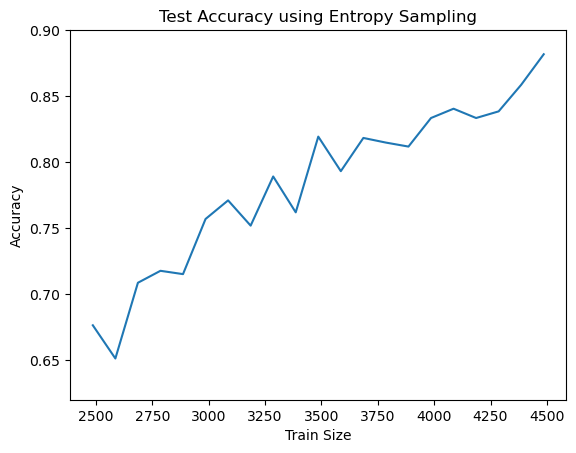

In [44]:
import matplotlib.pyplot as plt
x=[2486+(i*100) for i in range(21)]
plt.ylim((0.62,0.90))
plt.plot(x,test_acc_list)
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.title("Test Accuracy using Entropy Sampling")
# plt.axhline(0.98)
plt.show()


In [36]:
max(test_acc_list)

tensor(0.8817)

In [46]:
final_train_losses 
final_val_losses 


NameError: name 'val_acc' is not defined

Text(0.5, 1.0, 'Validation Accuracy - AL')

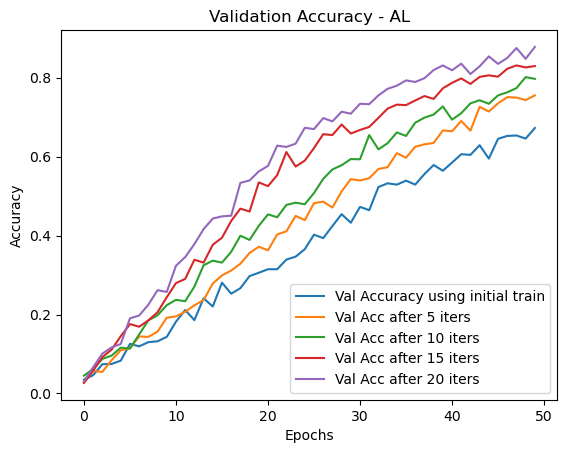

In [63]:
plt.plot(final_val_accs[0],label='Val Accuracy using initial train')
plt.plot(final_val_accs[5],label= "Val Acc after 5 iters")
plt.plot(final_val_accs[10],label= "Val Acc after 10 iters")
plt.plot(final_val_accs[15],label= "Val Acc after 15 iters")
plt.plot(final_val_accs[-1],label= "Val Acc after 20 iters")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy - AL")

Text(0.5, 1.0, 'Training Loss - AL')

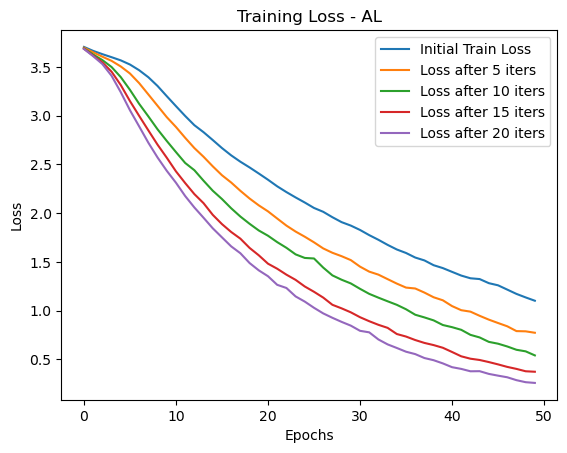

In [64]:
plt.plot(final_train_losses[0],label='Initial Train Loss')
plt.plot(final_train_losses[5],label='Loss after 5 iters')
plt.plot(final_train_losses[10],label='Loss after 10 iters')
plt.plot(final_train_losses[15],label='Loss after 15 iters')
plt.plot(final_train_losses[-1],label='Loss after 20 iters')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss - AL")

Text(0.5, 1.0, 'Validation Loss - AL')

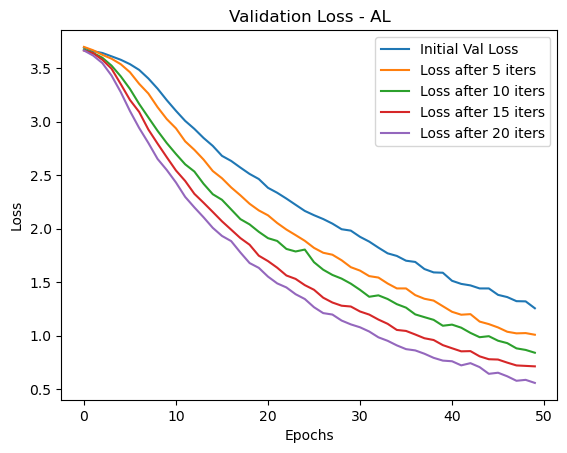

In [66]:
plt.plot(final_val_losses[0],label='Initial Val Loss')
plt.plot(final_val_losses[5],label='Loss after 5 iters')
plt.plot(final_val_losses[10],label='Loss after 10 iters')
plt.plot(final_val_losses[15],label='Loss after 15 iters')
plt.plot(final_val_losses[-1],label='Loss after 20 iters')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss - AL")